In [1]:
import os
from dotenv import load_dotenv
import Account as a
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from Account import Account
from scipy import signal
from datetime import datetime, timedelta
import alpaca_trade_api as alpacaapi
from alpaca_trade_api.rest import REST, TimeFrame, TimeFrameUnit
import backtrader as bt
import matplotlib as mpl
from findModel import remodel, find_best_model, print_line
import PyQt5
import backtrader.feeds as btfeeds

%load_ext autoreload
%autoreload 2
  # %matplotlib qt

In [2]:
class CommInfoFractional(bt.CommissionInfo):
    def getsize(self, price, cash):
        '''Returns fractional size for cash operation @price'''
        return self.p.leverage * (cash / price)

In [3]:
mpl.rcParams['figure.dpi'] = 100 # chart resolution
load_dotenv()
myAccount = Account(
    key="PAPER_API_KEY", secretKey="PAPER_API_KEY_SECRET", endpoint="PAPER_API_ENDPOINT"
)

def run_backtest(strategy, symbols, start, end, timeframe=TimeFrame.Minute, cash=10000):
    '''params:
        strategy: the strategy you wish to backtest, an instance of backtrader.Strategy
        symbols: the symbol (str) or list of symbols List[str] you wish to backtest on
        start: start date of backtest in format 'YYYY-MM-DD'
        end: end date of backtest in format: 'YYYY-MM-DD'
        timeframe: the timeframe the strategy trades on (size of bars) -
                   1 min: TimeFrame.Minute, 1 day: TimeFrame.Day, 5 min: TimeFrame(5, TimeFrameUnit.Minute)
        cash: the starting cash of backtest
    '''

    # initialize backtrader broker
    cerebro = bt.Cerebro(stdstats=True)
    cerebro.broker.setcash(cash)
#     cerebro.broker.setcommission(commission=0.001)

    # add strategy
    cerebro.addstrategy(strategy)

    # add analytics+
    # cerebro.addobserver(bt.observers.Value)
    # cerebro.addobserver(bt.observers.BuySell)
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='mysharpe')
    cerebro.broker.set_shortcash(False) #allows shorting without using margin
    cerebro.broker.addcommissioninfo(CommInfoFractional()) #enables fractional shares
    cerebro.broker.set_coc(True)#cheat on close dunno what it does
    
    # historical data request
    if type(symbols) == str:
        symbol = symbols
        alpaca_data = myAccount.api.get_crypto_bars(
            "BTCUSD",
            start=start,
            end=end,
            timeframe=TimeFrame(30, TimeFrameUnit.Minute),
        ).df
        data = bt.feeds.PandasData(dataname=alpaca_data[alpaca_data.exchange == "CBSE"], name=symbol)
        cerebro.adddata(data)
    elif type(symbols) == list or type(symbols) == set:
        for symbol in symbols:
            alpaca_data = rest_api.get_bars(symbol, timeframe, start, end, adjustment='all').df
            data = bt.feeds.PandasData(dataname=alpaca_data, name=symbol)
            cerebro.adddata(data)

    # run
    initial_portfolio_value = cerebro.broker.getvalue()
    print(f'Starting Portfolio Value: {initial_portfolio_value}')
    
    results = cerebro.run() #starts everything
    final_portfolio_value = cerebro.broker.getvalue()
    print(f'Final Portfolio Value: {final_portfolio_value} ---> Return: {(final_portfolio_value/initial_portfolio_value - 1)*100}%')

    strat = results[0]
    print('Sharpe Ratio:', strat.analyzers.mysharpe.get_analysis()['sharperatio'])
#     cerebro.plot(style='bar') #plots

In [10]:
class strategy(bt.Strategy):
    buy_stop = None
    sell_stop = None
    
    def __init__(self):
        self.dataclose = self.datas[0].close
        self.vwap = self.datas[0]._dataname[self.datas[0]._dataname.exchange == "CBSE"]
        print(self.vwap.head(24))
        self.order = None
        self.buyprice = None
        self.buycomm = None
        self.best_model = None

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.data.datetime[0]
        if isinstance(dt, float):
            dt = bt.num2date(dt)
        print('%s, %s' % (dt.isoformat(), txt))

    def start(self):
        print("START!@#!@#!@#")  # keep the starting cash

    def nextstart(self):
        print_line("First Model")
        endDate = (self.datas[0].datetime.datetime()
           ).strftime("%Y-%m-%dT%H:%M:%SZ")
        prevDate = (datetime.strptime(endDate, "%Y-%m-%dT%H:%M:%SZ") - timedelta(days=5)
            ).strftime("%Y-%m-%dT%H:%M:%SZ")
        
        self.best_model = find_best_model(myAccount, prevDate, endDate)
        self.best_model.set_up_model()
        
        self.last_value = self.dataclose[0]
        self.current_model_value = self.best_model.get_last_model_value()
        self.predicted_model_next_value = self.best_model.make_next_value_prediction()

        
    def notify_order(self, order):       
        if order.status in [order.Submitted, order.Accepted]:
            return
        
        if order.status in [order.Expired]:
            self.log('ORDER EXPIRED')
            
        if order.status in [order.Completed]:
            if order.isbuy():
                if order.params.exectype == 2:
                    print("Limit ordering")
                    self.cancel_all_orders()
#                     buy = self.sell(
#                         exectype=bt.Order.StopTrail, 
#                         trailamount = 450, 
#                         size = order.size)
#                     self.print_order_details(buy)
#                     print(buy.getstatusname())
                self.log(
                    'BUY EXECUTED, Price: %.2f, Costed Total Of: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))
                
            else:  # Sell
                if order.params.exectype == 2:
                    print("Limit ordering")
                    self.cancel_all_orders()
#                     sell = self.buy(
#                             exectype=bt.Order.StopTrail, 
#                             trailamount = 450, 
#                             size =  order.size)
#                     self.print_order_details(sell)
#                     print(sell.getstatusname())
                self.log('SELL EXECUTED, Price: %.2f, Costed Total Of: %.2f, Comm %.2f' %
                     (order.executed.price,
                      order.executed.value,
                      order.executed.comm))
            
        elif order.status in [order.Canceled]:
            self.log('Order Canceled')        
        elif order.status in [order.Margin]:
            self.log('Insufficient Margin for order of type ' + str(order.params.exectype))        
        elif order.status in [order.Rejected]:
            self.log('Order Rejected')
        self.order = None
        
        
    def cancel_all_orders(self):
        [self.cancel(o) for o in self.broker.orders if o.status < 4]
        
    def print_all_open_orders(self):
        [self.print_order_details(o) for o in self.broker.get_orders_open()]
        
    def print_order_details(self, o):
        print('-----Asset:             {}'.format(o.params.data._name))
        print('-----Order Size:        {}'.format(o.params.size))
        print('-----Order price:        {}'.format(o.params.price))
        print('-----Order Type:        {}'.format(o.params.exectype))
        print('-----Trail Amount:        {}'.format(o.params.trailamount))
        print('-----Trail Percent:        {}'.format(o.params.trailpercent))
        print('-----Created Price:        {}'.format(o.created.price))
        print('-----Is Buy:        {}'.format(o.isbuy()))
            
    def notify_trade(self, trade):
        if not trade.isclosed:
            return
        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def limit_order_next_candle(self, side):
#         o1 = self.order_target_percent(
#             target=-0.99,
#             exectype=bt.Order.Limit,
#             price=self.best_model.sell_value,
#             valid=timedelta(minutes=30))

#         o2 = self.order_target_percent(
#             target=0.99,
#             exectype=bt.Order.Limit,
#             price=self.best_model.buy_value,
#             valid=timedelta(minutes=30),
#             oco=o1)
        if self.position.size > 0.1:
            self.sell(
                size = self.position.size,
                exectype=bt.Order.Limit, 
                price = self.best_model.max_value_allowed, 
                valid=timedelta(minutes=30))
        elif self.position.size < -0.1:
            self.buy(
                size = self.position.size,
                exectype=bt.Order.Limit, 
                price = self.best_model.min_value_allowed, 
                valid=timedelta(minutes=30))
        elif side == 1:
            buy = self.order_target_percent(
                target=0.99, 
                exectype=bt.Order.Limit, 
                price = self.best_model.buy_value, 
                valid=timedelta(minutes=30))
            self.sell(
                exectype=bt.Order.StopTrail, 
                trailpercent=0.015, 
                size = buy.size,
                parent = buy)
        elif side == -1:
            sell = self.order_target_percent(
                target=-0.99, 
                exectype=bt.Order.Limit, 
                price = self.best_model.sell_value, 
                valid=timedelta(minutes=30))
            self.buy(
                exectype=bt.Order.StopTrail, 
                trailpercent=0.015, 
                size = sell.size,
                parent = sell)

        
        print('{}: Limit Order / Buy at {}'.format(
            self.datetime.date(), self.best_model.buy_value))
        print('{}: Limit Order / Sell at {}'.format(
            self.datetime.date(), self.best_model.sell_value))
        
    def load_up(self):
        size = (self.broker.get_cash() / self.last_value)*0.99
        
        #if we are short any amount
        if self.position.size<-0.1:
            self.log('BUY CREATE, %.2f and now rebalancing portfolio' % self.dataclose[0])
            self.cancel_all_orders()
            buy = self.buy(size = self.position.size * -2 )
            self.sell(
                exectype=bt.Order.StopTrail, 
                trailpercent = 0.015, 
                size = buy.size,
                parent= buy)
        elif self.position.size<0.1:
            self.log('BUY CREATE, %.2f and now rebalancing portfolio' % self.dataclose[0])
            self.cancel_all_orders()
            buy = self.buy(size = size )
            self.sell(
                exectype=bt.Order.StopTrail, 
                trailpercent = 0.015, 
                size = buy.size,
                parent = buy)
        
    def sell_all(self):
        size = (self.broker.get_cash() / self.last_value)*0.99
        
        #if we are long any amount
        if self.position.size>0.1:
            self.log('SELL CREATE, %.2f and now rebalancing portfolio' % self.dataclose[0])
            self.cancel_all_orders()
            sell = self.sell(size = self.position.size * 2 )
            self.buy(
                exectype=bt.Order.StopTrail, 
                trailpercent = 0.015, 
                size = sell.size,
                parent= sell)
        
        elif self.position.size>-0.1:
            self.log('SELL CREATE, %.2f and now rebalancing portfolio' % self.dataclose[0])
            self.cancel_all_orders()
            sell = self.sell(size = size )
            self.buy(
                exectype=bt.Order.StopTrail, 
                trailpercent = 0.015, 
                size = sell.size,
                parent = sell)
            
    def equalize(self):
        self.cancel_all_orders()
        
        if self.position.size>0.1:
            self.sell(size = self.position.size)
        elif self.position.size<-0.1:
            self.buy(size = self.position.size * -1)
            
    def check_for_trades(self):
        if self.predicted_model_next_value > self.current_model_value:
            print_line("In Uptrend")
            if self.last_value <= self.best_model.buy_value:
                print("buy value", self.best_model.buy_value)
                self.load_up()
            else:
                self.limit_order_next_candle(1)
                
        elif self.predicted_model_next_value < self.current_model_value:
            print_line("In Downtrend")
            if self.last_value >= self.best_model.sell_value:
                print("sell value", self.best_model.sell_value)
                self.sell_all()
            else:
                self.limit_order_next_candle(-1)

    def next(self):
        print("\n")
        endDate = (self.datas[0].datetime.datetime()
           ).strftime("%Y-%m-%dT%H:%M:%SZ")
        prevDate = (datetime.strptime(endDate, "%Y-%m-%dT%H:%M:%SZ") - timedelta(days=7)
                    ).strftime("%Y-%m-%dT%H:%M:%SZ")
        self.log('Close, %.2f' % self.dataclose[0])

        print_line(self.position)
        print("Open Orders: ")
        self.print_all_open_orders()
            
        self.last_value = self.dataclose[0]
        self.log('predict, and max, min %.2f,  %.2f,%.2f,' %
                 (self.current_model_value, self.best_model.max_value_allowed, self.best_model.min_value_allowed))
        print("Portfolio", self.broker.getvalue(),"the other one", self.broker.getcash())
        
        if self.last_value >= self.best_model.max_value_allowed:

            (self.best_model,
            self.current_value,
            self.current_model_value,
            self.predicted_model_next_value,
            ) = remodel(myAccount, prevDate, endDate)
            BTCHbars = myAccount.getHourData(prevDate, endDate)
            BTCHbars = pd.DataFrame(
                {"TimeStamp": BTCHbars.index, "VWAP": BTCHbars.values})
            BTCHbars["Time"] = np.arange(len(BTCHbars.index))
                        
            if self.position.size < -0.1:
                self.equalize()
                print_line("Close all short positions here")
                
            print("current model value",self.current_model_value, "predicted model next value", self.predicted_model_next_value)
            self.best_model.show_plot()            
            return
        elif self.last_value <= self.best_model.min_value_allowed:
            (self.best_model,
            self.current_value,
            self.current_model_value,
            self.predicted_model_next_value,
            ) = remodel(myAccount, prevDate, endDate)
            BTCHbars = myAccount.getHourData(prevDate, endDate)
            BTCHbars = pd.DataFrame(
                {"TimeStamp": BTCHbars.index, "VWAP": BTCHbars.values})
            BTCHbars["Time"] = np.arange(len(BTCHbars.index))
            
            if self.position.size > 0.1:
                self.equalize()
                print_line("Close all long positions here")
            print("current model value",self.current_model_value, "predicted model next value", self.predicted_model_next_value)
            self.best_model.show_plot()            
            return

        self.check_for_trades()
        
        next_y = self.vwap.loc[(self.datas[0].datetime.datetime()).strftime("%Y-%m-%d %H:%M:00+00:00")]["vwap"]
              
        self.best_model.x = pd.concat([self.best_model.x, pd.DataFrame(
            {"Time": [len(self.best_model.x)]})], ignore_index=True)
        self.best_model.y = pd.concat([self.best_model.y, pd.DataFrame(
            {"VWAP": [next_y]})], ignore_index=True)

        self.current_model_value = self.best_model.predict_at_n(
            len(self.best_model.y)-1)
        self.predicted_model_next_value = self.best_model.predict_at_n(len(self.best_model.y))
        self.best_model.predicted_y = np.append(self.best_model.predicted_y, self.current_model_value)
        self.best_model.set_up_model()
        
        print("current model value",self.current_model_value, "predicted model next value", self.predicted_model_next_value)
                
        self.best_model.show_plot()

Starting Portfolio Value: 100000
                          exchange      open      high       low     close  \
timestamp                                                                    
2022-06-12 01:00:00+00:00     CBSE  28478.43  28492.78  28226.80  28281.26   
2022-06-12 01:30:00+00:00     CBSE  28281.27  28379.62  28123.58  28201.61   
2022-06-12 02:00:00+00:00     CBSE  28204.02  28309.54  27800.00  27886.90   
2022-06-12 02:30:00+00:00     CBSE  27886.90  27920.38  27280.01  27394.00   
2022-06-12 03:00:00+00:00     CBSE  27394.54  27560.65  27242.77  27503.23   
2022-06-12 03:30:00+00:00     CBSE  27504.31  27731.44  27496.09  27515.33   
2022-06-12 04:00:00+00:00     CBSE  27517.76  27617.51  27437.00  27490.68   
2022-06-12 04:30:00+00:00     CBSE  27490.65  27549.21  27386.85  27397.91   
2022-06-12 05:00:00+00:00     CBSE  27394.47  27433.40  27193.47  27241.89   
2022-06-12 05:30:00+00:00     CBSE  27240.41  27412.00  27148.46  27246.93   
2022-06-12 06:00:00+00:00     C

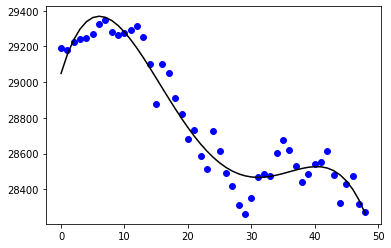

Limit ordering
2022-06-12T02:00:00, BUY EXECUTED, Price: 28182.05, Costed Total Of: 99000.00, Comm 0.00
2022-06-12T02:00:00, Order Canceled


2022-06-12T02:00:00, Close, 27886.90
2022-08-21 16:46:50:  --- Position Begin
- Size: 3.512874586661999
- Price: 28182.047937575735
- Price orig: 0.0
- Closed: 0
- Opened: 3.512874586661999
- Adjbase: 27886.9
--- Position End
Open Orders: 
2022-06-12T02:00:00, predict, and max, min 28261.28,  28425.71,28096.85,
Portfolio 98963.18231078451 the other one 1000.0
2022-08-21 16:46:50:  Finding the best model and optimizing time...
2022-08-21 16:46:56:  FInished computing all models... Finding and returning best model
2022-08-21 16:46:56:  Remodeling inaccurate model...
2022-08-21 16:46:56:  Close all long positions here
current model value 28151.137535519112 predicted model next value 28125.38856630236


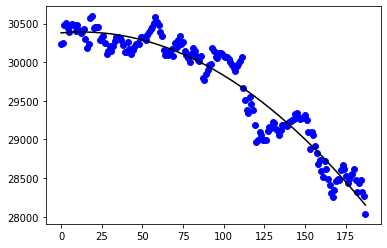

2022-06-12T02:30:00, SELL EXECUTED, Price: 27886.90, Costed Total Of: 99000.00, Comm 0.00
2022-06-12T02:30:00, OPERATION PROFIT, GROSS -1036.82, NET -1036.82


2022-06-12T02:30:00, Close, 27394.00
2022-08-21 16:46:56:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 28182.047937575735
- Closed: -3.512874586661999
- Opened: 0
- Adjbase: 27886.9
--- Position End
Open Orders: 
2022-06-12T02:30:00, predict, and max, min 28151.14,  28484.94,27817.33,
Portfolio 98963.1823107845 the other one 98963.1823107845
2022-08-21 16:46:56:  Finding the best model and optimizing time...
2022-08-21 16:47:02:  FInished computing all models... Finding and returning best model
2022-08-21 16:47:02:  Remodeling inaccurate model...
current model value 28102.87548108895 predicted model next value 28076.499487129036


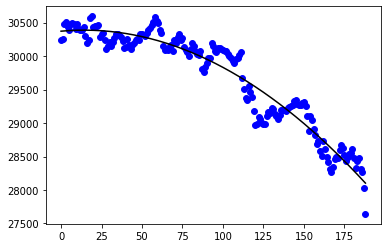



2022-06-12T03:00:00, Close, 27503.23
2022-08-21 16:47:02:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 28182.047937575735
- Closed: -3.512874586661999
- Opened: 0
- Adjbase: 27886.9
--- Position End
Open Orders: 
2022-06-12T03:00:00, predict, and max, min 28102.88,  28441.27,27764.48,
Portfolio 98963.1823107845 the other one 98963.1823107845
2022-08-21 16:47:02:  Finding the best model and optimizing time...
2022-08-21 16:47:08:  FInished computing all models... Finding and returning best model
2022-08-21 16:47:08:  Remodeling inaccurate model...
current model value 28047.372883656994 predicted model next value 28020.227972586676


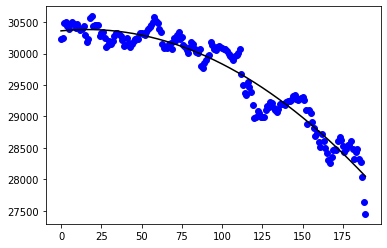



2022-06-12T03:30:00, Close, 27515.33
2022-08-21 16:47:08:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 28182.047937575735
- Closed: -3.512874586661999
- Opened: 0
- Adjbase: 27886.9
--- Position End
Open Orders: 
2022-06-12T03:30:00, predict, and max, min 28047.37,  28397.38,27697.37,
Portfolio 98963.1823107845 the other one 98963.1823107845
2022-08-21 16:47:08:  Finding the best model and optimizing time...
2022-08-21 16:47:13:  FInished computing all models... Finding and returning best model
2022-08-21 16:47:13:  Remodeling inaccurate model...
current model value 28000.02601995694 predicted model next value 27972.2982519173


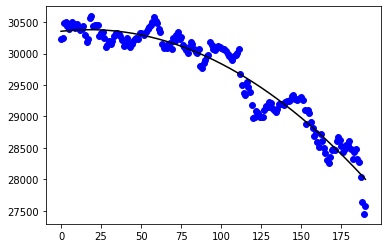



2022-06-12T04:00:00, Close, 27490.68
2022-08-21 16:47:14:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 28182.047937575735
- Closed: -3.512874586661999
- Opened: 0
- Adjbase: 27886.9
--- Position End
Open Orders: 
2022-06-12T04:00:00, predict, and max, min 28000.03,  28352.42,27647.63,
Portfolio 98963.1823107845 the other one 98963.1823107845
2022-08-21 16:47:14:  Finding the best model and optimizing time...
2022-08-21 16:47:19:  FInished computing all models... Finding and returning best model
2022-08-21 16:47:19:  Remodeling inaccurate model...
current model value 27951.184703742867 predicted model next value 27922.853478126388


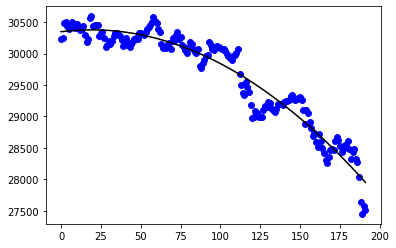



2022-06-12T04:30:00, Close, 27397.91
2022-08-21 16:47:19:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 28182.047937575735
- Closed: -3.512874586661999
- Opened: 0
- Adjbase: 27886.9
--- Position End
Open Orders: 
2022-06-12T04:30:00, predict, and max, min 27951.18,  28306.75,27595.62,
Portfolio 98963.1823107845 the other one 98963.1823107845
2022-08-21 16:47:19:  Finding the best model and optimizing time...
2022-08-21 16:47:24:  FInished computing all models... Finding and returning best model
2022-08-21 16:47:24:  Remodeling inaccurate model...
current model value 27902.18322548044 predicted model next value 27873.25626598693


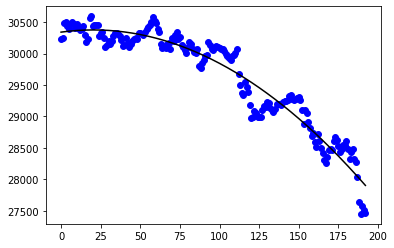



2022-06-12T05:00:00, Close, 27241.89
2022-08-21 16:47:24:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 28182.047937575735
- Closed: -3.512874586661999
- Opened: 0
- Adjbase: 27886.9
--- Position End
Open Orders: 
2022-06-12T05:00:00, predict, and max, min 27902.18,  28260.71,27543.65,
Portfolio 98963.1823107845 the other one 98963.1823107845
2022-08-21 16:47:24:  Finding the best model and optimizing time...
2022-08-21 16:47:29:  FInished computing all models... Finding and returning best model
2022-08-21 16:47:29:  Remodeling inaccurate model...
current model value 27848.675883416476 predicted model next value 27819.070533404894


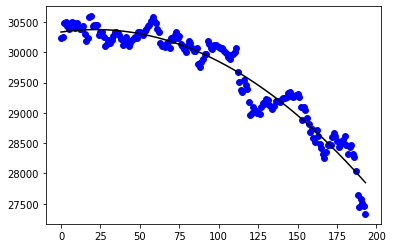



2022-06-12T05:30:00, Close, 27246.93
2022-08-21 16:47:29:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 28182.047937575735
- Closed: -3.512874586661999
- Opened: 0
- Adjbase: 27886.9
--- Position End
Open Orders: 
2022-06-12T05:30:00, predict, and max, min 27848.68,  28212.39,27484.96,
Portfolio 98963.1823107845 the other one 98963.1823107845
2022-08-21 16:47:29:  Finding the best model and optimizing time...
2022-08-21 16:47:34:  FInished computing all models... Finding and returning best model
2022-08-21 16:47:34:  Remodeling inaccurate model...
current model value 27794.569515881838 predicted model next value 27764.285672783277


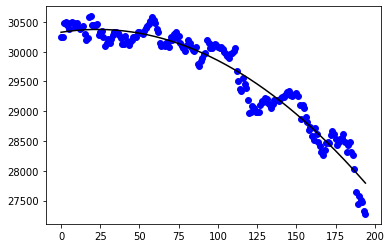



2022-06-12T06:00:00, Close, 27445.08
2022-08-21 16:47:35:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 28182.047937575735
- Closed: -3.512874586661999
- Opened: 0
- Adjbase: 27886.9
--- Position End
Open Orders: 
2022-06-12T06:00:00, predict, and max, min 27794.57,  28163.08,27426.06,
Portfolio 98963.1823107845 the other one 98963.1823107845
2022-08-21 16:47:35:  In Downtrend
2022-06-12: Limit Order / Buy at 27595.911076060467
2022-06-12: Limit Order / Sell at 27929.875230947226
current model value 27764.285672783277 predicted model next value 27733.825049182968


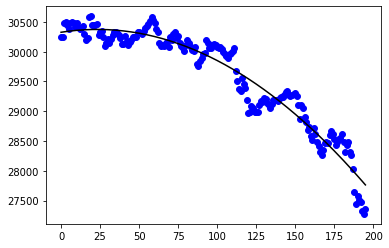

Limit ordering
2022-06-12T06:30:00, BUY EXECUTED, Price: 27444.65, Costed Total Of: 97436.53, Comm 0.00
2022-06-12T06:30:00, Order Canceled


2022-06-12T06:30:00, Close, 27448.73
2022-08-21 16:47:35:  --- Position Begin
- Size: 3.5502922957549674
- Price: 27444.65
- Price orig: 0.0
- Closed: 0
- Opened: 3.5502922957549674
- Adjbase: 27448.73
--- Position End
Open Orders: 
2022-06-12T06:30:00, predict, and max, min 27764.29,  28135.28,27393.29,
Portfolio 98977.66750335117 the other one 1526.6528560929291
2022-08-21 16:47:35:  In Downtrend
2022-06-12: Limit Order / Buy at 27560.139677445826
2022-06-12: Limit Order / Sell at 27900.08292115514
current model value 27733.825049182968 predicted model next value 27703.18764508091


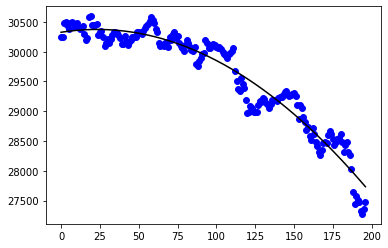

Limit ordering
2022-06-12T07:00:00, BUY EXECUTED, Price: 27448.65, Costed Total Of: 534.70, Comm 0.00
2022-06-12T07:00:00, Order Canceled


2022-06-12T07:00:00, Close, 27373.98
2022-08-21 16:47:35:  --- Position Begin
- Size: 3.569772464844922
- Price: 27444.6718279112
- Price orig: 27444.65
- Closed: 0
- Opened: 0.01948016908995473
- Adjbase: 27373.98
--- Position End
Open Orders: 
2022-06-12T07:00:00, predict, and max, min 27733.83,  28104.38,27363.27,
Portfolio 98710.82857001755 the other one 991.9485128019433
2022-08-21 16:47:35:  In Downtrend
2022-06-12: Limit Order / Buy at 27529.626598811912
2022-06-12: Limit Order / Sell at 27869.32650825252
current model value 27703.18764508091 predicted model next value 27672.373460477105


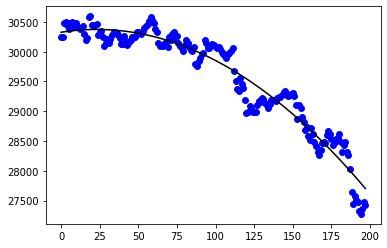

Limit ordering
2022-06-12T07:30:00, BUY EXECUTED, Price: 27372.92, Costed Total Of: 4.81, Comm 0.00
2022-06-12T07:30:00, Order Canceled


2022-06-12T07:30:00, Close, 27605.15
2022-08-21 16:47:35:  --- Position Begin
- Size: 3.5699482836881016
- Price: 27444.66829415598
- Price orig: 27444.6718279112
- Closed: 0
- Opened: 0.0001758188431795985
- Adjbase: 27605.15
--- Position End
Open Orders: 
2022-06-12T07:30:00, predict, and max, min 27703.19,  28073.42,27332.95,
Portfolio 99536.09370112569 the other one 987.1358376730956
2022-08-21 16:47:35:  In Downtrend
2022-06-12: Limit Order / Buy at 27498.90152347424
2022-06-12: Limit Order / Sell at 27838.44445647779
current model value 27672.373460477105 predicted model next value 27641.382495371552


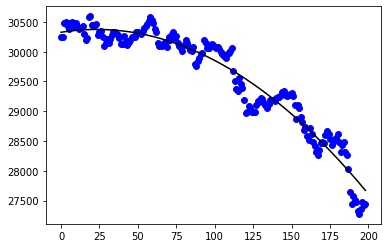

Limit ordering
2022-06-12T08:00:00, SELL EXECUTED, Price: 27605.24, Costed Total Of: 8.21, Comm 0.00
2022-06-12T08:00:00, Order Canceled


2022-06-12T08:00:00, Close, 27595.76
2022-08-21 16:47:35:  --- Position Begin
- Size: 3.5696491772190253
- Price: 27444.66829415598
- Price orig: 27444.66829415598
- Closed: -0.0002991064690761944
- Opened: 0
- Adjbase: 27595.76
--- Position End
Open Orders: 
2022-06-12T08:00:00, predict, and max, min 27672.37,  28041.86,27302.88,
Portfolio 99502.57472227118 the other one 995.3927435374965
2022-08-21 16:47:35:  In Downtrend
2022-06-12: Limit Order / Buy at 27468.280081575656
2022-06-12: Limit Order / Sell at 27807.252804651864
current model value 27641.382495371552 predicted model next value 27610.214749764255


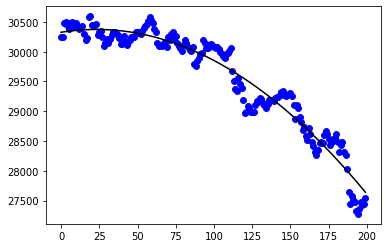



2022-06-12T08:30:00, Close, 27526.23
2022-08-21 16:47:35:  --- Position Begin
- Size: 3.5696491772190253
- Price: 27444.66829415598
- Price orig: 27444.66829415598
- Closed: -0.0002991064690761944
- Opened: 0
- Adjbase: 27526.23
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        7.085012400823127
-----Order price:        27807.252804651864
-----Order Type:        2
-----Trail Amount:        None
-----Trail Percent:        None
-----Created Price:        27807.252804651864
-----Is Buy:        False
-----Asset:             BTCUSD
-----Order Size:        1.3360731494441436e-05
-----Order price:        27468.280081575656
-----Order Type:        2
-----Trail Amount:        None
-----Trail Percent:        None
-----Created Price:        27468.280081575656
-----Is Buy:        True
2022-06-12T08:30:00, predict, and max, min 27641.38,  28010.32,27272.45,
Portfolio 99254.37701497914 the other one 995.3927435374965
2022-08-21 16:47:35:  In Downtrend
2022-06-12

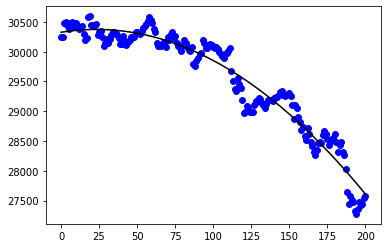

2022-06-12T09:00:00, ORDER EXPIRED
2022-06-12T09:00:00, Order Canceled
Limit ordering
2022-06-12T09:00:00, BUY EXECUTED, Price: 27437.27, Costed Total Of: 2.85, Comm 0.00
2022-06-12T09:00:00, Order Canceled


2022-06-12T09:00:00, Close, 27515.58
2022-08-21 16:47:35:  --- Position Begin
- Size: 3.569753013115812
- Price: 27444.668078915143
- Price orig: 27444.66829415598
- Closed: 0
- Opened: 0.00010383589678666415
- Adjbase: 27515.58
--- Position End
Open Orders: 
2022-06-12T09:00:00, predict, and max, min 27610.21,  27979.47,27240.96,
Portfolio 99216.36838277896 the other one 992.5437701497897
2022-08-21 16:47:35:  In Downtrend
2022-06-12: Limit Order / Buy at 27405.833476017815
2022-06-12: Limit Order / Sell at 27744.67761026575
current model value 27578.87022365521 predicted model next value 27547.348917044415


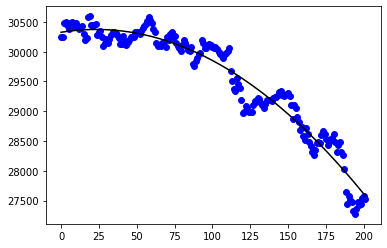



2022-06-12T09:30:00, Close, 27425.00
2022-08-21 16:47:35:  --- Position Begin
- Size: 3.569753013115812
- Price: 27444.668078915143
- Price orig: 27444.66829415598
- Closed: 0
- Opened: 0.00010383589678666415
- Adjbase: 27425.0
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        7.080566300719711
-----Order price:        27744.67761026575
-----Order Type:        2
-----Trail Amount:        None
-----Trail Percent:        None
-----Created Price:        27744.67761026575
-----Is Buy:        False
-----Asset:             BTCUSD
-----Order Size:        1.3868810898508141e-05
-----Order price:        27405.833476017815
-----Order Type:        2
-----Trail Amount:        None
-----Trail Percent:        None
-----Created Price:        27405.833476017815
-----Is Buy:        True
2022-06-12T09:30:00, predict, and max, min 27578.87,  27947.99,27209.75,
Portfolio 98893.02015485094 the other one 992.5437701497897
2022-08-21 16:47:35:  In Downtrend
2022-06-12: L

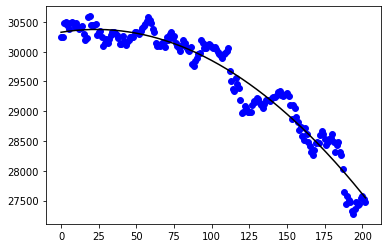

2022-06-12T10:00:00, ORDER EXPIRED
2022-06-12T10:00:00, Order Canceled
Limit ordering
2022-06-12T10:00:00, BUY EXECUTED, Price: 27374.35, Costed Total Of: 3.61, Comm 0.00
2022-06-12T10:00:00, Order Canceled


2022-06-12T10:00:00, Close, 27480.80
2022-08-21 16:47:35:  --- Position Begin
- Size: 3.5698850187490523
- Price: 27444.66547877886
- Price orig: 27444.668078915143
- Closed: 0
- Opened: 0.00013200563324049005
- Adjbase: 27480.8
--- Position End
Open Orders: 
2022-06-12T10:00:00, predict, and max, min 27547.35,  27916.08,27178.62,
Portfolio 99092.22642478747 the other one 988.9302015485184
2022-08-21 16:47:35:  In Downtrend
2022-06-12: Limit Order / Buy at 27342.7634459795
2022-06-12: Limit Order / Sell at 27681.07285007543
current model value 27515.650829931874 predicted model next value 27483.775962317588


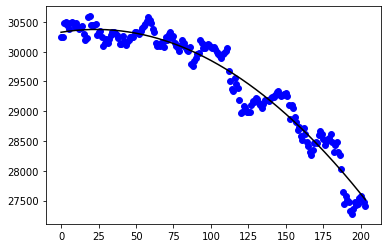

Limit ordering
2022-06-12T10:30:00, SELL EXECUTED, Price: 27478.70, Costed Total Of: 2.00, Comm 0.00
2022-06-12T10:30:00, Order Canceled


2022-06-12T10:30:00, Close, 27401.10
2022-08-21 16:47:36:  --- Position Begin
- Size: 3.56981216354174
- Price: 27444.66547877886
- Price orig: 27444.66547877886
- Closed: -7.28552073125665e-05
- Opened: 0
- Adjbase: 27401.1
--- Position End
Open Orders: 
2022-06-12T10:30:00, predict, and max, min 27515.65,  27883.78,27147.52,
Portfolio 98807.71224235726 the other one 990.9321679336982
2022-08-21 16:47:36:  In Downtrend
2022-06-12: Limit Order / Buy at 27311.05674608618
2022-06-12: Limit Order / Sell at 27649.037076306577
current model value 27483.775962317588 predicted model next value 27451.724314201554


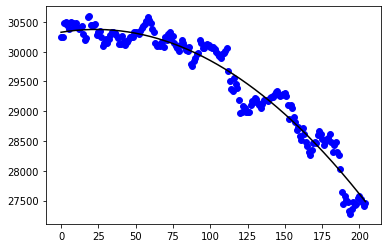

Limit ordering
2022-06-12T11:00:00, BUY EXECUTED, Price: 27311.06, Costed Total Of: 2.86, Comm 0.00
2022-06-12T11:00:00, Order Canceled


2022-06-12T11:00:00, Close, 27340.52
2022-08-21 16:47:36:  --- Position Begin
- Size: 3.56991670162449
- Price: 27444.661566306408
- Price orig: 27444.66547877886
- Closed: 0
- Opened: 0.00010453808275032841
- Adjbase: 27340.52
--- Position End
Open Orders: 
2022-06-12T11:00:00, predict, and max, min 27483.78,  27852.14,27115.41,
Portfolio 98591.45610152198 the other one 988.077122423577
2022-08-21 16:47:36:  In Downtrend
2022-06-12: Limit Order / Buy at 27279.567851958567
2022-06-12: Limit Order / Sell at 27617.048080239696
current model value 27451.724314201554 predicted model next value 27419.49588558377


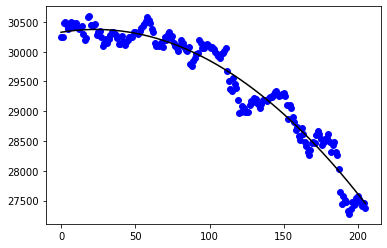



2022-06-12T11:30:00, Close, 27413.75
2022-08-21 16:47:36:  --- Position Begin
- Size: 3.56991670162449
- Price: 27444.661566306408
- Price orig: 27444.66547877886
- Closed: 0
- Opened: 0.00010453808275032841
- Adjbase: 27413.75
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        7.068420924366617
-----Order price:        27617.048080239696
-----Order Type:        2
-----Trail Amount:        None
-----Trail Percent:        None
-----Created Price:        27617.048080239696
-----Is Buy:        False
-----Asset:             BTCUSD
-----Order Size:        7.927403469498968e-05
-----Order price:        27279.567851958567
-----Order Type:        2
-----Trail Amount:        None
-----Trail Percent:        None
-----Created Price:        27279.567851958567
-----Is Buy:        True
2022-06-12T11:30:00, predict, and max, min 27451.72,  27819.63,27083.82,
Portfolio 98852.88110158195 the other one 988.077122423577
2022-08-21 16:47:36:  In Downtrend
2022-06-12: L

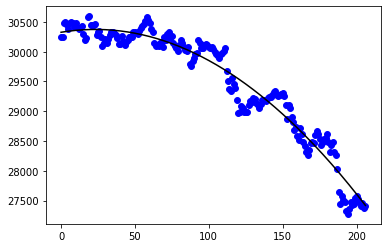

2022-06-12T12:00:00, ORDER EXPIRED
2022-06-12T12:00:00, Order Canceled
Limit ordering
2022-06-12T12:00:00, SELL EXECUTED, Price: 27413.75, Costed Total Of: 0.45, Comm 0.00
2022-06-12T12:00:00, Order Canceled


2022-06-12T12:00:00, Close, 27480.79
2022-08-21 16:47:36:  --- Position Begin
- Size: 3.5699001243557986
- Price: 27444.661566306408
- Price orig: 27444.661566306408
- Closed: -1.6577268691419006e-05
- Opened: 0
- Adjbase: 27480.79
--- Position End
Open Orders: 
2022-06-12T12:00:00, predict, and max, min 27419.50,  27788.01,27050.98,
Portfolio 99092.20720591876 the other one 988.5315675231664
2022-08-21 16:47:36:  In Downtrend
2022-06-12: Limit Order / Buy at 27215.452101622894
2022-06-12: Limit Order / Sell at 27552.192684011527
current model value 27387.090676464242 predicted model next value 27354.508686842964


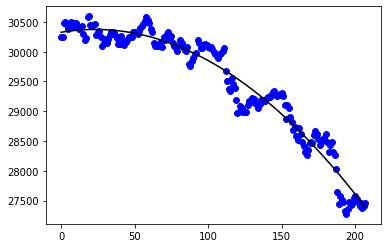

Limit ordering
2022-06-12T12:30:00, SELL EXECUTED, Price: 27552.19, Costed Total Of: 195821.09, Comm 0.00
2022-06-12T12:30:00, Order Canceled
2022-06-12T12:30:00, OPERATION PROFIT, GROSS 383.93, NET 383.93


2022-06-12T12:30:00, Close, 27399.99
2022-08-21 16:47:36:  --- Position Begin
- Size: -3.5513102643227206
- Price: 27552.192684011527
- Price orig: 27444.661566306408
- Closed: -3.5699001243557986
- Opened: -3.5513102643227206
- Adjbase: 27399.99
--- Position End
Open Orders: 
2022-06-12T12:30:00, predict, and max, min 27387.09,  27755.19,27019.00,
Portfolio 99887.62661043846 the other one 1500.7229731233529
2022-08-21 16:47:36:  In Downtrend
2022-06-12: Limit Order / Buy at 27182.9886554522
2022-06-12: Limit Order / Sell at 27519.49666546819
current model value 27354.508686842964 predicted model next value 27321.74991671994


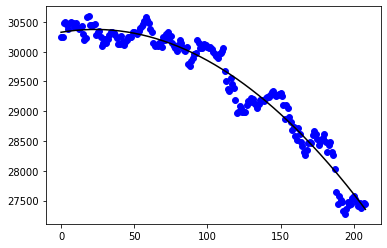

2022-06-12T13:00:00, Insufficient Margin for order of type 2
2022-06-12T13:00:00, Order Canceled


2022-06-12T13:00:00, Close, 27315.25
2022-08-21 16:47:36:  --- Position Begin
- Size: -3.5513102643227206
- Price: 27552.192684011527
- Price orig: 27444.661566306408
- Closed: -3.5699001243557986
- Opened: -3.5513102643227206
- Adjbase: 27315.25
--- Position End
Open Orders: 
2022-06-12T13:00:00, predict, and max, min 27354.51,  27722.02,26986.99,
Portfolio 100188.56464223716 the other one 1500.7229731233529
2022-08-21 16:47:36:  In Downtrend
2022-06-12: Limit Order / Buy at 27150.392290534142
2022-06-12: Limit Order / Sell at 27486.065925050818
current model value 27321.74991671994 predicted model next value 27288.81436609517


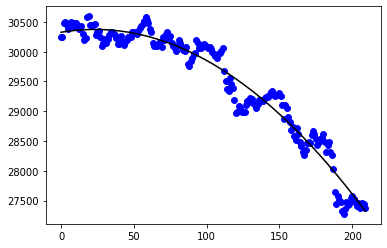

2022-06-12T13:30:00, Insufficient Margin for order of type 2
2022-06-12T13:30:00, Order Canceled


2022-06-12T13:30:00, Close, 27268.91
2022-08-21 16:47:36:  --- Position Begin
- Size: -3.5513102643227206
- Price: 27552.192684011527
- Price orig: 27444.661566306408
- Closed: -3.5699001243557986
- Opened: -3.5513102643227206
- Adjbase: 27268.91
--- Position End
Open Orders: 
2022-06-12T13:30:00, predict, and max, min 27321.75,  27689.09,26954.41,
Portfolio 100353.13235988587 the other one 1500.7229731233529
2022-08-21 16:47:36:  In Downtrend
2022-06-12: Limit Order / Buy at 27117.504136703785
2022-06-12: Limit Order / Sell at 27453.08492531334
current model value 27288.81436609517 predicted model next value 27255.70203496865


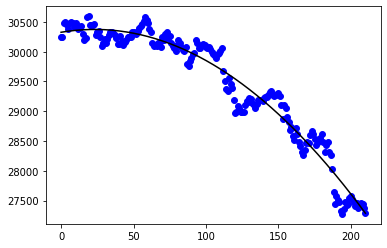

2022-06-12T14:00:00, Insufficient Margin for order of type 2
2022-06-12T14:00:00, Order Canceled


2022-06-12T14:00:00, Close, 27432.32
2022-08-21 16:47:36:  --- Position Begin
- Size: -3.5513102643227206
- Price: 27552.192684011527
- Price orig: 27444.661566306408
- Closed: -3.5699001243557986
- Opened: -3.5513102643227206
- Adjbase: 27432.32
--- Position End
Open Orders: 
2022-06-12T14:00:00, predict, and max, min 27288.81,  27656.87,26920.75,
Portfolio 99772.81274959291 the other one 1500.7229731233529
2022-08-21 16:47:36:  In Downtrend
sell value 27420.164462898636
current model value 27255.70203496865 predicted model next value 27222.412923340384


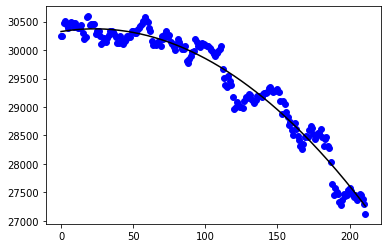



2022-06-12T14:30:00, Close, 27778.21
2022-08-21 16:47:36:  --- Position Begin
- Size: -3.5513102643227206
- Price: 27552.192684011527
- Price orig: 27444.661566306408
- Closed: -3.5699001243557986
- Opened: -3.5513102643227206
- Adjbase: 27778.21
--- Position End
Open Orders: 
2022-06-12T14:30:00, predict, and max, min 27255.70,  27622.94,26888.46,
Portfolio 98544.45004226633 the other one 1500.7229731233529
2022-08-21 16:47:36:  Finding the best model and optimizing time...
2022-08-21 16:47:42:  FInished computing all models... Finding and returning best model
2022-08-21 16:47:42:  Remodeling inaccurate model...
2022-08-21 16:47:42:  Close all short positions here
current model value 27193.3765320098 predicted model next value 27159.46387629489


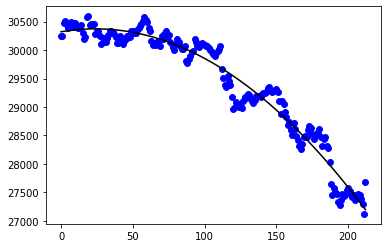

2022-06-12T15:00:00, BUY EXECUTED, Price: 27778.21, Costed Total Of: 97846.38, Comm 0.00
2022-06-12T15:00:00, OPERATION PROFIT, GROSS -802.66, NET -802.66


2022-06-12T15:00:00, Close, 28106.42
2022-08-21 16:47:42:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 27552.192684011527
- Closed: 3.5513102643227206
- Opened: 0
- Adjbase: 27778.21
--- Position End
Open Orders: 
2022-06-12T15:00:00, predict, and max, min 27193.38,  27564.29,26822.47,
Portfolio 98544.45004226633 the other one 98544.45004226633
2022-08-21 16:47:42:  Finding the best model and optimizing time...
2022-08-21 16:47:47:  FInished computing all models... Finding and returning best model
2022-08-21 16:47:47:  Remodeling inaccurate model...
current model value 27193.039269416186 predicted model next value 27159.578227780137


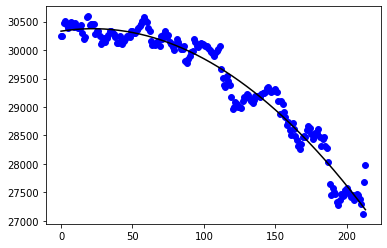



2022-06-12T15:30:00, Close, 28051.57
2022-08-21 16:47:47:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 27552.192684011527
- Closed: 3.5513102643227206
- Opened: 0
- Adjbase: 27778.21
--- Position End
Open Orders: 
2022-06-12T15:30:00, predict, and max, min 27193.04,  27584.07,26802.01,
Portfolio 98544.45004226633 the other one 98544.45004226633
2022-08-21 16:47:47:  Finding the best model and optimizing time...
2022-08-21 16:47:52:  FInished computing all models... Finding and returning best model
2022-08-21 16:47:52:  Remodeling inaccurate model...
current model value 27198.326880237877 predicted model next value 27165.416252800118


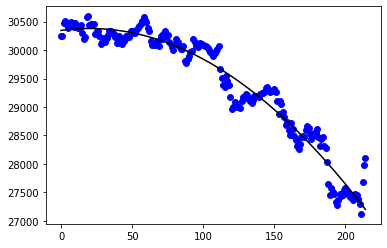



2022-06-12T16:00:00, Close, 27967.45
2022-08-21 16:47:53:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 27552.192684011527
- Closed: 3.5513102643227206
- Opened: 0
- Adjbase: 27778.21
--- Position End
Open Orders: 
2022-06-12T16:00:00, predict, and max, min 27198.33,  27615.57,26781.08,
Portfolio 98544.45004226633 the other one 98544.45004226633
2022-08-21 16:47:53:  Finding the best model and optimizing time...
2022-08-21 16:47:58:  FInished computing all models... Finding and returning best model
2022-08-21 16:47:58:  Remodeling inaccurate model...
current model value 27201.966233151794 predicted model next value 27169.56728732475


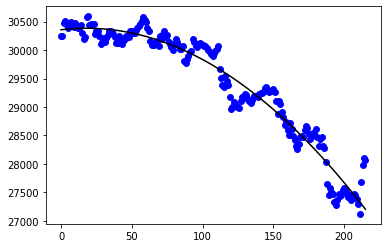



2022-06-12T16:30:00, Close, 27893.06
2022-08-21 16:47:58:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 27552.192684011527
- Closed: 3.5513102643227206
- Opened: 0
- Adjbase: 27778.21
--- Position End
Open Orders: 
2022-06-12T16:30:00, predict, and max, min 27201.97,  27639.79,26764.14,
Portfolio 98544.45004226633 the other one 98544.45004226633
2022-08-21 16:47:58:  Finding the best model and optimizing time...
2022-08-21 16:48:04:  FInished computing all models... Finding and returning best model
2022-08-21 16:48:04:  Remodeling inaccurate model...
current model value 27199.227987202503 predicted model next value 27167.215038713453


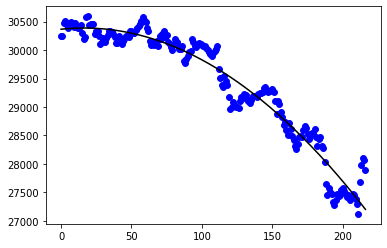



2022-06-12T17:00:00, Close, 28073.24
2022-08-21 16:48:04:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 27552.192684011527
- Closed: 3.5513102643227206
- Opened: 0
- Adjbase: 27778.21
--- Position End
Open Orders: 
2022-06-12T17:00:00, predict, and max, min 27199.23,  27646.01,26752.45,
Portfolio 98544.45004226633 the other one 98544.45004226633
2022-08-21 16:48:04:  Finding the best model and optimizing time...
2022-08-21 16:48:09:  FInished computing all models... Finding and returning best model
2022-08-21 16:48:09:  Remodeling inaccurate model...
current model value 27201.526146563978 predicted model next value 27169.986726861218


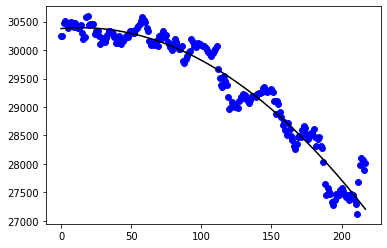



2022-06-12T17:30:00, Close, 28090.87
2022-08-21 16:48:10:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 27552.192684011527
- Closed: 3.5513102643227206
- Opened: 0
- Adjbase: 27778.21
--- Position End
Open Orders: 
2022-06-12T17:30:00, predict, and max, min 27201.53,  27660.92,26742.13,
Portfolio 98544.45004226633 the other one 98544.45004226633
2022-08-21 16:48:10:  Finding the best model and optimizing time...
2022-08-21 16:48:15:  FInished computing all models... Finding and returning best model
2022-08-21 16:48:15:  Remodeling inaccurate model...
current model value 27207.94204703021 predicted model next value 27176.945048594236


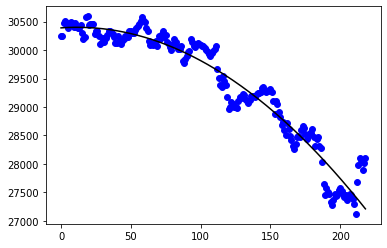



2022-06-12T18:00:00, Close, 27942.28
2022-08-21 16:48:15:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 27552.192684011527
- Closed: 3.5513102643227206
- Opened: 0
- Adjbase: 27778.21
--- Position End
Open Orders: 
2022-06-12T18:00:00, predict, and max, min 27207.94,  27684.21,26731.68,
Portfolio 98544.45004226633 the other one 98544.45004226633
2022-08-21 16:48:15:  Finding the best model and optimizing time...
2022-08-21 16:48:20:  FInished computing all models... Finding and returning best model
2022-08-21 16:48:20:  Remodeling inaccurate model...
current model value 27208.83551713902 predicted model next value 27178.27211056678


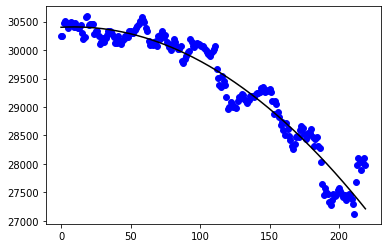



2022-06-12T18:30:00, Close, 27868.07
2022-08-21 16:48:20:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 27552.192684011527
- Closed: 3.5513102643227206
- Opened: 0
- Adjbase: 27778.21
--- Position End
Open Orders: 
2022-06-12T18:30:00, predict, and max, min 27208.84,  27694.35,26723.32,
Portfolio 98544.45004226633 the other one 98544.45004226633
2022-08-21 16:48:20:  Finding the best model and optimizing time...
2022-08-21 16:48:25:  FInished computing all models... Finding and returning best model
2022-08-21 16:48:25:  Remodeling inaccurate model...
current model value 27207.531085157443 predicted model next value 27177.35511073173


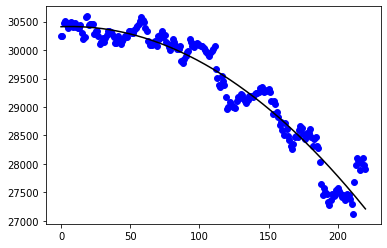



2022-06-12T19:00:00, Close, 27499.21
2022-08-21 16:48:25:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 27552.192684011527
- Closed: 3.5513102643227206
- Opened: 0
- Adjbase: 27778.21
--- Position End
Open Orders: 
2022-06-12T19:00:00, predict, and max, min 27207.53,  27699.51,26715.56,
Portfolio 98544.45004226633 the other one 98544.45004226633
2022-08-21 16:48:25:  In Downtrend
sell value 27401.15193275635
2022-06-12T19:00:00, SELL CREATE, 27499.21 and now rebalancing portfolio
current model value 27177.35511073173 predicted model next value 27147.03780388726


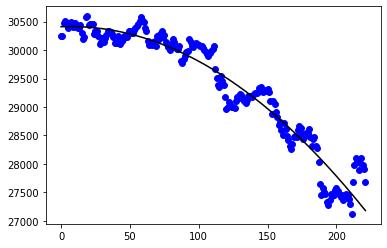

2022-06-12T19:30:00, SELL EXECUTED, Price: 27499.21, Costed Total Of: 97559.01, Comm 0.00


2022-06-12T19:30:00, Close, 27387.44
2022-08-21 16:48:26:  --- Position Begin
- Size: -3.5477021173278676
- Price: 27499.21
- Price orig: 0.0
- Closed: 0
- Opened: -3.5477021173278676
- Adjbase: 27387.44
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        3.5477021173278676
-----Order price:        None
-----Order Type:        5
-----Trail Amount:        350
-----Trail Percent:        None
-----Created Price:        27737.44
-----Is Buy:        True
2022-06-12T19:30:00, predict, and max, min 27177.36,  27671.85,26682.86,
Portfolio 98940.97670792007 the other one 985.4445004226582
2022-08-21 16:48:26:  In Downtrend
sell value 27371.520861785273
current model value 27147.03780388726 predicted model next value 27116.579164624032


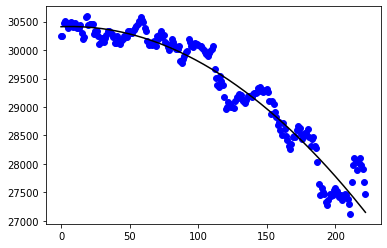



2022-06-12T20:00:00, Close, 27410.18
2022-08-21 16:48:26:  --- Position Begin
- Size: -3.5477021173278676
- Price: 27499.21
- Price orig: 0.0
- Closed: 0
- Opened: -3.5477021173278676
- Adjbase: 27410.18
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        3.5477021173278676
-----Order price:        None
-----Order Type:        5
-----Trail Amount:        350
-----Trail Percent:        None
-----Created Price:        27737.44
-----Is Buy:        True
2022-06-12T20:00:00, predict, and max, min 27147.04,  27640.97,26653.10,
Portfolio 98860.30196177203 the other one 985.4445004226582
2022-08-21 16:48:26:  In Downtrend
sell value 27340.909731829357
current model value 27116.579164624032 predicted model next value 27085.979192942053


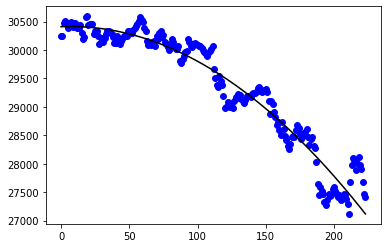



2022-06-12T20:30:00, Close, 27339.76
2022-08-21 16:48:26:  --- Position Begin
- Size: -3.5477021173278676
- Price: 27499.21
- Price orig: 0.0
- Closed: 0
- Opened: -3.5477021173278676
- Adjbase: 27339.76
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        3.5477021173278676
-----Order price:        None
-----Order Type:        5
-----Trail Amount:        350
-----Trail Percent:        None
-----Created Price:        27689.76
-----Is Buy:        True
2022-06-12T20:30:00, predict, and max, min 27116.58,  27609.84,26623.32,
Portfolio 99110.13114487426 the other one 985.4445004226582
2022-08-21 16:48:26:  In Downtrend
sell value 27310.12548101997
current model value 27085.979192942053 predicted model next value 27055.23788884132


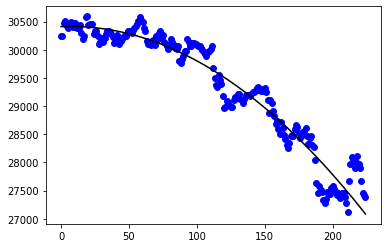



2022-06-12T21:00:00, Close, 27444.52
2022-08-21 16:48:26:  --- Position Begin
- Size: -3.5477021173278676
- Price: 27499.21
- Price orig: 0.0
- Closed: 0
- Opened: -3.5477021173278676
- Adjbase: 27444.52
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        3.5477021173278676
-----Order price:        None
-----Order Type:        5
-----Trail Amount:        350
-----Trail Percent:        None
-----Created Price:        27689.76
-----Is Buy:        True
2022-06-12T21:00:00, predict, and max, min 27085.98,  27578.50,26593.46,
Portfolio 98738.47387106298 the other one 985.4445004226582
2022-08-21 16:48:26:  In Downtrend
sell value 27279.18405707417
current model value 27055.23788884132 predicted model next value 27024.355252321828


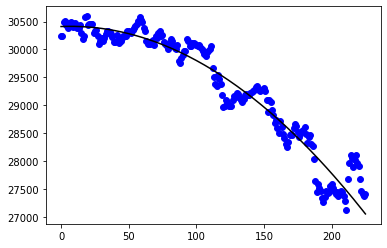



2022-06-12T21:30:00, Close, 27334.61
2022-08-21 16:48:26:  --- Position Begin
- Size: -3.5477021173278676
- Price: 27499.21
- Price orig: 0.0
- Closed: 0
- Opened: -3.5477021173278676
- Adjbase: 27334.61
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        3.5477021173278676
-----Order price:        None
-----Order Type:        5
-----Trail Amount:        350
-----Trail Percent:        None
-----Created Price:        27684.61
-----Is Buy:        True
2022-06-12T21:30:00, predict, and max, min 27055.24,  27547.62,26562.85,
Portfolio 99128.4018107785 the other one 985.4445004226582
2022-08-21 16:48:26:  In Downtrend
sell value 27248.263279869632
current model value 27024.355252321828 predicted model next value 26993.33128338358


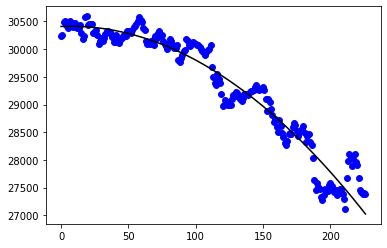



2022-06-12T22:00:00, Close, 27202.13
2022-08-21 16:48:26:  --- Position Begin
- Size: -3.5477021173278676
- Price: 27499.21
- Price orig: 0.0
- Closed: 0
- Opened: -3.5477021173278676
- Adjbase: 27202.13
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        3.5477021173278676
-----Order price:        None
-----Order Type:        5
-----Trail Amount:        350
-----Trail Percent:        None
-----Created Price:        27552.13
-----Is Buy:        True
2022-06-12T22:00:00, predict, and max, min 27024.36,  27516.69,26532.02,
Portfolio 99598.40138728208 the other one 985.4445004226582
2022-08-21 16:48:26:  In Downtrend
2022-06-12: Limit Order / Buy at 26773.016660880417
2022-06-12: Limit Order / Sell at 27217.19947055459
current model value 26993.33128338358 predicted model next value 26962.16598202658


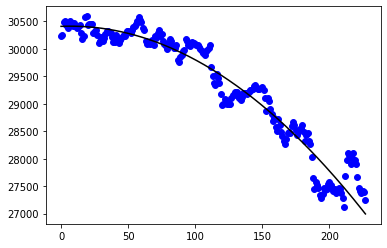

2022-06-12T22:30:00, Insufficient Margin for order of type 2
2022-06-12T22:30:00, Order Canceled


2022-06-12T22:30:00, Close, 26965.14
2022-08-21 16:48:26:  --- Position Begin
- Size: -3.5477021173278676
- Price: 27499.21
- Price orig: 0.0
- Closed: 0
- Opened: -3.5477021173278676
- Adjbase: 26965.14
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        3.5477021173278676
-----Order price:        None
-----Order Type:        5
-----Trail Amount:        350
-----Trail Percent:        None
-----Created Price:        27315.14
-----Is Buy:        True
2022-06-12T22:30:00, predict, and max, min 26993.33,  27484.70,26501.96,
Portfolio 100439.17131206761 the other one 985.4445004226582
2022-08-21 16:48:26:  In Downtrend
2022-06-12: Limit Order / Buy at 26742.1097144669
2022-06-12: Limit Order / Sell at 27185.77164711809
current model value 26962.16598202658 predicted model next value 26930.85934825083


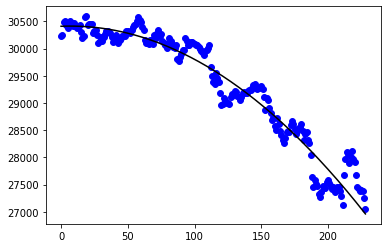

2022-06-12T23:00:00, Insufficient Margin for order of type 2
2022-06-12T23:00:00, Order Canceled


2022-06-12T23:00:00, Close, 27062.48
2022-08-21 16:48:26:  --- Position Begin
- Size: -3.5477021173278676
- Price: 27499.21
- Price orig: 0.0
- Closed: 0
- Opened: -3.5477021173278676
- Adjbase: 27062.48
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        3.5477021173278676
-----Order price:        None
-----Order Type:        5
-----Trail Amount:        350
-----Trail Percent:        None
-----Created Price:        27315.14
-----Is Buy:        True
2022-06-12T23:00:00, predict, and max, min 26962.17,  27452.96,26471.37,
Portfolio 100093.83798796692 the other one 985.4445004226582
2022-08-21 16:48:26:  In Downtrend
2022-06-12: Limit Order / Buy at 26710.959252600387
2022-06-12: Limit Order / Sell at 27154.306322458317
current model value 26930.85934825083 predicted model next value 26899.411382056318


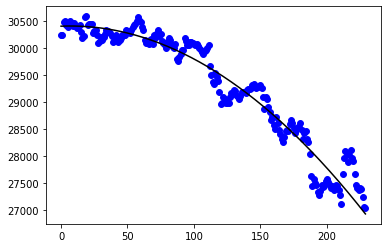

2022-06-12T23:30:00, Insufficient Margin for order of type 2
2022-06-12T23:30:00, Order Canceled


2022-06-12T23:30:00, Close, 26555.20
2022-08-21 16:48:26:  --- Position Begin
- Size: -3.5477021173278676
- Price: 27499.21
- Price orig: 0.0
- Closed: 0
- Opened: -3.5477021173278676
- Adjbase: 26555.2
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        3.5477021173278676
-----Order price:        None
-----Order Type:        5
-----Trail Amount:        350
-----Trail Percent:        None
-----Created Price:        26905.2
-----Is Buy:        True
2022-06-12T23:30:00, predict, and max, min 26930.86,  27420.93,26440.79,
Portfolio 101893.516318045 the other one 985.4445004226582
2022-08-21 16:48:26:  In Downtrend
2022-06-12: Limit Order / Buy at 26679.70454694307
2022-06-12: Limit Order / Sell at 27122.661978530807
current model value 26899.411382056318 predicted model next value 26867.822083443054


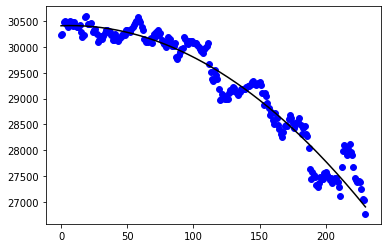

2022-06-13T00:00:00, Insufficient Margin for order of type 2
2022-06-13T00:00:00, Order Canceled


2022-06-13T00:00:00, Close, 26771.72
2022-08-21 16:48:27:  --- Position Begin
- Size: -3.5477021173278676
- Price: 27499.21
- Price orig: 0.0
- Closed: 0
- Opened: -3.5477021173278676
- Adjbase: 26771.72
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        3.5477021173278676
-----Order price:        None
-----Order Type:        5
-----Trail Amount:        350
-----Trail Percent:        None
-----Created Price:        26905.2
-----Is Buy:        True
2022-06-13T00:00:00, predict, and max, min 26899.41,  27388.59,26410.23,
Portfolio 101125.36785560117 the other one 985.4445004226582
2022-08-21 16:48:27:  In Downtrend
2022-06-13: Limit Order / Buy at 26648.356650730984
2022-06-13: Limit Order / Sell at 27090.827383816373
current model value 26867.822083443054 predicted model next value 26836.091452411034


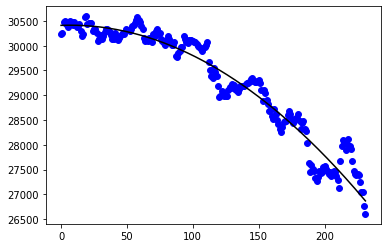

2022-06-13T00:30:00, Insufficient Margin for order of type 2
2022-06-13T00:30:00, Order Canceled


2022-06-13T00:30:00, Close, 26275.47
2022-08-21 16:48:27:  --- Position Begin
- Size: -3.5477021173278676
- Price: 27499.21
- Price orig: 0.0
- Closed: 0
- Opened: -3.5477021173278676
- Adjbase: 26275.47
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        3.5477021173278676
-----Order price:        None
-----Order Type:        5
-----Trail Amount:        350
-----Trail Percent:        None
-----Created Price:        26625.47
-----Is Buy:        True
2022-06-13T00:30:00, predict, and max, min 26867.82,  27356.10,26379.55,
Portfolio 102885.91503132513 the other one 985.4445004226582
2022-08-21 16:48:27:  Finding the best model and optimizing time...
2022-08-21 16:48:32:  FInished computing all models... Finding and returning best model
2022-08-21 16:48:32:  Remodeling inaccurate model...
current model value 26895.02587027264 predicted model next value 26864

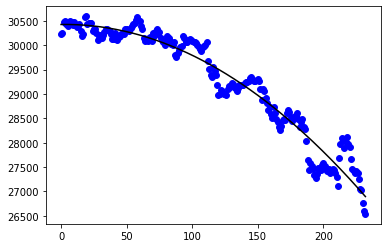



2022-06-13T01:00:00, Close, 25996.25
2022-08-21 16:48:32:  --- Position Begin
- Size: -3.5477021173278676
- Price: 27499.21
- Price orig: 0.0
- Closed: 0
- Opened: -3.5477021173278676
- Adjbase: 25996.25
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        3.5477021173278676
-----Order price:        None
-----Order Type:        5
-----Trail Amount:        350
-----Trail Percent:        None
-----Created Price:        26346.25
-----Is Buy:        True
2022-06-13T01:00:00, predict, and max, min 26895.03,  27377.55,26412.50,
Portfolio 103876.50441652542 the other one 985.4445004226582
2022-08-21 16:48:32:  Finding the best model and optimizing time...
2022-08-21 16:48:37:  FInished computing all models... Finding and returning best model
2022-08-21 16:48:37:  Remodeling inaccurate model...
current model value 26835.465778789785 predicted model next value 26803.911987526953


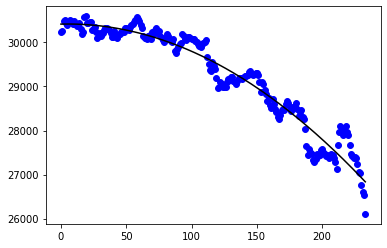



2022-06-13T01:30:00, Close, 25743.68
2022-08-21 16:48:37:  --- Position Begin
- Size: -3.5477021173278676
- Price: 27499.21
- Price orig: 0.0
- Closed: 0
- Opened: -3.5477021173278676
- Adjbase: 25743.68
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        3.5477021173278676
-----Order price:        None
-----Order Type:        5
-----Trail Amount:        350
-----Trail Percent:        None
-----Created Price:        26093.68
-----Is Buy:        True
2022-06-13T01:30:00, predict, and max, min 26835.47,  27329.50,26341.43,
Portfolio 104772.54754029891 the other one 985.4445004226582
2022-08-21 16:48:37:  Finding the best model and optimizing time...
2022-08-21 16:48:42:  FInished computing all models... Finding and returning best model
2022-08-21 16:48:42:  Remodeling inaccurate model...
current model value 26768.07657996215 predicted model next value 26735.771020253826


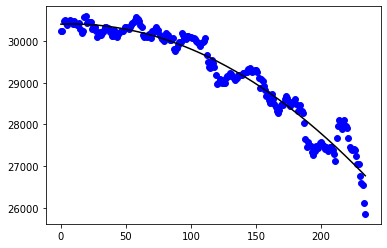



2022-06-13T02:00:00, Close, 25757.58
2022-08-21 16:48:43:  --- Position Begin
- Size: -3.5477021173278676
- Price: 27499.21
- Price orig: 0.0
- Closed: 0
- Opened: -3.5477021173278676
- Adjbase: 25757.58
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        3.5477021173278676
-----Order price:        None
-----Order Type:        5
-----Trail Amount:        350
-----Trail Percent:        None
-----Created Price:        26093.68
-----Is Buy:        True
2022-06-13T02:00:00, predict, and max, min 26768.08,  27282.92,26253.24,
Portfolio 104723.23448086805 the other one 985.4445004226582
2022-08-21 16:48:43:  Finding the best model and optimizing time...
2022-08-21 16:48:48:  FInished computing all models... Finding and returning best model
2022-08-21 16:48:48:  Remodeling inaccurate model...
current model value 26693.42639302033 predicted model next value 26660.256384012842


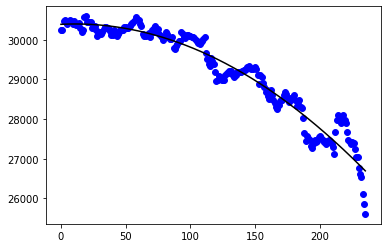



2022-06-13T02:30:00, Close, 25299.54
2022-08-21 16:48:48:  --- Position Begin
- Size: -3.5477021173278676
- Price: 27499.21
- Price orig: 0.0
- Closed: 0
- Opened: -3.5477021173278676
- Adjbase: 25299.54
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        3.5477021173278676
-----Order price:        None
-----Order Type:        5
-----Trail Amount:        350
-----Trail Percent:        None
-----Created Price:        25649.54
-----Is Buy:        True
2022-06-13T02:30:00, predict, and max, min 26693.43,  27238.27,26148.58,
Portfolio 106348.2239586889 the other one 985.4445004226582
2022-08-21 16:48:48:  Finding the best model and optimizing time...
2022-08-21 16:48:54:  FInished computing all models... Finding and returning best model
2022-08-21 16:48:54:  Remodeling inaccurate model...
current model value 26616.48708538639 predicted model next value 26582.42641893147


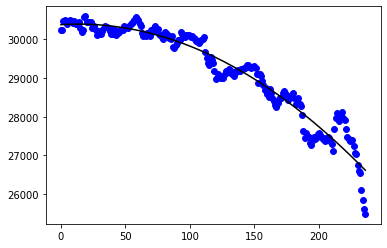



2022-06-13T03:00:00, Close, 25252.18
2022-08-21 16:48:54:  --- Position Begin
- Size: -3.5477021173278676
- Price: 27499.21
- Price orig: 0.0
- Closed: 0
- Opened: -3.5477021173278676
- Adjbase: 25252.18
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        3.5477021173278676
-----Order price:        None
-----Order Type:        5
-----Trail Amount:        350
-----Trail Percent:        None
-----Created Price:        25602.18
-----Is Buy:        True
2022-06-13T03:00:00, predict, and max, min 26616.49,  27192.44,26040.54,
Portfolio 106516.24313096557 the other one 985.4445004226582
2022-08-21 16:48:54:  Finding the best model and optimizing time...
2022-08-21 16:48:59:  FInished computing all models... Finding and returning best model
2022-08-21 16:48:59:  Remodeling inaccurate model...
current model value 26528.024795679736 predicted model next value 26492.89169598832


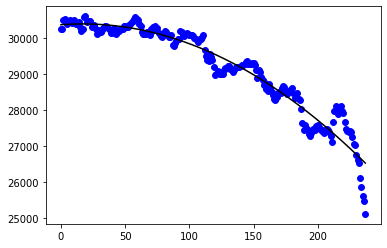

2022-06-13T03:30:00, BUY EXECUTED, Price: 25602.18, Costed Total Of: 97559.01, Comm 0.00
2022-06-13T03:30:00, OPERATION PROFIT, GROSS 6730.10, NET 6730.10


2022-06-13T03:30:00, Close, 25490.51
2022-08-21 16:48:59:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 27499.21
- Closed: 3.5477021173278676
- Opened: 0
- Adjbase: 25252.18
--- Position End
Open Orders: 
2022-06-13T03:30:00, predict, and max, min 26528.02,  27152.26,25903.79,
Portfolio 105274.5473899008 the other one 105274.5473899008
2022-08-21 16:48:59:  Finding the best model and optimizing time...
2022-08-21 16:49:04:  FInished computing all models... Finding and returning best model
2022-08-21 16:49:04:  Remodeling inaccurate model...
current model value 26451.808679748683 predicted model next value 26415.766731014817


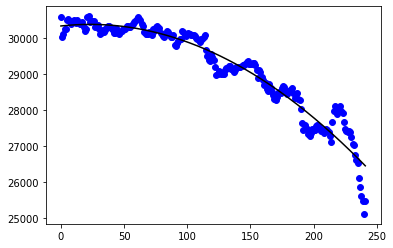



2022-06-13T04:00:00, Close, 26069.71
2022-08-21 16:49:05:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 27499.21
- Closed: 3.5477021173278676
- Opened: 0
- Adjbase: 25252.18
--- Position End
Open Orders: 
2022-06-13T04:00:00, predict, and max, min 26451.81,  27089.55,25814.07,
Portfolio 105274.5473899008 the other one 105274.5473899008
2022-08-21 16:49:05:  In Downtrend
2022-06-13: Limit Order / Buy at 26123.305944057127
2022-06-13: Limit Order / Sell at 26687.138054032566
current model value 26415.766731014817 predicted model next value 26379.559744428763


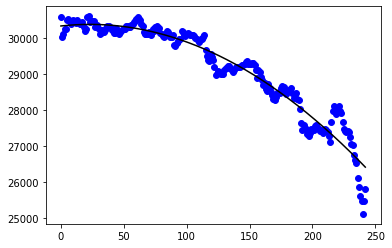

Limit ordering
2022-06-13T04:30:00, BUY EXECUTED, Price: 26063.59, Costed Total Of: 103983.56, Comm 0.00
2022-06-13T04:30:00, Order Canceled


2022-06-13T04:30:00, Close, 25366.99
2022-08-21 16:49:05:  --- Position Begin
- Size: 3.989609972765011
- Price: 26063.59
- Price orig: 0.0
- Closed: 0
- Opened: 3.989609972765011
- Adjbase: 25366.99
--- Position End
Open Orders: 
2022-06-13T04:30:00, predict, and max, min 26415.77,  27056.38,25775.15,
Portfolio 102495.3850828727 the other one 1290.9887998423947
2022-08-21 16:49:05:  Finding the best model and optimizing time...
2022-08-21 16:49:10:  FInished computing all models... Finding and returning best model
2022-08-21 16:49:10:  Remodeling inaccurate model...
2022-08-21 16:49:11:  Close all long positions here
current model value 26333.938951341705 predicted model next value 26296.81695187657


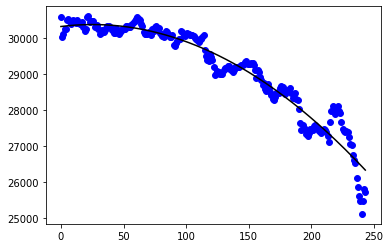

2022-06-13T05:00:00, SELL EXECUTED, Price: 25366.99, Costed Total Of: 103983.56, Comm 0.00
2022-06-13T05:00:00, OPERATION PROFIT, GROSS -2779.16, NET -2779.16


2022-06-13T05:00:00, Close, 25635.34
2022-08-21 16:49:11:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 26063.59
- Closed: -3.989609972765011
- Opened: 0
- Adjbase: 25366.99
--- Position End
Open Orders: 
2022-06-13T05:00:00, predict, and max, min 26333.94,  26978.85,25689.02,
Portfolio 102495.3850828727 the other one 102495.3850828727
2022-08-21 16:49:11:  Finding the best model and optimizing time...
2022-08-21 16:49:16:  FInished computing all models... Finding and returning best model
2022-08-21 16:49:16:  Remodeling inaccurate model...
current model value 26272.091153542176 predicted model next value 26234.393119305536


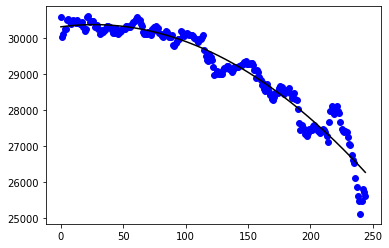



2022-06-13T05:30:00, Close, 25201.83
2022-08-21 16:49:16:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 26063.59
- Closed: -3.989609972765011
- Opened: 0
- Adjbase: 25366.99
--- Position End
Open Orders: 
2022-06-13T05:30:00, predict, and max, min 26272.09,  26922.00,25622.18,
Portfolio 102495.3850828727 the other one 102495.3850828727
2022-08-21 16:49:16:  Finding the best model and optimizing time...
2022-08-21 16:49:21:  FInished computing all models... Finding and returning best model
2022-08-21 16:49:21:  Remodeling inaccurate model...
current model value 26204.516875475136 predicted model next value 26166.15750604133


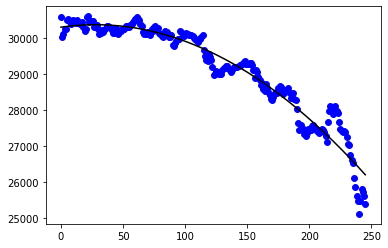



2022-06-13T06:00:00, Close, 25302.30
2022-08-21 16:49:22:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 26063.59
- Closed: -3.989609972765011
- Opened: 0
- Adjbase: 25366.99
--- Position End
Open Orders: 
2022-06-13T06:00:00, predict, and max, min 26204.52,  26863.53,25545.51,
Portfolio 102495.3850828727 the other one 102495.3850828727
2022-08-21 16:49:22:  Finding the best model and optimizing time...
2022-08-21 16:49:26:  FInished computing all models... Finding and returning best model
2022-08-21 16:49:26:  Remodeling inaccurate model...
current model value 26133.513716944366 predicted model next value 26094.446634780194


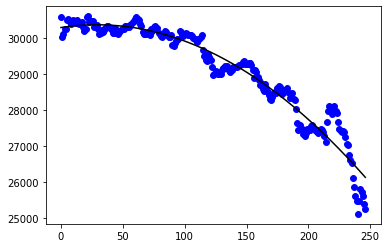



2022-06-13T06:30:00, Close, 25321.79
2022-08-21 16:49:27:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 26063.59
- Closed: -3.989609972765011
- Opened: 0
- Adjbase: 25366.99
--- Position End
Open Orders: 
2022-06-13T06:30:00, predict, and max, min 26133.51,  26803.77,25463.26,
Portfolio 102495.3850828727 the other one 102495.3850828727
2022-08-21 16:49:27:  Finding the best model and optimizing time...
2022-08-21 16:49:32:  FInished computing all models... Finding and returning best model
2022-08-21 16:49:32:  Remodeling inaccurate model...
current model value 26066.243896350126 predicted model next value 26026.539690292193


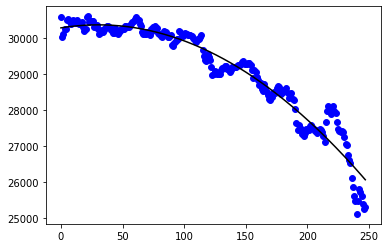



2022-06-13T07:00:00, Close, 25138.09
2022-08-21 16:49:32:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 26063.59
- Closed: -3.989609972765011
- Opened: 0
- Adjbase: 25366.99
--- Position End
Open Orders: 
2022-06-13T07:00:00, predict, and max, min 26066.24,  26743.21,25389.28,
Portfolio 102495.3850828727 the other one 102495.3850828727
2022-08-21 16:49:32:  Finding the best model and optimizing time...
2022-08-21 16:49:37:  FInished computing all models... Finding and returning best model
2022-08-21 16:49:37:  Remodeling inaccurate model...
current model value 26000.53777078056 predicted model next value 25960.23076219416


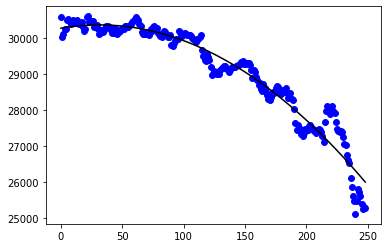



2022-06-13T07:30:00, Close, 24773.72
2022-08-21 16:49:38:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 26063.59
- Closed: -3.989609972765011
- Opened: 0
- Adjbase: 25366.99
--- Position End
Open Orders: 
2022-06-13T07:30:00, predict, and max, min 26000.54,  26682.23,25318.84,
Portfolio 102495.3850828727 the other one 102495.3850828727
2022-08-21 16:49:38:  Finding the best model and optimizing time...
2022-08-21 16:49:42:  FInished computing all models... Finding and returning best model
2022-08-21 16:49:42:  Remodeling inaccurate model...
current model value 25922.61026727993 predicted model next value 25881.512447140445


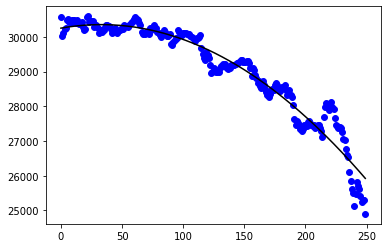



2022-06-13T08:00:00, Close, 24687.98
2022-08-21 16:49:43:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 26063.59
- Closed: -3.989609972765011
- Opened: 0
- Adjbase: 25366.99
--- Position End
Open Orders: 
2022-06-13T08:00:00, predict, and max, min 25922.61,  26619.41,25225.81,
Portfolio 102495.3850828727 the other one 102495.3850828727
2022-08-21 16:49:43:  Finding the best model and optimizing time...
2022-08-21 16:49:48:  FInished computing all models... Finding and returning best model
2022-08-21 16:49:48:  Remodeling inaccurate model...
current model value 25838.937779616514 predicted model next value 25796.968171536457


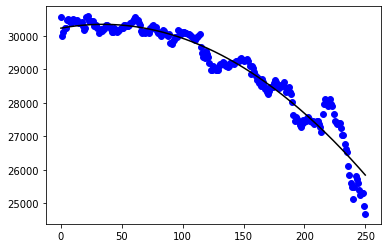



2022-06-13T08:30:00, Close, 24121.82
2022-08-21 16:49:48:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 26063.59
- Closed: -3.989609972765011
- Opened: 0
- Adjbase: 25366.99
--- Position End
Open Orders: 
2022-06-13T08:30:00, predict, and max, min 25838.94,  26556.26,25121.61,
Portfolio 102495.3850828727 the other one 102495.3850828727
2022-08-21 16:49:48:  Finding the best model and optimizing time...
2022-08-21 16:49:53:  FInished computing all models... Finding and returning best model
2022-08-21 16:49:53:  Remodeling inaccurate model...
current model value 25751.095850179616 predicted model next value 25708.20003080726


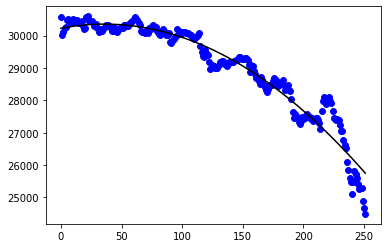



2022-06-13T09:00:00, Close, 24237.70
2022-08-21 16:49:54:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 26063.59
- Closed: -3.989609972765011
- Opened: 0
- Adjbase: 25366.99
--- Position End
Open Orders: 
2022-06-13T09:00:00, predict, and max, min 25751.10,  26492.53,25009.66,
Portfolio 102495.3850828727 the other one 102495.3850828727
2022-08-21 16:49:54:  Finding the best model and optimizing time...
2022-08-21 16:49:59:  FInished computing all models... Finding and returning best model
2022-08-21 16:49:59:  Remodeling inaccurate model...
current model value 25655.163864621532 predicted model next value 25611.226047160704


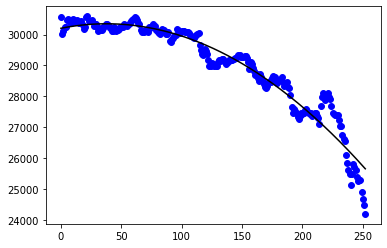



2022-06-13T09:30:00, Close, 23966.66
2022-08-21 16:50:00:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 26063.59
- Closed: -3.989609972765011
- Opened: 0
- Adjbase: 25366.99
--- Position End
Open Orders: 
2022-06-13T09:30:00, predict, and max, min 25655.16,  26429.48,24880.85,
Portfolio 102495.3850828727 the other one 102495.3850828727
2022-08-21 16:50:00:  Finding the best model and optimizing time...
2022-08-21 16:50:05:  FInished computing all models... Finding and returning best model
2022-08-21 16:50:05:  Remodeling inaccurate model...
current model value 25546.975040582467 predicted model next value 25501.738786517057


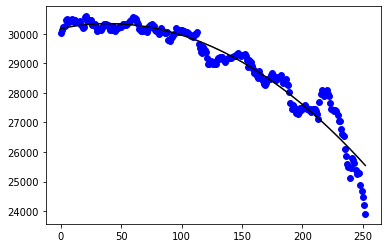



2022-06-13T10:00:00, Close, 24153.14
2022-08-21 16:50:05:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 26063.59
- Closed: -3.989609972765011
- Opened: 0
- Adjbase: 25366.99
--- Position End
Open Orders: 
2022-06-13T10:00:00, predict, and max, min 25546.98,  26363.49,24730.46,
Portfolio 102495.3850828727 the other one 102495.3850828727
2022-08-21 16:50:05:  Finding the best model and optimizing time...
2022-08-21 16:50:11:  FInished computing all models... Finding and returning best model
2022-08-21 16:50:11:  Remodeling inaccurate model...
current model value 25448.380954107415 predicted model next value 25402.087730848856


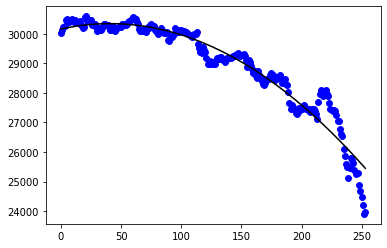



2022-06-13T10:30:00, Close, 23930.72
2022-08-21 16:50:11:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 26063.59
- Closed: -3.989609972765011
- Opened: 0
- Adjbase: 25366.99
--- Position End
Open Orders: 
2022-06-13T10:30:00, predict, and max, min 25448.38,  26293.87,24602.89,
Portfolio 102495.3850828727 the other one 102495.3850828727
2022-08-21 16:50:11:  Finding the best model and optimizing time...
2022-08-21 16:50:16:  FInished computing all models... Finding and returning best model
2022-08-21 16:50:16:  Remodeling inaccurate model...
current model value 25355.772027229952 predicted model next value 25308.530672726927


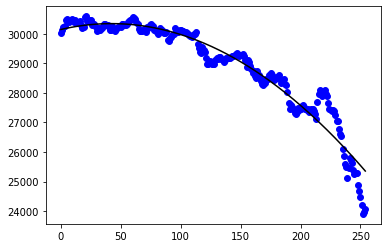



2022-06-13T11:00:00, Close, 23545.05
2022-08-21 16:50:16:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 26063.59
- Closed: -3.989609972765011
- Opened: 0
- Adjbase: 25366.99
--- Position End
Open Orders: 
2022-06-13T11:00:00, predict, and max, min 25355.77,  26219.52,24492.02,
Portfolio 102495.3850828727 the other one 102495.3850828727
2022-08-21 16:50:16:  Finding the best model and optimizing time...
2022-08-21 16:50:22:  FInished computing all models... Finding and returning best model
2022-08-21 16:50:22:  Remodeling inaccurate model...
current model value 25252.85997828791 predicted model next value 25204.521658543727


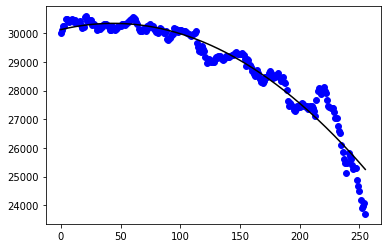



2022-06-13T11:30:00, Close, 23677.00
2022-08-21 16:50:22:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 26063.59
- Closed: -3.989609972765011
- Opened: 0
- Adjbase: 25366.99
--- Position End
Open Orders: 
2022-06-13T11:30:00, predict, and max, min 25252.86,  26146.37,24359.35,
Portfolio 102495.3850828727 the other one 102495.3850828727
2022-08-21 16:50:22:  Finding the best model and optimizing time...
2022-08-21 16:50:27:  FInished computing all models... Finding and returning best model
2022-08-21 16:50:27:  Remodeling inaccurate model...
current model value 25148.234385449276 predicted model next value 25098.78718869767


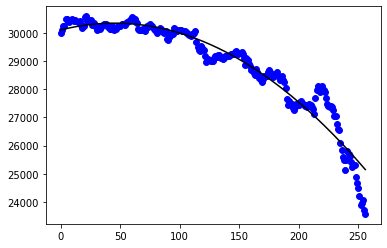



2022-06-13T12:00:00, Close, 24125.66
2022-08-21 16:50:28:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 26063.59
- Closed: -3.989609972765011
- Opened: 0
- Adjbase: 25366.99
--- Position End
Open Orders: 
2022-06-13T12:00:00, predict, and max, min 25148.23,  26071.68,24224.79,
Portfolio 102495.3850828727 the other one 102495.3850828727
2022-08-21 16:50:28:  Finding the best model and optimizing time...
2022-08-21 16:50:33:  FInished computing all models... Finding and returning best model
2022-08-21 16:50:33:  Remodeling inaccurate model...
current model value 25059.24366553355 predicted model next value 25008.946256332896


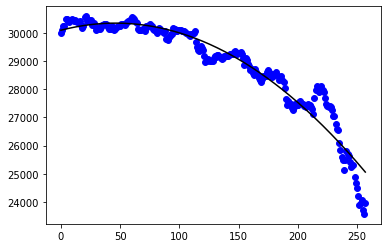



2022-06-13T12:30:00, Close, 23642.66
2022-08-21 16:50:34:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 26063.59
- Closed: -3.989609972765011
- Opened: 0
- Adjbase: 25366.99
--- Position End
Open Orders: 
2022-06-13T12:30:00, predict, and max, min 25059.24,  25993.05,24125.44,
Portfolio 102495.3850828727 the other one 102495.3850828727
2022-08-21 16:50:34:  Finding the best model and optimizing time...
2022-08-21 16:50:39:  FInished computing all models... Finding and returning best model
2022-08-21 16:50:39:  Remodeling inaccurate model...
current model value 24972.500492130883 predicted model next value 24921.399374847202


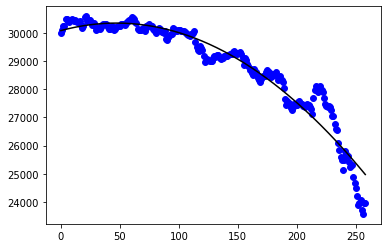



2022-06-13T13:00:00, Close, 23381.62
2022-08-21 16:50:40:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 26063.59
- Closed: -3.989609972765011
- Opened: 0
- Adjbase: 25366.99
--- Position End
Open Orders: 
2022-06-13T13:00:00, predict, and max, min 24972.50,  25913.38,24031.62,
Portfolio 102495.3850828727 the other one 102495.3850828727
2022-08-21 16:50:40:  Finding the best model and optimizing time...
2022-08-21 16:50:45:  FInished computing all models... Finding and returning best model
2022-08-21 16:50:45:  Remodeling inaccurate model...
current model value 24873.118632020247 predicted model next value 24821.02934566338


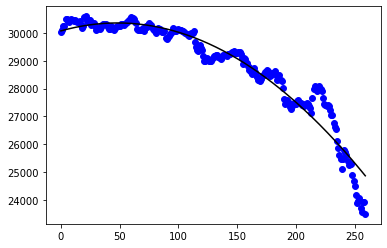



2022-06-13T13:30:00, Close, 23610.24
2022-08-21 16:50:45:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 26063.59
- Closed: -3.989609972765011
- Opened: 0
- Adjbase: 25366.99
--- Position End
Open Orders: 
2022-06-13T13:30:00, predict, and max, min 24873.12,  25831.74,23914.50,
Portfolio 102495.3850828727 the other one 102495.3850828727
2022-08-21 16:50:45:  Finding the best model and optimizing time...
2022-08-21 16:50:51:  FInished computing all models... Finding and returning best model
2022-08-21 16:50:51:  Remodeling inaccurate model...
current model value 24780.13587324938 predicted model next value 24727.17030753118


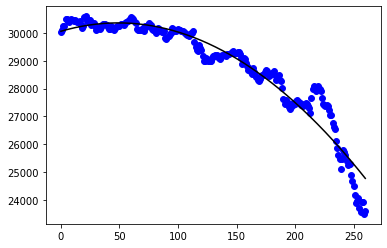



2022-06-13T14:00:00, Close, 23387.46
2022-08-21 16:50:51:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 26063.59
- Closed: -3.989609972765011
- Opened: 0
- Adjbase: 25366.99
--- Position End
Open Orders: 
2022-06-13T14:00:00, predict, and max, min 24780.14,  25748.59,23811.68,
Portfolio 102495.3850828727 the other one 102495.3850828727
2022-08-21 16:50:51:  Finding the best model and optimizing time...
2022-08-21 16:50:56:  FInished computing all models... Finding and returning best model
2022-08-21 16:50:56:  Remodeling inaccurate model...
current model value 24681.217945760887 predicted model next value 24627.29687105512


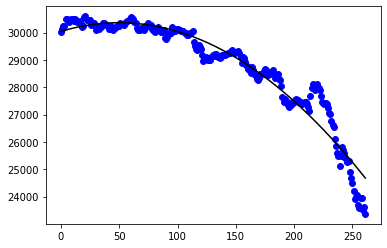



2022-06-13T14:30:00, Close, 22766.58
2022-08-21 16:50:56:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 26063.59
- Closed: -3.989609972765011
- Opened: 0
- Adjbase: 25366.99
--- Position End
Open Orders: 
2022-06-13T14:30:00, predict, and max, min 24681.22,  25663.78,23698.65,
Portfolio 102495.3850828727 the other one 102495.3850828727
2022-08-21 16:50:56:  Finding the best model and optimizing time...
2022-08-21 16:51:01:  FInished computing all models... Finding and returning best model
2022-08-21 16:51:01:  Remodeling inaccurate model...
current model value 24570.652861058752 predicted model next value 24515.61105558461


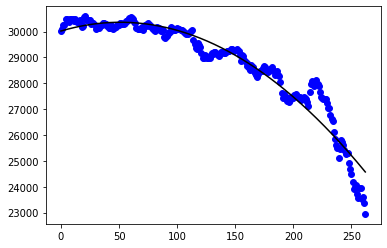



2022-06-13T15:00:00, Close, 22901.87
2022-08-21 16:51:02:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 26063.59
- Closed: -3.989609972765011
- Opened: 0
- Adjbase: 25366.99
--- Position End
Open Orders: 
2022-06-13T15:00:00, predict, and max, min 24570.65,  25578.03,23563.28,
Portfolio 102495.3850828727 the other one 102495.3850828727
2022-08-21 16:51:02:  Finding the best model and optimizing time...
2022-08-21 16:51:07:  FInished computing all models... Finding and returning best model
2022-08-21 16:51:07:  Remodeling inaccurate model...
current model value 24460.886952097037 predicted model next value 24404.75146867616


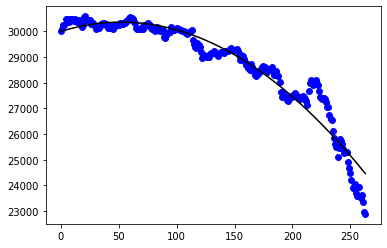



2022-06-13T15:30:00, Close, 23260.01
2022-08-21 16:51:07:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 26063.59
- Closed: -3.989609972765011
- Opened: 0
- Adjbase: 25366.99
--- Position End
Open Orders: 
2022-06-13T15:30:00, predict, and max, min 24460.89,  25490.04,23431.74,
Portfolio 102495.3850828727 the other one 102495.3850828727
2022-08-21 16:51:07:  Finding the best model and optimizing time...
2022-08-21 16:51:12:  FInished computing all models... Finding and returning best model
2022-08-21 16:51:12:  Remodeling inaccurate model...
current model value 24364.103430342384 predicted model next value 24307.085715032157


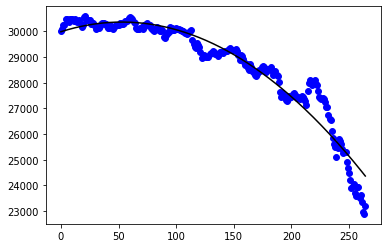



2022-06-13T16:00:00, Close, 23885.76
2022-08-21 16:51:13:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 26063.59
- Closed: -3.989609972765011
- Opened: 0
- Adjbase: 25366.99
--- Position End
Open Orders: 
2022-06-13T16:00:00, predict, and max, min 24364.10,  25400.83,23327.38,
Portfolio 102495.3850828727 the other one 102495.3850828727
2022-08-21 16:51:13:  In Downtrend
2022-06-13: Limit Order / Buy at 23845.67141103296
2022-06-13: Limit Order / Sell at 24757.58745415167
current model value 24307.085715032157 predicted model next value 24249.79854259787


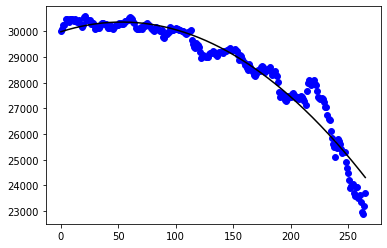

Limit ordering
2022-06-13T16:30:00, BUY EXECUTED, Price: 23845.67, Costed Total Of: 101470.43, Comm 0.00
2022-06-13T16:30:00, Order Canceled


2022-06-13T16:30:00, Close, 23700.63
2022-08-21 16:51:13:  --- Position Begin
- Size: 4.25529772187901
- Price: 23845.67141103296
- Price orig: 0.0
- Closed: 0
- Opened: 4.25529772187901
- Adjbase: 23700.63
--- Position End
Open Orders: 
2022-06-13T16:30:00, predict, and max, min 24307.09,  25343.28,23270.90,
Portfolio 101878.19069692603 the other one 1024.9538508287224
2022-08-21 16:51:13:  In Downtrend
2022-06-13: Limit Order / Buy at 23788.527747525728
2022-06-13: Limit Order / Sell at 24700.160166812715
current model value 24249.79854259787 predicted model next value 24192.241913039514


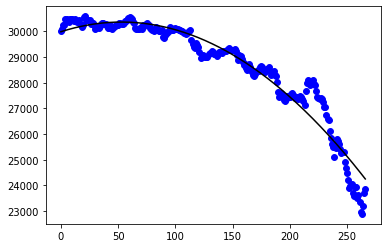

Limit ordering
2022-06-13T17:00:00, BUY EXECUTED, Price: 23706.65, Costed Total Of: 6.15, Comm 0.00
2022-06-13T17:00:00, Order Canceled


2022-06-13T17:00:00, Close, 23253.30
2022-08-21 16:51:13:  --- Position Begin
- Size: 4.255557172313478
- Price: 23845.662935253167
- Price orig: 23845.67141103296
- Closed: 0
- Opened: 0.0002594504344683998
- Adjbase: 23253.3
--- Position End
Open Orders: 
2022-06-13T17:00:00, predict, and max, min 24249.80,  25284.15,23215.45,
Portfolio 99974.55074514342 the other one 1018.803150186432
2022-08-21 16:51:13:  In Downtrend
2022-06-13: Limit Order / Buy at 23731.462691416866
2022-06-13: Limit Order / Sell at 24642.123589641156
current model value 24192.241913039514 predicted model next value 24134.415826357093


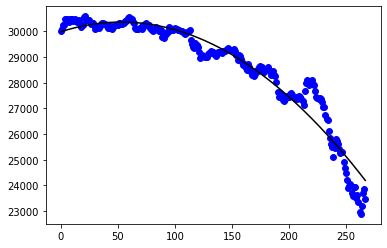

Limit ordering
2022-06-13T17:30:00, BUY EXECUTED, Price: 23251.07, Costed Total Of: 18.67, Comm 0.00
2022-06-13T17:30:00, Order Canceled


2022-06-13T17:30:00, Close, 23512.59
2022-08-21 16:51:13:  --- Position Begin
- Size: 4.256360226174203
- Price: 23845.55075251326
- Price orig: 23845.662935253167
- Closed: 0
- Opened: 0.0008030538607253722
- Adjbase: 23512.59
--- Position End
Open Orders: 
2022-06-13T17:30:00, predict, and max, min 24192.24,  25227.37,23157.11,
Portfolio 101078.18417899824 the other one 1000.1312886569361
2022-08-21 16:51:13:  In Downtrend
2022-06-13: Limit Order / Buy at 23673.428055123477
2022-06-13: Limit Order / Sell at 24582.64797490772
current model value 24134.415826357093 predicted model next value 24076.320282550612


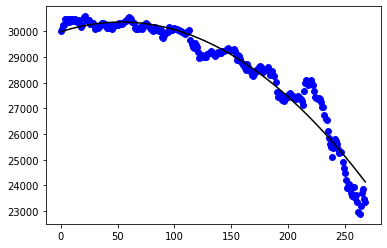

Limit ordering
2022-06-13T18:00:00, SELL EXECUTED, Price: 23673.43, Costed Total Of: 10.73, Comm 0.00
2022-06-13T18:00:00, Order Canceled


2022-06-13T18:00:00, Close, 23622.66
2022-08-21 16:51:13:  --- Position Begin
- Size: 4.255910331333952
- Price: 23845.55075251326
- Price orig: 23845.55075251326
- Closed: -0.0004498948402507606
- Opened: 0
- Adjbase: 23622.66
--- Position End
Open Orders: 
2022-06-13T18:00:00, predict, and max, min 24134.42,  25170.97,23097.86,
Portfolio 101546.70458937928 the other one 1010.7818417899838
2022-08-21 16:51:13:  In Downtrend
2022-06-13: Limit Order / Buy at 23614.952912833884
2022-06-13: Limit Order / Sell at 24524.921526019345
current model value 24076.320282550612 predicted model next value 24017.95528162007


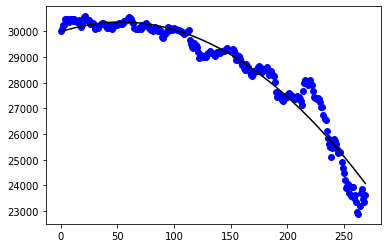

Limit ordering
2022-06-13T18:30:00, SELL EXECUTED, Price: 23620.60, Costed Total Of: 4.73, Comm 0.00
2022-06-13T18:30:00, Order Canceled


2022-06-13T18:30:00, Close, 23342.35
2022-08-21 16:51:13:  --- Position Begin
- Size: 4.255711931442108
- Price: 23845.55075251326
- Price orig: 23845.55075251326
- Closed: -0.0001983998918439975
- Opened: 0
- Adjbase: 23342.35
--- Position End
Open Orders: 
2022-06-13T18:30:00, predict, and max, min 24076.32,  25111.28,23041.36,
Portfolio 100353.78556917296 the other one 1015.4681662752741
2022-08-21 16:51:13:  In Downtrend
2022-06-13: Limit Order / Buy at 23556.270792720887
2022-06-13: Limit Order / Sell at 24466.144208175094
current model value 24017.95528162007 predicted model next value 23959.32082356546


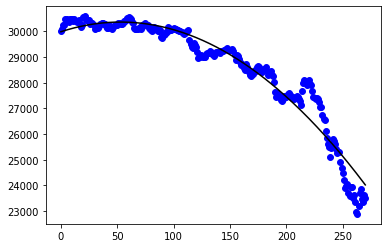

Limit ordering
2022-06-13T19:00:00, BUY EXECUTED, Price: 23342.43, Costed Total Of: 11.82, Comm 0.00
2022-06-13T19:00:00, Order Canceled


2022-06-13T19:00:00, Close, 23128.76
2022-08-21 16:51:13:  --- Position Begin
- Size: 4.256218391513336
- Price: 23845.49088468019
- Price orig: 23845.55075251326
- Closed: 0
- Opened: 0.0005064600712277866
- Adjbase: 23128.76
--- Position End
Open Orders: 
2022-06-13T19:00:00, predict, and max, min 24017.96,  25051.52,22984.39,
Portfolio 99444.69984241283 the other one 1003.6461575148445
2022-08-21 16:51:13:  In Downtrend
2022-06-13: Limit Order / Buy at 23498.009704171713
2022-06-13: Limit Order / Sell at 24405.62087145581
current model value 23959.32082356546 predicted model next value 23900.41690838679


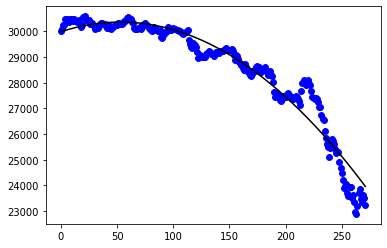

Limit ordering
2022-06-13T19:30:00, BUY EXECUTED, Price: 23127.63, Costed Total Of: 9.05, Comm 0.00
2022-06-13T19:30:00, Order Canceled


2022-06-13T19:30:00, Close, 23144.28
2022-08-21 16:51:13:  --- Position Begin
- Size: 4.256609878248022
- Price: 23845.42486194808
- Price orig: 23845.49088468019
- Closed: 0
- Opened: 0.00039148673468628335
- Adjbase: 23144.28
--- Position End
Open Orders: 
2022-06-13T19:30:00, predict, and max, min 23959.32,  24993.55,22925.10,
Portfolio 99510.76287010324 the other one 994.5919971651119
2022-08-21 16:51:13:  In Downtrend
2022-06-13: Limit Order / Buy at 23438.930342988184
2022-06-13: Limit Order / Sell at 24346.88669326608
current model value 23900.41690838679 predicted model next value 23841.243536084054


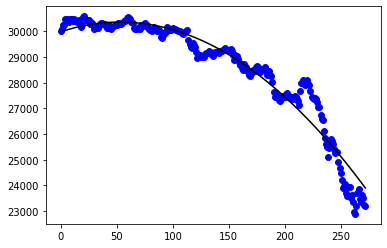

Limit ordering
2022-06-13T20:00:00, SELL EXECUTED, Price: 23438.93, Costed Total Of: 0.52, Comm 0.00
2022-06-13T20:00:00, Order Canceled


2022-06-13T20:00:00, Close, 23574.37
2022-08-21 16:51:13:  --- Position Begin
- Size: 4.256587879311707
- Price: 23845.42486194808
- Price orig: 23845.42486194808
- Closed: -2.199893631554811e-05
- Opened: 0
- Adjbase: 23574.37
--- Position End
Open Orders: 
2022-06-13T20:00:00, predict, and max, min 23900.42,  24934.85,22865.99,
Portfolio 101341.48523311055 the other one 995.1076287010319
2022-08-21 16:51:13:  In Downtrend
2022-06-13: Limit Order / Buy at 23379.70142105353
2022-06-13: Limit Order / Sell at 24287.767063009313
current model value 23841.243536084054 predicted model next value 23781.800706657254


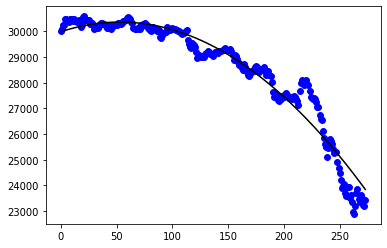

Limit ordering
2022-06-13T20:30:00, SELL EXECUTED, Price: 23572.23, Costed Total Of: 18.67, Comm 0.00
2022-06-13T20:30:00, Order Canceled


2022-06-13T20:30:00, Close, 23202.36
2022-08-21 16:51:14:  --- Position Begin
- Size: 4.2558048400717965
- Price: 23845.42486194808
- Price orig: 23845.42486194808
- Closed: -0.0007830392399100205
- Opened: 0
- Adjbase: 23202.36
--- Position End
Open Orders: 
2022-06-13T20:30:00, predict, and max, min 23841.24,  24873.90,22808.59,
Portfolio 99758.28159885146 the other one 1013.5656097632161
2022-08-21 16:51:14:  In Downtrend
2022-06-13: Limit Order / Buy at 23320.955870957365
2022-06-13: Limit Order / Sell at 24227.86407978288
current model value 23781.800706657254 predicted model next value 23722.08842010639


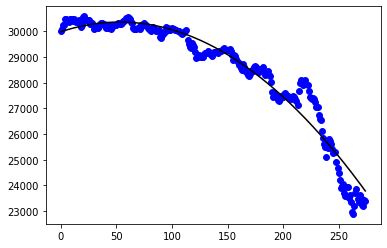

Limit ordering
2022-06-13T21:00:00, BUY EXECUTED, Price: 23205.20, Costed Total Of: 15.90, Comm 0.00
2022-06-13T21:00:00, Order Canceled


2022-06-13T21:00:00, Close, 23180.30
2022-08-21 16:51:14:  --- Position Begin
- Size: 4.256490180495368
- Price: 23845.321778900907
- Price orig: 23845.42486194808
- Closed: 0
- Opened: 0.0006853404235718855
- Adjbase: 23180.3
--- Position End
Open Orders: 
2022-06-13T21:00:00, predict, and max, min 23781.80,  24812.61,22750.99,
Portfolio 99664.38147910293 the other one 997.6621481661458
2022-08-21 16:51:14:  In Downtrend
2022-06-13: Limit Order / Buy at 23261.73806392181
2022-06-13: Limit Order / Sell at 24166.017948115106
current model value 23722.08842010639 predicted model next value 23662.106676431467


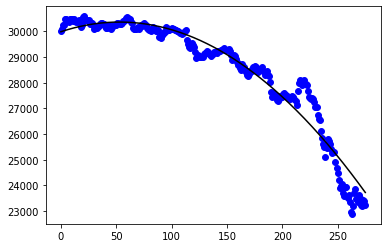

Limit ordering
2022-06-13T21:30:00, BUY EXECUTED, Price: 23180.33, Costed Total Of: 1.01, Comm 0.00
2022-06-13T21:30:00, Order Canceled


2022-06-13T21:30:00, Close, 23036.44
2022-08-21 16:51:14:  --- Position Begin
- Size: 4.256533957678841
- Price: 23845.314939658598
- Price orig: 23845.321778900907
- Closed: 0
- Opened: 4.377718347274559e-05
- Adjbase: 23036.44
--- Position End
Open Orders: 
2022-06-13T21:30:00, predict, and max, min 23722.09,  24751.42,22692.75,
Portfolio 99052.03650263794 the other one 996.647378606777
2022-08-21 16:51:14:  In Downtrend
2022-06-13: Limit Order / Buy at 23202.151939253872
2022-06-13: Limit Order / Sell at 24105.654697275735
current model value 23662.106676431467 predicted model next value 23601.855475632477


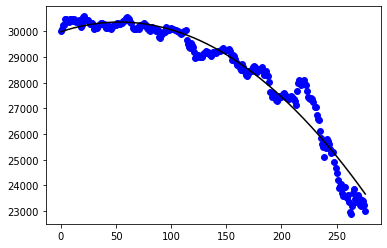

Limit ordering
2022-06-13T22:00:00, BUY EXECUTED, Price: 23036.44, Costed Total Of: 6.08, Comm 0.00
2022-06-13T22:00:00, Order Canceled


2022-06-13T22:00:00, Close, 22872.78
2022-08-21 16:51:14:  --- Position Begin
- Size: 4.256798028597626
- Price: 23845.26476101562
- Price orig: 23845.314939658598
- Closed: 0
- Opened: 0.00026407091878523516
- Adjbase: 22872.78
--- Position End
Open Orders: 
2022-06-13T22:00:00, predict, and max, min 23662.11,  24691.22,22633.00,
Portfolio 98355.36893727764 the other one 990.5641247304361
2022-08-21 16:51:14:  In Downtrend
2022-06-13: Limit Order / Buy at 23141.960641432222
2022-06-13: Limit Order / Sell at 24045.345730255645
current model value 23601.855475632477 predicted model next value 23541.334817709423


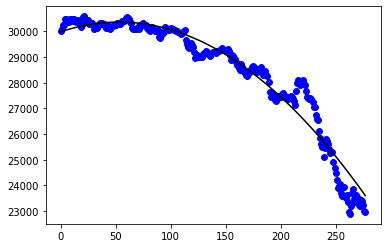

Limit ordering
2022-06-13T22:30:00, BUY EXECUTED, Price: 22878.41, Costed Total Of: 6.93, Comm 0.00
2022-06-13T22:30:00, Order Canceled


2022-06-13T22:30:00, Close, 22564.22
2022-08-21 16:51:14:  --- Position Begin
- Size: 4.257100960378829
- Price: 23845.19596043099
- Price orig: 23845.26476101562
- Closed: 0
- Opened: 0.00030293178120332056
- Adjbase: 22564.22
--- Position End
Open Orders: 
2022-06-13T22:30:00, predict, and max, min 23601.86,  24630.71,22573.00,
Portfolio 97041.79615943723 the other one 983.6335272380362
2022-08-21 16:51:14:  Finding the best model and optimizing time...
2022-08-21 16:51:21:  FInished computing all models... Finding and returning best model
2022-08-21 16:51:21:  Remodeling inaccurate model...
2022-08-21 16:51:21:  Close all long positions here
current model value 23169.68138914568 predicted model next value 23101.500091722097


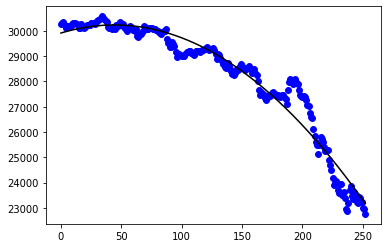

2022-06-13T23:00:00, SELL EXECUTED, Price: 22564.22, Costed Total Of: 101511.41, Comm 0.00
2022-06-13T23:00:00, OPERATION PROFIT, GROSS -5453.59, NET -5453.59


2022-06-13T23:00:00, Close, 22139.26
2022-08-21 16:51:22:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 23845.19596043099
- Closed: -4.257100960378829
- Opened: 0
- Adjbase: 22564.22
--- Position End
Open Orders: 
2022-06-13T23:00:00, predict, and max, min 23169.68,  24181.07,22158.29,
Portfolio 97041.79615943723 the other one 97041.79615943723
2022-08-21 16:51:22:  Finding the best model and optimizing time...
2022-08-21 16:51:27:  FInished computing all models... Finding and returning best model
2022-08-21 16:51:27:  Remodeling inaccurate model...
current model value 23073.852324657368 predicted model next value 23004.905976068483


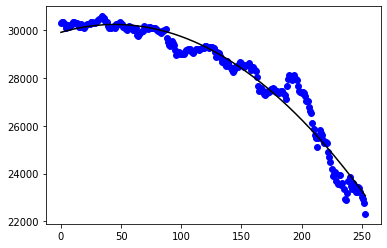



2022-06-13T23:30:00, Close, 22460.97
2022-08-21 16:51:27:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 23845.19596043099
- Closed: -4.257100960378829
- Opened: 0
- Adjbase: 22564.22
--- Position End
Open Orders: 
2022-06-13T23:30:00, predict, and max, min 23073.85,  24087.21,22060.50,
Portfolio 97041.79615943723 the other one 97041.79615943723
2022-08-21 16:51:27:  In Downtrend
2022-06-13: Limit Order / Buy at 22559.94932438422
2022-06-13: Limit Order / Sell at 23448.84510608825
current model value 23004.905976068483 predicted model next value 22935.629396063137


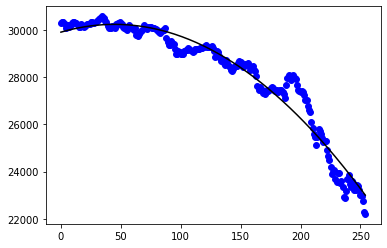

Limit ordering
2022-06-14T00:00:00, BUY EXECUTED, Price: 22460.97, Costed Total Of: 95649.88, Comm 0.00
2022-06-14T00:00:00, Order Canceled


2022-06-14T00:00:00, Close, 22282.73
2022-08-21 16:51:27:  --- Position Begin
- Size: 4.258492641825345
- Price: 22460.97
- Price orig: 0.0
- Closed: 0
- Opened: 4.258492641825345
- Adjbase: 22282.73
--- Position End
Open Orders: 
2022-06-14T00:00:00, predict, and max, min 23004.91,  24019.99,21989.82,
Portfolio 96282.76243095828 the other one 1391.9206861774
2022-08-21 16:51:27:  In Downtrend
2022-06-14: Limit Order / Buy at 22490.217020625107
2022-06-14: Limit Order / Sell at 23380.023207692924
current model value 22935.629396063137 predicted model next value 22866.02258464133


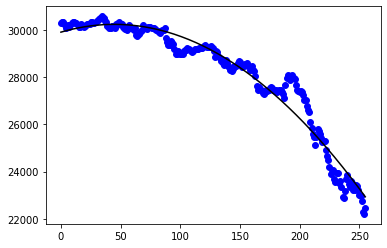

Limit ordering
2022-06-14T00:30:00, BUY EXECUTED, Price: 22282.72, Costed Total Of: 425.13, Comm 0.00
2022-06-14T00:30:00, Order Canceled


2022-06-14T00:30:00, Close, 21731.13
2022-08-21 16:51:27:  --- Position Begin
- Size: 4.2775717401494875
- Price: 22460.17495798017
- Price orig: 22460.97
- Closed: 0
- Opened: 0.01907909832414253
- Adjbase: 21731.13
--- Position End
Open Orders: 
2022-06-14T00:30:00, predict, and max, min 22935.63,  23949.04,21922.22,
Portfolio 93923.25404988279 the other one 966.7864803680627
2022-08-21 16:51:27:  Finding the best model and optimizing time...
2022-08-21 16:51:32:  FInished computing all models... Finding and returning best model
2022-08-21 16:51:32:  Remodeling inaccurate model...
2022-08-21 16:51:32:  Close all long positions here
current model value 22798.56267135651 predicted model next value 22727.576037574057


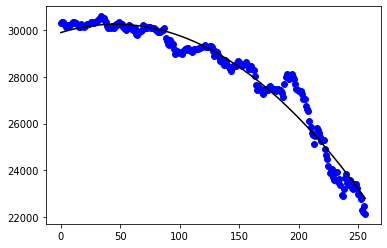

2022-06-14T01:00:00, SELL EXECUTED, Price: 21731.13, Costed Total Of: 96075.01, Comm 0.00
2022-06-14T01:00:00, OPERATION PROFIT, GROSS -3118.54, NET -3118.54


2022-06-14T01:00:00, Close, 21144.51
2022-08-21 16:51:32:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 22460.17495798017
- Closed: -4.2775717401494875
- Opened: 0
- Adjbase: 21731.13
--- Position End
Open Orders: 
2022-06-14T01:00:00, predict, and max, min 22798.56,  23812.20,21784.93,
Portfolio 93923.25404988279 the other one 93923.25404988279
2022-08-21 16:51:32:  Finding the best model and optimizing time...
2022-08-21 16:51:38:  FInished computing all models... Finding and returning best model
2022-08-21 16:51:38:  Remodeling inaccurate model...
current model value 22039.29792668014 predicted model next value 21940.97884070602


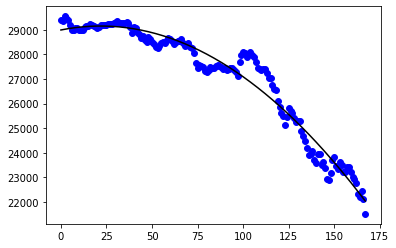



2022-06-14T01:30:00, Close, 20830.53
2022-08-21 16:51:38:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 22460.17495798017
- Closed: -4.2775717401494875
- Opened: 0
- Adjbase: 21731.13
--- Position End
Open Orders: 
2022-06-14T01:30:00, predict, and max, min 22039.30,  22958.28,21120.31,
Portfolio 93923.25404988279 the other one 93923.25404988279
2022-08-21 16:51:38:  Finding the best model and optimizing time...
2022-08-21 16:51:43:  FInished computing all models... Finding and returning best model
2022-08-21 16:51:43:  Remodeling inaccurate model...
current model value 21896.22615255764 predicted model next value 21796.164602452838


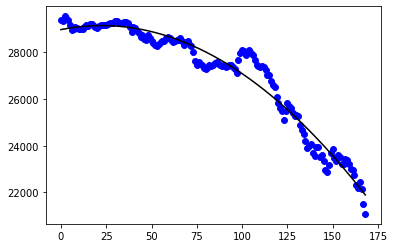



2022-06-14T02:00:00, Close, 21088.59
2022-08-21 16:51:44:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 22460.17495798017
- Closed: -4.2775717401494875
- Opened: 0
- Adjbase: 21731.13
--- Position End
Open Orders: 
2022-06-14T02:00:00, predict, and max, min 21896.23,  22814.42,20978.03,
Portfolio 93923.25404988279 the other one 93923.25404988279
2022-08-21 16:51:44:  In Downtrend
2022-06-14: Limit Order / Buy at 21389.45787480093
2022-06-14: Limit Order / Sell at 22195.254678843085
current model value 21796.164602452838 predicted model next value 21695.417696960874


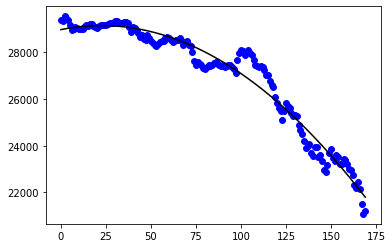

Limit ordering
2022-06-14T02:30:00, BUY EXECUTED, Price: 21091.35, Costed Total Of: 91688.09, Comm 0.00
2022-06-14T02:30:00, Order Canceled


2022-06-14T02:30:00, Close, 21509.13
2022-08-21 16:51:44:  --- Position Begin
- Size: 4.347189258075077
- Price: 21091.35
- Price orig: 0.0
- Closed: 0
- Opened: 4.347189258075077
- Adjbase: 21509.13
--- Position End
Open Orders: 
2022-06-14T02:30:00, predict, and max, min 21796.16,  22713.52,20878.81,
Portfolio 95739.4227781214 the other one 2235.163891581018
2022-08-21 16:51:44:  In Downtrend
2022-06-14: Limit Order / Buy at 21285.579405310298
2022-06-14: Limit Order / Sell at 22094.290183769477
current model value 21695.417696960874 predicted model next value 21593.985436081733


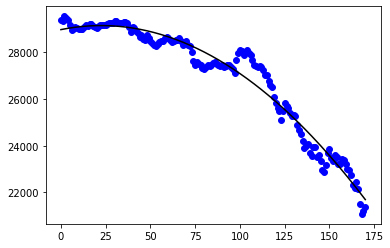



2022-06-14T03:00:00, Close, 21885.69
2022-08-21 16:51:44:  --- Position Begin
- Size: 4.347189258075077
- Price: 21091.35
- Price orig: 0.0
- Closed: 0
- Opened: 4.347189258075077
- Adjbase: 21885.69
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        8.521943265468478
-----Order price:        22094.290183769477
-----Order Type:        2
-----Trail Amount:        None
-----Trail Percent:        None
-----Created Price:        22094.290183769477
-----Is Buy:        False
-----Asset:             BTCUSD
-----Order Size:        0.06002982768141257
-----Order price:        21285.579405310298
-----Order Type:        2
-----Trail Amount:        None
-----Trail Percent:        None
-----Created Price:        21285.579405310298
-----Is Buy:        True
2022-06-14T03:00:00, predict, and max, min 21695.42,  22610.09,20780.74,
Portfolio 97376.40036514215 the other one 2235.163891581018
2022-08-21 16:51:44:  In Downtrend
2022-06-14: Limit Order / Buy at 21184.866

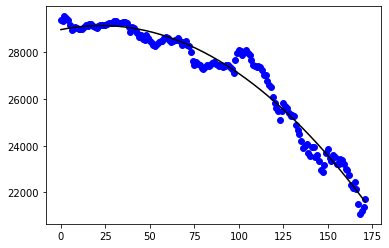

2022-06-14T03:30:00, ORDER EXPIRED
2022-06-14T03:30:00, Order Canceled
Limit ordering
2022-06-14T03:30:00, SELL EXECUTED, Price: 21992.16, Costed Total Of: 187627.89, Comm 0.00
2022-06-14T03:30:00, Order Canceled
2022-06-14T03:30:00, OPERATION PROFIT, GROSS 3915.98, NET 3915.98


2022-06-14T03:30:00, Close, 22089.86
2022-08-21 16:51:44:  --- Position Begin
- Size: -4.362455214805622
- Price: 21992.15747915587
- Price orig: 21091.35
- Closed: -4.347189258075077
- Opened: -4.362455214805622
- Adjbase: 22089.86
--- Position End
Open Orders: 
2022-06-14T03:30:00, predict, and max, min 21593.99,  22507.56,20680.41,
Portfolio 97413.01177530675 the other one 1899.4325670928956
2022-08-21 16:51:44:  In Downtrend
sell value 21889.751226884262
current model value 21491.86781981543 predicted model next value 21389.064848161957


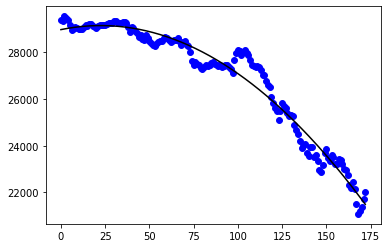



2022-06-14T04:00:00, Close, 21879.25
2022-08-21 16:51:44:  --- Position Begin
- Size: -4.362455214805622
- Price: 21992.15747915587
- Price orig: 21091.35
- Closed: -4.347189258075077
- Opened: -4.362455214805622
- Adjbase: 21879.25
--- Position End
Open Orders: 
2022-06-14T04:00:00, predict, and max, min 21491.87,  22403.74,20580.00,
Portfolio 98331.78846809697 the other one 1899.4325670928956
2022-08-21 16:51:44:  In Downtrend
sell value 21786.503342016626
current model value 21389.064848161957 predicted model next value 21285.576521121315


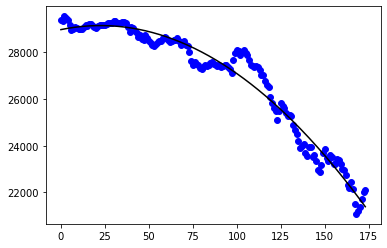



2022-06-14T04:30:00, Close, 21933.74
2022-08-21 16:51:44:  --- Position Begin
- Size: -4.362455214805622
- Price: 21992.15747915587
- Price orig: 21091.35
- Closed: -4.347189258075077
- Opened: -4.362455214805622
- Adjbase: 21933.74
--- Position End
Open Orders: 
2022-06-14T04:30:00, predict, and max, min 21389.06,  22302.25,20475.88,
Portfolio 98094.0782834422 the other one 1899.4325670928956
2022-08-21 16:51:44:  In Downtrend
sell value 21683.360187485207
current model value 21285.576521121315 predicted model next value 21181.402838693502


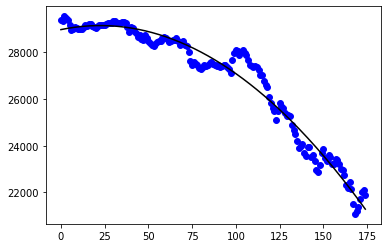



2022-06-14T05:00:00, Close, 22848.42
2022-08-21 16:51:44:  --- Position Begin
- Size: -4.362455214805622
- Price: 21992.15747915587
- Price orig: 21091.35
- Closed: -4.347189258075077
- Opened: -4.362455214805622
- Adjbase: 22848.42
--- Position End
Open Orders: 
2022-06-14T05:00:00, predict, and max, min 21285.58,  22198.19,20372.96,
Portfolio 94103.82774756382 the other one 1899.4325670928956
2022-08-21 16:51:44:  Finding the best model and optimizing time...
2022-08-21 16:51:49:  FInished computing all models... Finding and returning best model
2022-08-21 16:51:49:  Remodeling inaccurate model...
2022-08-21 16:51:50:  Close all short positions here
current model value 21314.95617806449 predicted model next value 21213.355186148936


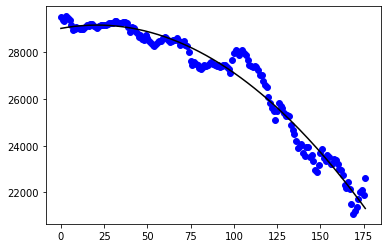

2022-06-14T05:30:00, BUY EXECUTED, Price: 22848.42, Costed Total Of: 95939.80, Comm 0.00
2022-06-14T05:30:00, OPERATION PROFIT, GROSS -3735.41, NET -3735.41


2022-06-14T05:30:00, Close, 22723.11
2022-08-21 16:51:50:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 21992.15747915587
- Closed: 4.362455214805622
- Opened: 0
- Adjbase: 22848.42
--- Position End
Open Orders: 
2022-06-14T05:30:00, predict, and max, min 21314.96,  22265.79,20364.12,
Portfolio 94103.82774756382 the other one 94103.82774756382
2022-08-21 16:51:50:  Finding the best model and optimizing time...
2022-08-21 16:51:55:  FInished computing all models... Finding and returning best model
2022-08-21 16:51:55:  Remodeling inaccurate model...
current model value 21890.746974676375 predicted model next value 21813.497450705396


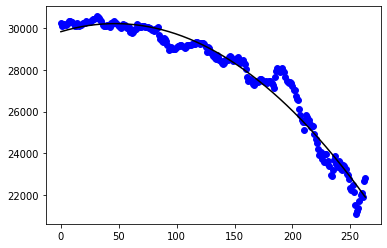



2022-06-14T06:00:00, Close, 22477.56
2022-08-21 16:51:55:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 21992.15747915587
- Closed: 4.362455214805622
- Opened: 0
- Adjbase: 22848.42
--- Position End
Open Orders: 
2022-06-14T06:00:00, predict, and max, min 21890.75,  22941.08,20840.41,
Portfolio 94103.82774756382 the other one 94103.82774756382
2022-08-21 16:51:55:  In Downtrend
sell value 22269.25183808075
2022-06-14T06:00:00, SELL CREATE, 22477.56 and now rebalancing portfolio
current model value 21813.497450705396 predicted model next value 21735.891639186535


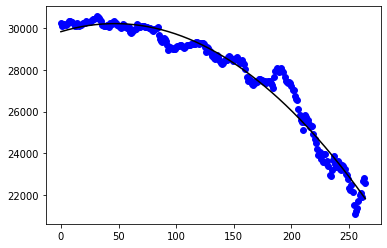

2022-06-14T06:30:00, SELL EXECUTED, Price: 22477.56, Costed Total Of: 93162.79, Comm 0.00


2022-06-14T06:30:00, Close, 22604.01
2022-08-21 16:51:55:  --- Position Begin
- Size: -4.144702070424377
- Price: 22477.56
- Price orig: 0.0
- Closed: 0
- Opened: -4.144702070424377
- Adjbase: 22604.01
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        4.144702070424377
-----Order price:        None
-----Order Type:        5
-----Trail Amount:        350
-----Trail Percent:        None
-----Created Price:        22827.56
-----Is Buy:        True
2022-06-14T06:30:00, predict, and max, min 21813.50,  22864.39,20762.61,
Portfolio 93579.73017075866 the other one 941.0382774756436
2022-08-21 16:51:55:  In Downtrend
sell value 22195.978515862596
current model value 21735.891639186535 predicted model next value 21657.929540119792


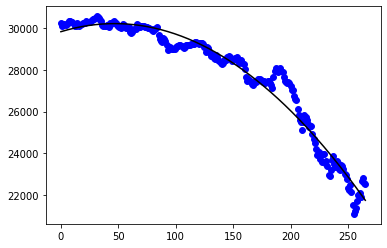



2022-06-14T07:00:00, Close, 22527.24
2022-08-21 16:51:56:  --- Position Begin
- Size: -4.144702070424377
- Price: 22477.56
- Price orig: 0.0
- Closed: 0
- Opened: -4.144702070424377
- Adjbase: 22527.24
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        4.144702070424377
-----Order price:        None
-----Order Type:        5
-----Trail Amount:        350
-----Trail Percent:        None
-----Created Price:        22827.56
-----Is Buy:        True
2022-06-14T07:00:00, predict, and max, min 21735.89,  22787.49,20684.30,
Portfolio 93897.91894870513 the other one 941.0382774756436
2022-08-21 16:51:56:  In Downtrend
sell value 22118.201962916926
current model value 21657.929540119792 predicted model next value 21579.61115350516


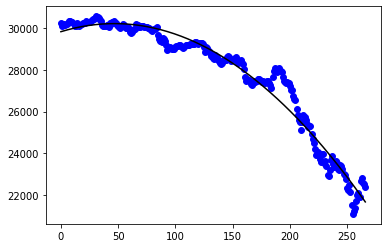

2022-06-14T07:30:00, BUY EXECUTED, Price: 22827.56, Costed Total Of: 93162.79, Comm 0.00
2022-06-14T07:30:00, OPERATION PROFIT, GROSS -1450.65, NET -1450.65


2022-06-14T07:30:00, Close, 22853.55
2022-08-21 16:51:56:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 22477.56
- Closed: 4.144702070424377
- Opened: 0
- Adjbase: 22527.24
--- Position End
Open Orders: 
2022-06-14T07:30:00, predict, and max, min 21657.93,  22709.71,20606.15,
Portfolio 92653.18202291528 the other one 92653.18202291528
2022-08-21 16:51:56:  Finding the best model and optimizing time...
2022-08-21 16:52:01:  FInished computing all models... Finding and returning best model
2022-08-21 16:52:01:  Remodeling inaccurate model...
current model value 21707.130248653997 predicted model next value 21630.58257837814


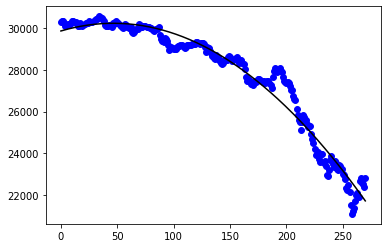



2022-06-14T08:00:00, Close, 22778.16
2022-08-21 16:52:01:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 22477.56
- Closed: 4.144702070424377
- Opened: 0
- Adjbase: 22527.24
--- Position End
Open Orders: 
2022-06-14T08:00:00, predict, and max, min 21707.13,  22773.45,20640.81,
Portfolio 92653.18202291528 the other one 92653.18202291528
2022-08-21 16:52:01:  Finding the best model and optimizing time...
2022-08-21 16:52:07:  FInished computing all models... Finding and returning best model
2022-08-21 16:52:07:  Remodeling inaccurate model...
current model value 22638.361346143225 predicted model next value 22737.115871291433


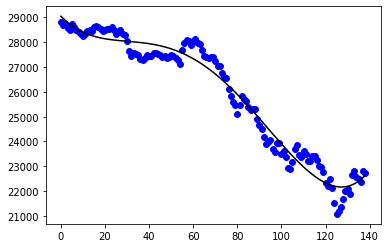



2022-06-14T08:30:00, Close, 22577.16
2022-08-21 16:52:07:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 22477.56
- Closed: 4.144702070424377
- Opened: 0
- Adjbase: 22527.24
--- Position End
Open Orders: 
2022-06-14T08:30:00, predict, and max, min 22638.36,  23297.28,21979.44,
Portfolio 92653.18202291528 the other one 92653.18202291528
2022-08-21 16:52:07:  In Uptrend
2022-06-14: Limit Order / Buy at 22417.772371488627
2022-06-14: Limit Order / Sell at 23040.985555391664
current model value 22737.115871291433 predicted model next value 22846.552536995485


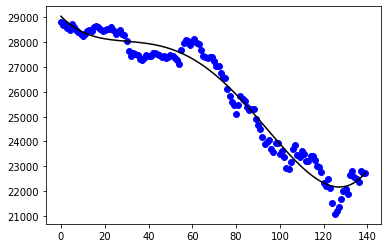

Limit ordering
2022-06-14T09:00:00, BUY EXECUTED, Price: 22417.77, Costed Total Of: 91726.65, Comm 0.00
2022-06-14T09:00:00, Order Canceled


2022-06-14T09:00:00, Close, 22418.79
2022-08-21 16:52:07:  --- Position Begin
- Size: 4.091693353053487
- Price: 22417.772371488627
- Price orig: 0.0
- Closed: 0
- Opened: 4.091693353053487
- Adjbase: 22418.79
--- Position End
Open Orders: 
2022-06-14T09:00:00, predict, and max, min 22737.12,  23399.99,22074.24,
Portfolio 92657.34584673114 the other one 926.5318202291528
2022-08-21 16:52:07:  In Uptrend
buy value 22526.060708206438
current model value 22846.552536995485 predicted model next value 22967.009430340986


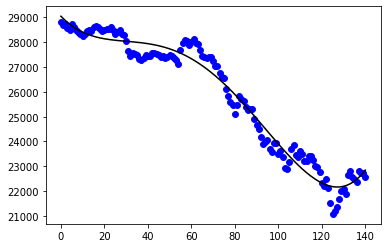



2022-06-14T09:30:00, Close, 22253.27
2022-08-21 16:52:07:  --- Position Begin
- Size: 4.091693353053487
- Price: 22417.772371488627
- Price orig: 0.0
- Closed: 0
- Opened: 4.091693353053487
- Adjbase: 22253.27
--- Position End
Open Orders: 
2022-06-14T09:30:00, predict, and max, min 22846.55,  23507.38,22185.72,
Portfolio 91980.08876293372 the other one 926.5318202291528
2022-08-21 16:52:07:  In Uptrend
buy value 22647.11121436929
current model value 22967.009430340986 predicted model next value 23098.829005870313


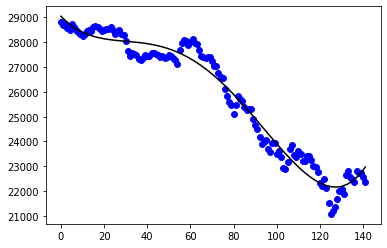



2022-06-14T10:00:00, Close, 22475.99
2022-08-21 16:52:07:  --- Position Begin
- Size: 4.091693353053487
- Price: 22417.772371488627
- Price orig: 0.0
- Closed: 0
- Opened: 4.091693353053487
- Adjbase: 22475.99
--- Position End
Open Orders: 
2022-06-14T10:00:00, predict, and max, min 22967.01,  23627.77,22306.25,
Portfolio 92891.39070652581 the other one 926.5318202291528
2022-08-21 16:52:07:  In Uptrend
buy value 22778.95211090475
current model value 23098.829005870313 predicted model next value 23242.358085582717


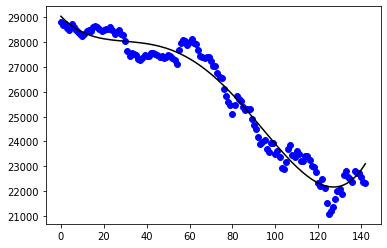



2022-06-14T10:30:00, Close, 22350.16
2022-08-21 16:52:08:  --- Position Begin
- Size: 4.091693353053487
- Price: 22417.772371488627
- Price orig: 0.0
- Closed: 0
- Opened: 4.091693353053487
- Adjbase: 22350.16
--- Position End
Open Orders: 
2022-06-14T10:30:00, predict, and max, min 23098.83,  23764.81,22432.85,
Portfolio 92376.53293191108 the other one 926.5318202291528
2022-08-21 16:52:08:  Finding the best model and optimizing time...
2022-08-21 16:52:13:  FInished computing all models... Finding and returning best model
2022-08-21 16:52:13:  Remodeling inaccurate model...
2022-08-21 16:52:13:  Close all long positions here
current model value 22781.31688236927 predicted model next value 22889.57252252735


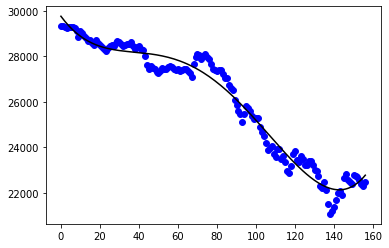

2022-06-14T11:00:00, SELL EXECUTED, Price: 22350.16, Costed Total Of: 91726.65, Comm 0.00
2022-06-14T11:00:00, OPERATION PROFIT, GROSS -276.65, NET -276.65


2022-06-14T11:00:00, Close, 21953.21
2022-08-21 16:52:13:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 22417.772371488627
- Closed: -4.091693353053487
- Opened: 0
- Adjbase: 22350.16
--- Position End
Open Orders: 
2022-06-14T11:00:00, predict, and max, min 22781.32,  23470.44,22092.19,
Portfolio 92376.53293191108 the other one 92376.53293191108
2022-08-21 16:52:13:  Finding the best model and optimizing time...
2022-08-21 16:52:18:  FInished computing all models... Finding and returning best model
2022-08-21 16:52:18:  Remodeling inaccurate model...
current model value 22777.635394343673 predicted model next value 22886.91506750719


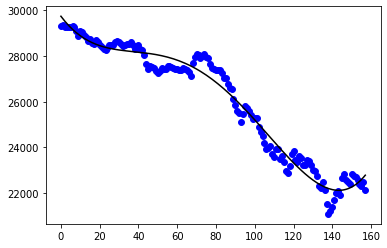



2022-06-14T11:30:00, Close, 21969.49
2022-08-21 16:52:18:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 22417.772371488627
- Closed: -4.091693353053487
- Opened: 0
- Adjbase: 22350.16
--- Position End
Open Orders: 
2022-06-14T11:30:00, predict, and max, min 22777.64,  23472.80,22082.47,
Portfolio 92376.53293191108 the other one 92376.53293191108
2022-08-21 16:52:18:  Finding the best model and optimizing time...
2022-08-21 16:52:23:  FInished computing all models... Finding and returning best model
2022-08-21 16:52:23:  Remodeling inaccurate model...
current model value 22726.636986354184 predicted model next value 22831.854898820537


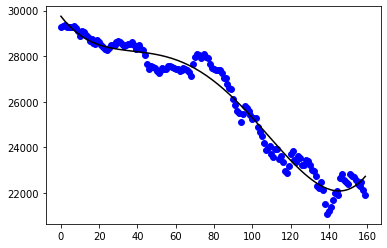



2022-06-14T12:00:00, Close, 21792.01
2022-08-21 16:52:24:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 22417.772371488627
- Closed: -4.091693353053487
- Opened: 0
- Adjbase: 22350.16
--- Position End
Open Orders: 
2022-06-14T12:00:00, predict, and max, min 22726.64,  23442.42,22010.86,
Portfolio 92376.53293191108 the other one 92376.53293191108
2022-08-21 16:52:24:  Finding the best model and optimizing time...
2022-08-21 16:52:29:  FInished computing all models... Finding and returning best model
2022-08-21 16:52:29:  Remodeling inaccurate model...
current model value 22687.09139153942 predicted model next value 22789.179000499484


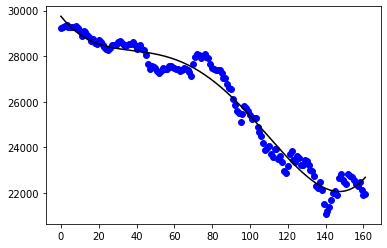



2022-06-14T12:30:00, Close, 22123.90
2022-08-21 16:52:29:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 22417.772371488627
- Closed: -4.091693353053487
- Opened: 0
- Adjbase: 22350.16
--- Position End
Open Orders: 
2022-06-14T12:30:00, predict, and max, min 22687.09,  23415.54,21958.64,
Portfolio 92376.53293191108 the other one 92376.53293191108
2022-08-21 16:52:29:  In Uptrend
buy value 22437.759272135117
2022-06-14T12:30:00, BUY CREATE, 22123.90 and now rebalancing portfolio
current model value 22789.179000499484 predicted model next value 22900.163632292242


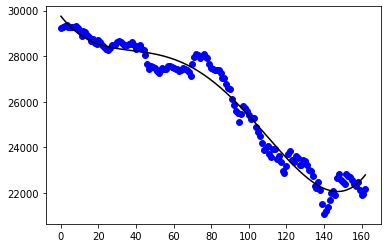

2022-06-14T13:00:00, BUY EXECUTED, Price: 22123.90, Costed Total Of: 91452.77, Comm 0.00


2022-06-14T13:00:00, Close, 22514.28
2022-08-21 16:52:29:  --- Position Begin
- Size: 4.133663938211254
- Price: 22123.9
- Price orig: 0.0
- Closed: 0
- Opened: 4.133663938211254
- Adjbase: 22514.28
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        4.133663938211254
-----Order price:        None
-----Order Type:        5
-----Trail Amount:        350
-----Trail Percent:        None
-----Created Price:        22164.28
-----Is Buy:        False
2022-06-14T13:00:00, predict, and max, min 22789.18,  23517.98,22060.38,
Portfolio 93990.23266010998 the other one 923.7653293191106
2022-08-21 16:52:29:  In Uptrend
buy value 22548.64287761203
current model value 22900.163632292242 predicted model next value 23020.28782556235


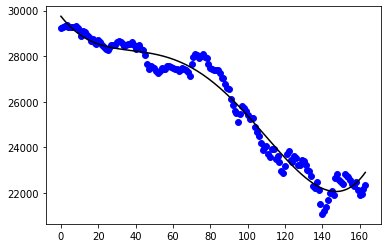

2022-06-14T13:30:00, SELL EXECUTED, Price: 22164.28, Costed Total Of: 91452.77, Comm 0.00
2022-06-14T13:30:00, OPERATION PROFIT, GROSS 166.92, NET 166.92


2022-06-14T13:30:00, Close, 22381.65
2022-08-21 16:52:29:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 22123.9
- Closed: -4.133663938211254
- Opened: 0
- Adjbase: 22514.28
--- Position End
Open Orders: 
2022-06-14T13:30:00, predict, and max, min 22900.16,  23628.01,22172.32,
Portfolio 92543.45028173603 the other one 92543.45028173603
2022-08-21 16:52:29:  In Uptrend
buy value 22669.0440086445
2022-06-14T13:30:00, BUY CREATE, 22381.65 and now rebalancing portfolio
current model value 23020.28782556235 predicted model next value 23149.796849557577


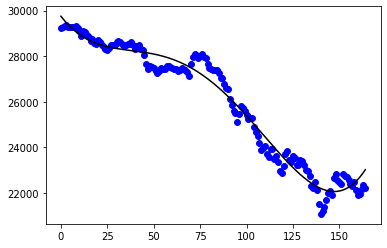

2022-06-14T14:00:00, BUY EXECUTED, Price: 22381.65, Costed Total Of: 91618.02, Comm 0.00


2022-06-14T14:00:00, Close, 22093.55
2022-08-21 16:52:29:  --- Position Begin
- Size: 4.093443324282108
- Price: 22381.65
- Price orig: 0.0
- Closed: 0
- Opened: 4.093443324282108
- Adjbase: 22093.55
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        4.093443324282108
-----Order price:        None
-----Order Type:        5
-----Trail Amount:        350
-----Trail Percent:        None
-----Created Price:        22031.65
-----Is Buy:        False
2022-06-14T14:00:00, predict, and max, min 23020.29,  23752.60,22287.97,
Portfolio 91364.12926001035 the other one 925.4345028173702
2022-08-21 16:52:29:  Finding the best model and optimizing time...
2022-08-21 16:52:34:  FInished computing all models... Finding and returning best model
2022-08-21 16:52:34:  Remodeling inaccurate model...
2022-08-21 16:52:35:  Close all long positions here
current model value 22749.20292

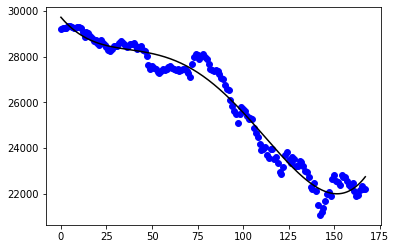

2022-06-14T14:30:00, Order Canceled
2022-06-14T14:30:00, SELL EXECUTED, Price: 22093.55, Costed Total Of: 91618.02, Comm 0.00
2022-06-14T14:30:00, OPERATION PROFIT, GROSS -1179.32, NET -1179.32


2022-06-14T14:30:00, Close, 22479.03
2022-08-21 16:52:35:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 22381.65
- Closed: -4.093443324282108
- Opened: 0
- Adjbase: 22093.55
--- Position End
Open Orders: 
2022-06-14T14:30:00, predict, and max, min 22749.20,  23490.43,22007.98,
Portfolio 91364.12926001035 the other one 91364.12926001035
2022-08-21 16:52:35:  In Uptrend
buy value 22502.176044493848
2022-06-14T14:30:00, BUY CREATE, 22479.03 and now rebalancing portfolio
current model value 22857.295005897708 predicted model next value 22973.876593084577


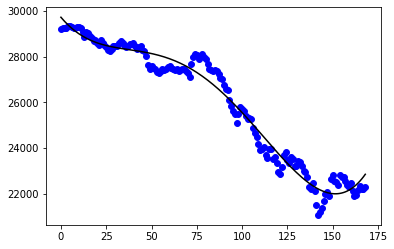

2022-06-14T15:00:00, BUY EXECUTED, Price: 22479.03, Costed Total Of: 90450.49, Comm 0.00


2022-06-14T15:00:00, Close, 22448.44
2022-08-21 16:52:35:  --- Position Begin
- Size: 4.023771842797943
- Price: 22479.03
- Price orig: 0.0
- Closed: 0
- Opened: 4.023771842797943
- Adjbase: 22448.44
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        4.023771842797943
-----Order price:        None
-----Order Type:        5
-----Trail Amount:        350
-----Trail Percent:        None
-----Created Price:        22129.03
-----Is Buy:        False
2022-06-14T15:00:00, predict, and max, min 22857.30,  23597.86,22116.73,
Portfolio 91241.04207933915 the other one 913.6412926000921
2022-08-21 16:52:35:  In Uptrend
buy value 22619.69651082163
current model value 22973.876593084577 predicted model next value 23099.165726592844


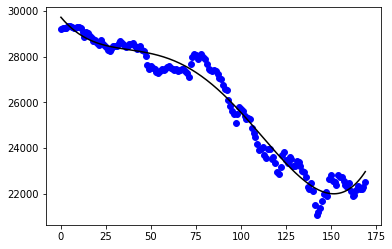



2022-06-14T15:30:00, Close, 22656.91
2022-08-21 16:52:35:  --- Position Begin
- Size: 4.023771842797943
- Price: 22479.03
- Price orig: 0.0
- Closed: 0
- Opened: 4.023771842797943
- Adjbase: 22656.91
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        4.023771842797943
-----Order price:        None
-----Order Type:        5
-----Trail Amount:        350
-----Trail Percent:        None
-----Created Price:        22306.91
-----Is Buy:        False
2022-06-14T15:30:00, predict, and max, min 22973.88,  23712.50,22235.25,
Portfolio 92079.87779540724 the other one 913.6412926000921
2022-08-21 16:52:35:  In Uptrend
buy value 22745.543773325622
current model value 23099.165726592844 predicted model next value 23233.38278021881


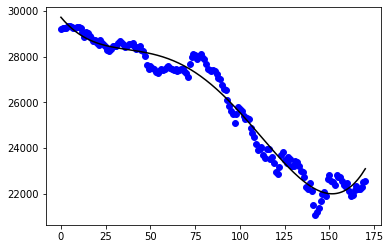



2022-06-14T16:00:00, Close, 22662.16
2022-08-21 16:52:35:  --- Position Begin
- Size: 4.023771842797943
- Price: 22479.03
- Price orig: 0.0
- Closed: 0
- Opened: 4.023771842797943
- Adjbase: 22662.16
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        4.023771842797943
-----Order price:        None
-----Order Type:        5
-----Trail Amount:        350
-----Trail Percent:        None
-----Created Price:        22312.16
-----Is Buy:        False
2022-06-14T16:00:00, predict, and max, min 23099.17,  23836.61,22361.72,
Portfolio 92101.00259758193 the other one 913.6412926000921
2022-08-21 16:52:35:  In Uptrend
buy value 22880.10037850362
current model value 23233.38278021881 predicted model next value 23376.750457543727


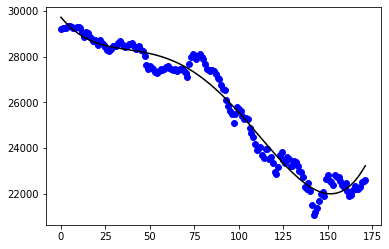



2022-06-14T16:30:00, Close, 22460.72
2022-08-21 16:52:35:  --- Position Begin
- Size: 4.023771842797943
- Price: 22479.03
- Price orig: 0.0
- Closed: 0
- Opened: 4.023771842797943
- Adjbase: 22460.72
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        4.023771842797943
-----Order price:        None
-----Order Type:        5
-----Trail Amount:        350
-----Trail Percent:        None
-----Created Price:        22312.16
-----Is Buy:        False
2022-06-14T16:30:00, predict, and max, min 23233.38,  23971.06,22495.71,
Portfolio 91290.45399756872 the other one 913.6412926000921
2022-08-21 16:52:35:  Finding the best model and optimizing time...
2022-08-21 16:52:40:  FInished computing all models... Finding and returning best model
2022-08-21 16:52:40:  Remodeling inaccurate model...
2022-08-21 16:52:41:  Close all long positions here
current model value 22833.195464647444 predicted model next value 22935.59170666328


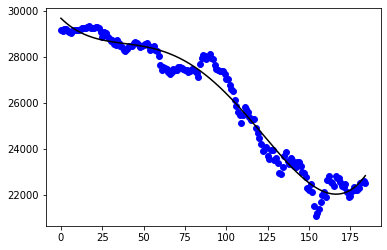

2022-06-14T17:00:00, Order Canceled
2022-06-14T17:00:00, SELL EXECUTED, Price: 22460.72, Costed Total Of: 90450.49, Comm 0.00
2022-06-14T17:00:00, OPERATION PROFIT, GROSS -73.68, NET -73.68


2022-06-14T17:00:00, Close, 22622.03
2022-08-21 16:52:41:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 22479.03
- Closed: -4.023771842797943
- Opened: 0
- Adjbase: 22460.72
--- Position End
Open Orders: 
2022-06-14T17:00:00, predict, and max, min 22833.20,  23637.82,22028.57,
Portfolio 91290.45399756872 the other one 91290.45399756872
2022-08-21 16:52:41:  In Uptrend
2022-06-14: Limit Order / Buy at 22562.01446969681
2022-06-14: Limit Order / Sell at 23292.297694231496
current model value 22935.59170666328 predicted model next value 23045.081672901924


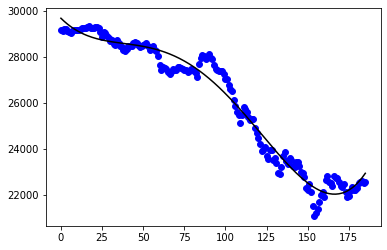

Limit ordering
2022-06-14T17:30:00, BUY EXECUTED, Price: 22562.01, Costed Total Of: 90377.55, Comm 0.00
2022-06-14T17:30:00, Order Canceled


2022-06-14T17:30:00, Close, 22331.14
2022-08-21 16:52:41:  --- Position Begin
- Size: 4.005739362457183
- Price: 22562.01446969681
- Price orig: 0.0
- Closed: 0
- Opened: 4.005739362457183
- Adjbase: 22331.14
--- Position End
Open Orders: 
2022-06-14T17:30:00, predict, and max, min 22935.59,  23738.05,22133.13,
Portfolio 90365.6310465178 the other one 912.9045399757015
2022-08-21 16:52:41:  In Uptrend
buy value 22673.78520947728
current model value 23045.081672901924 predicted model next value 23161.827322495894


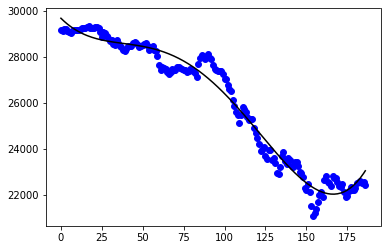



2022-06-14T18:00:00, Close, 22419.23
2022-08-21 16:52:41:  --- Position Begin
- Size: 4.005739362457183
- Price: 22562.01446969681
- Price orig: 0.0
- Closed: 0
- Opened: 4.005739362457183
- Adjbase: 22419.23
--- Position End
Open Orders: 
2022-06-14T18:00:00, predict, and max, min 23045.08,  23847.38,22242.78,
Portfolio 90718.49662695664 the other one 912.9045399757015
2022-08-21 16:52:41:  In Uptrend
buy value 22790.574851157155
current model value 23161.827322495894 predicted model next value 23285.992152442817


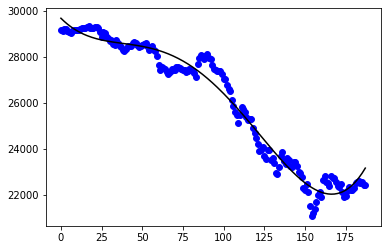



2022-06-14T18:30:00, Close, 22281.48
2022-08-21 16:52:41:  --- Position Begin
- Size: 4.005739362457183
- Price: 22562.01446969681
- Price orig: 0.0
- Closed: 0
- Opened: 4.005739362457183
- Adjbase: 22281.48
--- Position End
Open Orders: 
2022-06-14T18:30:00, predict, and max, min 23161.83,  23966.22,22357.43,
Portfolio 90166.70602977817 the other one 912.9045399757015
2022-08-21 16:52:41:  Finding the best model and optimizing time...
2022-08-21 16:52:46:  FInished computing all models... Finding and returning best model
2022-08-21 16:52:46:  Remodeling inaccurate model...
2022-08-21 16:52:46:  Close all long positions here
current model value 22706.304346376044 predicted model next value 22784.607705918435


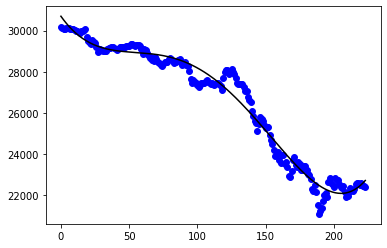

2022-06-14T19:00:00, SELL EXECUTED, Price: 22281.48, Costed Total Of: 90377.55, Comm 0.00
2022-06-14T19:00:00, OPERATION PROFIT, GROSS -1123.75, NET -1123.75


2022-06-14T19:00:00, Close, 22134.49
2022-08-21 16:52:47:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 22562.01446969681
- Closed: -4.005739362457183
- Opened: 0
- Adjbase: 22281.48
--- Position End
Open Orders: 
2022-06-14T19:00:00, predict, and max, min 22706.30,  23567.52,21845.09,
Portfolio 90166.70602977816 the other one 90166.70602977816
2022-08-21 16:52:47:  In Uptrend
buy value 22392.53805895948
2022-06-14T19:00:00, BUY CREATE, 22134.49 and now rebalancing portfolio
current model value 22784.607705918435 predicted model next value 22868.17079486985


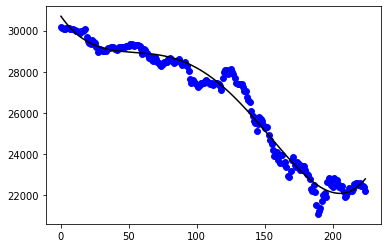

2022-06-14T19:30:00, BUY EXECUTED, Price: 22134.49, Costed Total Of: 89265.04, Comm 0.00


2022-06-14T19:30:00, Close, 22161.45
2022-08-21 16:52:47:  --- Position Begin
- Size: 4.032848236823183
- Price: 22134.49
- Price orig: 0.0
- Closed: 0
- Opened: 4.032848236823183
- Adjbase: 22161.45
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        4.032848236823183
-----Order price:        None
-----Order Type:        5
-----Trail Amount:        350
-----Trail Percent:        None
-----Created Price:        21811.45
-----Is Buy:        False
2022-06-14T19:30:00, predict, and max, min 22784.61,  23645.52,21923.70,
Portfolio 90275.43161824292 the other one 901.6670602977829
2022-08-21 16:52:47:  In Uptrend
buy value 22476.18493439958
current model value 22868.17079486985 predicted model next value 22957.100216777373


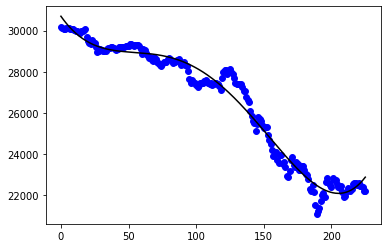



2022-06-14T20:00:00, Close, 21907.57
2022-08-21 16:52:47:  --- Position Begin
- Size: 4.032848236823183
- Price: 22134.49
- Price orig: 0.0
- Closed: 0
- Opened: 4.032848236823183
- Adjbase: 21907.57
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        4.032848236823183
-----Order price:        None
-----Order Type:        5
-----Trail Amount:        350
-----Trail Percent:        None
-----Created Price:        21811.45
-----Is Buy:        False
2022-06-14T20:00:00, predict, and max, min 22868.17,  23729.55,22006.79,
Portfolio 89251.57210787824 the other one 901.6670602977829
2022-08-21 16:52:47:  Finding the best model and optimizing time...
2022-08-21 16:52:52:  FInished computing all models... Finding and returning best model
2022-08-21 16:52:52:  Remodeling inaccurate model...
2022-08-21 16:52:52:  Close all long positions here
current model value 22744.608707078594 predicted model next value 22827.77141605509


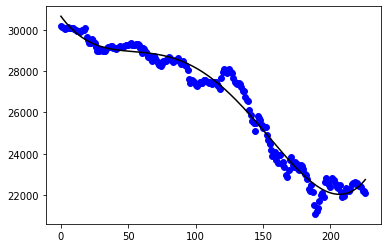

2022-06-14T20:30:00, Order Canceled
2022-06-14T20:30:00, SELL EXECUTED, Price: 21907.57, Costed Total Of: 89265.04, Comm 0.00
2022-06-14T20:30:00, OPERATION PROFIT, GROSS -915.13, NET -915.13


2022-06-14T20:30:00, Close, 21967.25
2022-08-21 16:52:52:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 22134.49
- Closed: -4.032848236823183
- Opened: 0
- Adjbase: 21907.57
--- Position End
Open Orders: 
2022-06-14T20:30:00, predict, and max, min 22744.61,  23607.67,21881.55,
Portfolio 89251.57210787824 the other one 89251.57210787824
2022-08-21 16:52:52:  In Uptrend
buy value 22436.374162138378
2022-06-14T20:30:00, BUY CREATE, 21967.25 and now rebalancing portfolio
current model value 22827.77141605509 predicted model next value 22916.17109385333


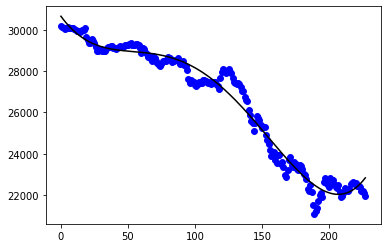

2022-06-14T21:00:00, BUY EXECUTED, Price: 21967.25, Costed Total Of: 88359.06, Comm 0.00
2022-06-14T21:00:00, SELL EXECUTED, Price: 21617.25, Costed Total Of: 88359.06, Comm 0.00
2022-06-14T21:00:00, OPERATION PROFIT, GROSS -1407.81, NET -1407.81


2022-06-14T21:00:00, Close, 21535.92
2022-08-21 16:52:52:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 21967.25
- Closed: -4.022308499552718
- Opened: 0
- Adjbase: 21967.25
--- Position End
Open Orders: 
2022-06-14T21:00:00, predict, and max, min 22827.77,  23695.02,21960.52,
Portfolio 87843.76413303478 the other one 87843.76413303478
2022-08-21 16:52:52:  Finding the best model and optimizing time...
2022-08-21 16:52:57:  FInished computing all models... Finding and returning best model
2022-08-21 16:52:57:  Remodeling inaccurate model...
current model value 22720.326372219806 predicted model next value 22803.710743433072


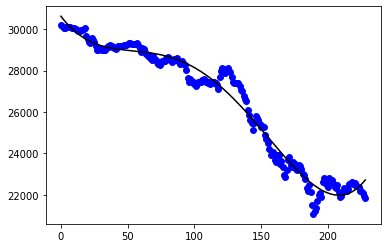



2022-06-14T21:30:00, Close, 21462.13
2022-08-21 16:52:58:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 21967.25
- Closed: -4.022308499552718
- Opened: 0
- Adjbase: 21967.25
--- Position End
Open Orders: 
2022-06-14T21:30:00, predict, and max, min 22720.33,  23595.40,21845.25,
Portfolio 87843.76413303478 the other one 87843.76413303478
2022-08-21 16:52:58:  Finding the best model and optimizing time...
2022-08-21 16:53:03:  FInished computing all models... Finding and returning best model
2022-08-21 16:53:03:  Remodeling inaccurate model...
current model value 22665.1693618257 predicted model next value 22746.327195739974


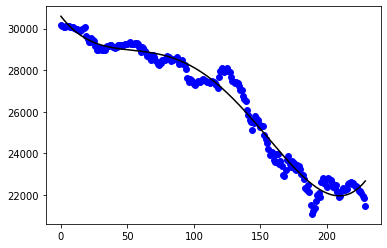



2022-06-14T22:00:00, Close, 21586.94
2022-08-21 16:53:03:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 21967.25
- Closed: -4.022308499552718
- Opened: 0
- Adjbase: 21967.25
--- Position End
Open Orders: 
2022-06-14T22:00:00, predict, and max, min 22665.17,  23559.14,21771.20,
Portfolio 87843.76413303478 the other one 87843.76413303478
2022-08-21 16:53:03:  Finding the best model and optimizing time...
2022-08-21 16:53:08:  FInished computing all models... Finding and returning best model
2022-08-21 16:53:08:  Remodeling inaccurate model...
current model value 22622.66774141647 predicted model next value 22702.292549377973


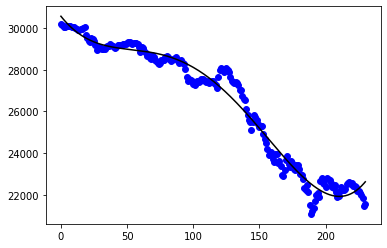



2022-06-14T22:30:00, Close, 21570.18
2022-08-21 16:53:08:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 21967.25
- Closed: -4.022308499552718
- Opened: 0
- Adjbase: 21967.25
--- Position End
Open Orders: 
2022-06-14T22:30:00, predict, and max, min 22622.67,  23529.61,21715.73,
Portfolio 87843.76413303478 the other one 87843.76413303478
2022-08-21 16:53:08:  Finding the best model and optimizing time...
2022-08-21 16:53:13:  FInished computing all models... Finding and returning best model
2022-08-21 16:53:13:  Remodeling inaccurate model...
current model value 22584.14204702251 predicted model next value 22662.449774176242


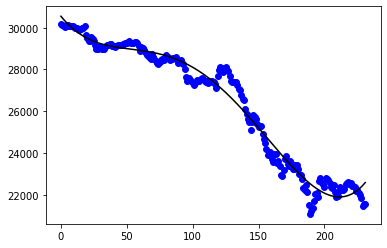



2022-06-14T23:00:00, Close, 21961.09
2022-08-21 16:53:14:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 21967.25
- Closed: -4.022308499552718
- Opened: 0
- Adjbase: 21967.25
--- Position End
Open Orders: 
2022-06-14T23:00:00, predict, and max, min 22584.14,  23502.95,21665.33,
Portfolio 87843.76413303478 the other one 87843.76413303478
2022-08-21 16:53:14:  In Uptrend
buy value 22243.10135384611
2022-06-14T23:00:00, BUY CREATE, 21961.09 and now rebalancing portfolio
current model value 22662.449774176242 predicted model next value 22745.56250633731


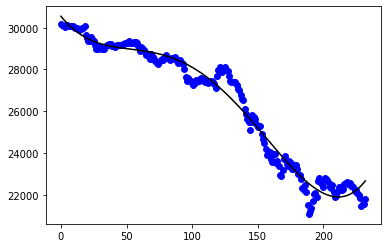

2022-06-14T23:30:00, BUY EXECUTED, Price: 21961.09, Costed Total Of: 86965.33, Comm 0.00


2022-06-14T23:30:00, Close, 22119.97
2022-08-21 16:53:14:  --- Position Begin
- Size: 3.959973138478301
- Price: 21961.09
- Price orig: 0.0
- Closed: 0
- Opened: 3.959973138478301
- Adjbase: 22119.97
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        3.959973138478301
-----Order price:        None
-----Order Type:        5
-----Trail Amount:        350
-----Trail Percent:        None
-----Created Price:        21769.97
-----Is Buy:        False
2022-06-14T23:30:00, predict, and max, min 22662.45,  23584.30,21740.60,
Portfolio 88472.92466527622 the other one 878.4376413303544
2022-08-21 16:53:14:  In Uptrend
buy value 22325.382238368933
current model value 22745.56250633731 predicted model next value 22833.571391686037


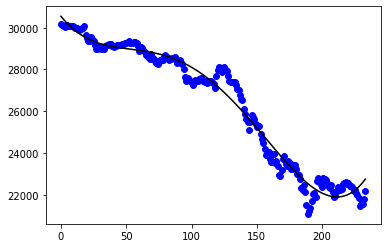



2022-06-15T00:00:00, Close, 21950.06
2022-08-21 16:53:14:  --- Position Begin
- Size: 3.959973138478301
- Price: 21961.09
- Price orig: 0.0
- Closed: 0
- Opened: 3.959973138478301
- Adjbase: 21950.06
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        3.959973138478301
-----Order price:        None
-----Order Type:        5
-----Trail Amount:        350
-----Trail Percent:        None
-----Created Price:        21769.97
-----Is Buy:        False
2022-06-15T00:00:00, predict, and max, min 22745.56,  23666.45,21824.68,
Portfolio 87800.08562931737 the other one 878.4376413303544
2022-08-21 16:53:14:  In Uptrend
buy value 22413.655462105333
current model value 22833.571391686037 predicted model next value 22926.568292953885


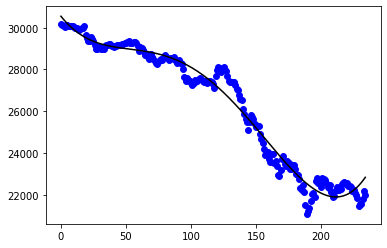

2022-06-15T00:30:00, SELL EXECUTED, Price: 21769.97, Costed Total Of: 86965.33, Comm 0.00
2022-06-15T00:30:00, OPERATION PROFIT, GROSS -756.83, NET -756.83


2022-06-15T00:30:00, Close, 21792.63
2022-08-21 16:53:14:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 21961.09
- Closed: -3.959973138478301
- Opened: 0
- Adjbase: 21950.06
--- Position End
Open Orders: 
2022-06-15T00:30:00, predict, and max, min 22833.57,  23757.46,21909.69,
Portfolio 87086.93406680881 the other one 87086.93406680881
2022-08-21 16:53:14:  Finding the best model and optimizing time...
2022-08-21 16:53:19:  FInished computing all models... Finding and returning best model
2022-08-21 16:53:19:  Remodeling inaccurate model...
current model value 22371.784776226177 predicted model next value 22429.015614761065


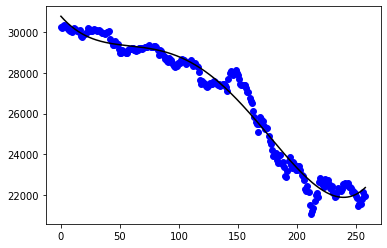



2022-06-15T01:00:00, Close, 21974.37
2022-08-21 16:53:20:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 21961.09
- Closed: -3.959973138478301
- Opened: 0
- Adjbase: 21950.06
--- Position End
Open Orders: 
2022-06-15T01:00:00, predict, and max, min 22371.78,  23317.05,21426.52,
Portfolio 87086.93406680881 the other one 87086.93406680881
2022-08-21 16:53:20:  In Uptrend
buy value 22006.79386951866
2022-06-15T01:00:00, BUY CREATE, 21974.37 and now rebalancing portfolio
current model value 22429.015614761065 predicted model next value 22489.871800531746


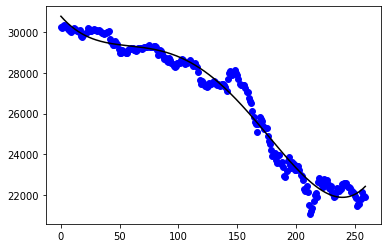

2022-06-15T01:30:00, BUY EXECUTED, Price: 21974.37, Costed Total Of: 86216.06, Comm 0.00


2022-06-15T01:30:00, Close, 22142.86
2022-08-21 16:53:20:  --- Position Begin
- Size: 3.923482890573915
- Price: 21974.37
- Price orig: 0.0
- Closed: 0
- Opened: 3.923482890573915
- Adjbase: 22142.86
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        3.923482890573915
-----Order price:        None
-----Order Type:        5
-----Trail Amount:        350
-----Trail Percent:        None
-----Created Price:        21792.86
-----Is Buy:        False
2022-06-15T01:30:00, predict, and max, min 22429.02,  23372.95,21485.08,
Portfolio 87748.00169904162 the other one 870.8693406680977
2022-08-21 16:53:20:  In Uptrend
2022-06-15: Limit Order / Buy at 22068.008019600835
2022-06-15: Limit Order / Sell at 22892.602888276233
current model value 22489.871800531746 predicted model next value 22554.416059783438


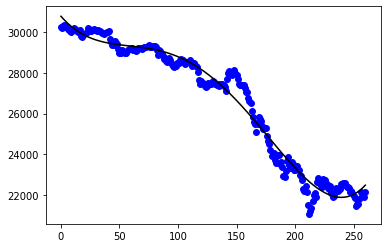

Limit ordering
2022-06-15T02:00:00, SELL EXECUTED, Price: 22142.86, Costed Total Of: 6.58, Comm 0.00
2022-06-15T02:00:00, Order Canceled


2022-06-15T02:00:00, Close, 21933.03
2022-08-21 16:53:20:  --- Position Begin
- Size: 3.923183331306198
- Price: 21974.37
- Price orig: 21974.37
- Closed: -0.0002995592677168647
- Opened: 0
- Adjbase: 21933.03
--- Position End
Open Orders: 
2022-06-15T02:00:00, predict, and max, min 22489.87,  23431.99,21547.75,
Portfolio 86924.80014063363 the other one 877.5024395948548
2022-08-21 16:53:20:  In Uptrend
buy value 22133.88910364262
current model value 22554.416059783438 predicted model next value 22622.711561587956


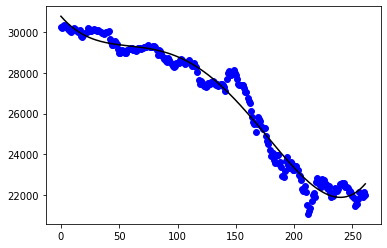

2022-06-15T02:30:00, Order Canceled


2022-06-15T02:30:00, Close, 21965.88
2022-08-21 16:53:20:  --- Position Begin
- Size: 3.923183331306198
- Price: 21974.37
- Price orig: 21974.37
- Closed: -0.0002995592677168647
- Opened: 0
- Adjbase: 21965.88
--- Position End
Open Orders: 
2022-06-15T02:30:00, predict, and max, min 22554.42,  23495.35,21613.49,
Portfolio 87053.67671306705 the other one 877.5024395948548
2022-08-21 16:53:20:  In Uptrend
buy value 22202.50391017114
current model value 22622.711561587956 predicted model next value 22694.821917843783


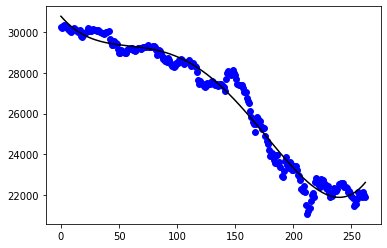



2022-06-15T03:00:00, Close, 21681.12
2022-08-21 16:53:20:  --- Position Begin
- Size: 3.923183331306198
- Price: 21974.37
- Price orig: 21974.37
- Closed: -0.0002995592677168647
- Opened: 0
- Adjbase: 21681.12
--- Position End
Open Orders: 
2022-06-15T03:00:00, predict, and max, min 22622.71,  23564.24,21681.18,
Portfolio 85936.51102764429 the other one 877.5024395948548
2022-08-21 16:53:20:  Finding the best model and optimizing time...
2022-08-21 16:53:25:  FInished computing all models... Finding and returning best model
2022-08-21 16:53:25:  Remodeling inaccurate model...
2022-08-21 16:53:26:  Close all long positions here
current model value 22324.271791307205 predicted model next value 22378.495601596536


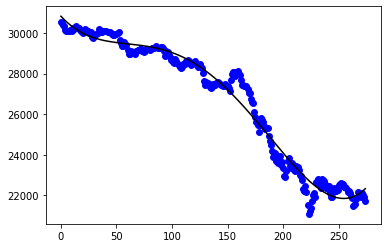

2022-06-15T03:30:00, SELL EXECUTED, Price: 21681.12, Costed Total Of: 86209.48, Comm 0.00
2022-06-15T03:30:00, OPERATION PROFIT, GROSS -1150.42, NET -1150.42


2022-06-15T03:30:00, Close, 21421.00
2022-08-21 16:53:26:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 21974.37
- Closed: -3.923183331306198
- Opened: 0
- Adjbase: 21681.12
--- Position End
Open Orders: 
2022-06-15T03:30:00, predict, and max, min 22324.27,  23286.16,21362.38,
Portfolio 85936.51102764429 the other one 85936.51102764429
2022-08-21 16:53:26:  In Uptrend
buy value 21949.606942094062
2022-06-15T03:30:00, BUY CREATE, 21421.00 and now rebalancing portfolio
current model value 22378.495601596536 predicted model next value 22435.961172489762


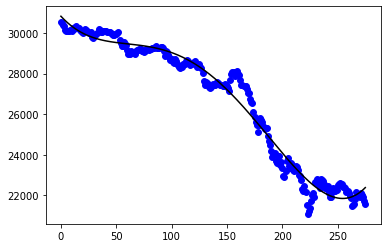

2022-06-15T04:00:00, BUY EXECUTED, Price: 21421.00, Costed Total Of: 85077.15, Comm 0.00
2022-06-15T04:00:00, SELL EXECUTED, Price: 21071.00, Costed Total Of: 85077.15, Comm 0.00
2022-06-15T04:00:00, OPERATION PROFIT, GROSS -1390.08, NET -1390.08


2022-06-15T04:00:00, Close, 20978.42
2022-08-21 16:53:26:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 21421.0
- Closed: -3.9716701329241326
- Opened: 0
- Adjbase: 21421.0
--- Position End
Open Orders: 
2022-06-15T04:00:00, predict, and max, min 22378.50,  23342.27,21414.72,
Portfolio 84546.42648112084 the other one 84546.42648112084
2022-08-21 16:53:26:  Finding the best model and optimizing time...
2022-08-21 16:53:31:  FInished computing all models... Finding and returning best model
2022-08-21 16:53:31:  Remodeling inaccurate model...
current model value 22255.621581949876 predicted model next value 22308.732082593633


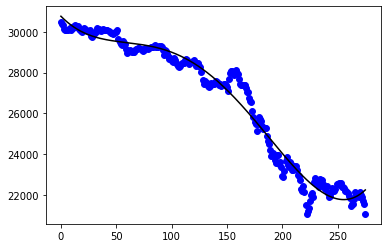



2022-06-15T04:30:00, Close, 21125.94
2022-08-21 16:53:31:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 21421.0
- Closed: -3.9716701329241326
- Opened: 0
- Adjbase: 21421.0
--- Position End
Open Orders: 
2022-06-15T04:30:00, predict, and max, min 22255.62,  23240.62,21270.63,
Portfolio 84546.42648112084 the other one 84546.42648112084
2022-08-21 16:53:31:  Finding the best model and optimizing time...
2022-08-21 16:53:36:  FInished computing all models... Finding and returning best model
2022-08-21 16:53:36:  Remodeling inaccurate model...
current model value 22205.37171057133 predicted model next value 22257.099300545946


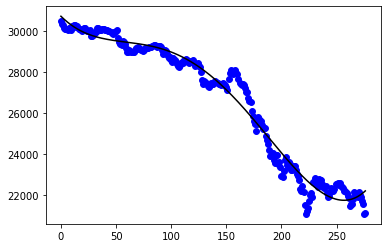



2022-06-15T05:00:00, Close, 20865.46
2022-08-21 16:53:36:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 21421.0
- Closed: -3.9716701329241326
- Opened: 0
- Adjbase: 21421.0
--- Position End
Open Orders: 
2022-06-15T05:00:00, predict, and max, min 22205.37,  23200.75,21209.99,
Portfolio 84546.42648112084 the other one 84546.42648112084
2022-08-21 16:53:36:  Finding the best model and optimizing time...
2022-08-21 16:53:42:  FInished computing all models... Finding and returning best model
2022-08-21 16:53:42:  Remodeling inaccurate model...
current model value 22160.63844579698 predicted model next value 22211.435892188292


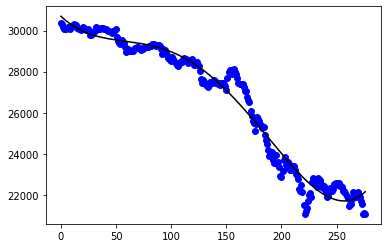



2022-06-15T05:30:00, Close, 21195.68
2022-08-21 16:53:42:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 21421.0
- Closed: -3.9716701329241326
- Opened: 0
- Adjbase: 21421.0
--- Position End
Open Orders: 
2022-06-15T05:30:00, predict, and max, min 22160.64,  23163.59,21157.69,
Portfolio 84546.42648112084 the other one 84546.42648112084
2022-08-21 16:53:42:  In Uptrend
buy value 21761.384629423534
2022-06-15T05:30:00, BUY CREATE, 21195.68 and now rebalancing portfolio
current model value 22211.435892188292 predicted model next value 22265.280905151503


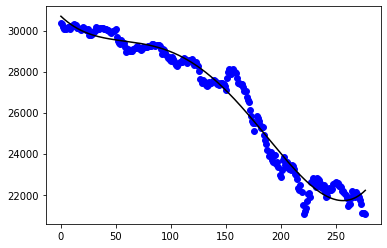

2022-06-15T06:00:00, BUY EXECUTED, Price: 21195.68, Costed Total Of: 83700.96, Comm 0.00


2022-06-15T06:00:00, Close, 21060.39
2022-08-21 16:53:42:  --- Position Begin
- Size: 3.9489632895151106
- Price: 21195.68
- Price orig: 0.0
- Closed: 0
- Opened: 3.9489632895151106
- Adjbase: 21060.39
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        3.9489632895151106
-----Order price:        None
-----Order Type:        5
-----Trail Amount:        350
-----Trail Percent:        None
-----Created Price:        20845.68
-----Is Buy:        False
2022-06-15T06:00:00, predict, and max, min 22211.44,  23222.14,21200.73,
Portfolio 84012.17123768234 the other one 845.4642648112058
2022-08-21 16:53:42:  Finding the best model and optimizing time...
2022-08-21 16:53:47:  FInished computing all models... Finding and returning best model
2022-08-21 16:53:47:  Remodeling inaccurate model...
2022-08-21 16:53:48:  Close all long positions here
current model value 22080.15

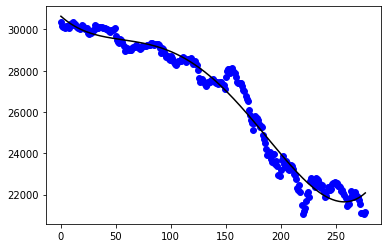

2022-06-15T06:30:00, Order Canceled
2022-06-15T06:30:00, SELL EXECUTED, Price: 21060.39, Costed Total Of: 83700.96, Comm 0.00
2022-06-15T06:30:00, OPERATION PROFIT, GROSS -534.26, NET -534.26


2022-06-15T06:30:00, Close, 21320.07
2022-08-21 16:53:48:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 21195.68
- Closed: -3.9489632895151106
- Opened: 0
- Adjbase: 21060.39
--- Position End
Open Orders: 
2022-06-15T06:30:00, predict, and max, min 22080.15,  23092.54,21067.77,
Portfolio 84012.17123768234 the other one 84012.17123768234
2022-08-21 16:53:48:  In Uptrend
buy value 21673.23810184724
2022-06-15T06:30:00, BUY CREATE, 21320.07 and now rebalancing portfolio
current model value 22129.308510208582 predicted model next value 22181.417451188034


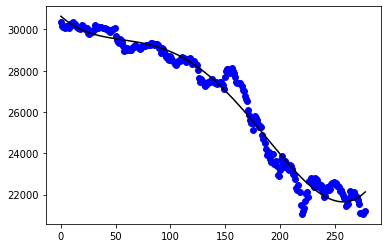

2022-06-15T07:00:00, BUY EXECUTED, Price: 21320.07, Costed Total Of: 83172.05, Comm 0.00


2022-06-15T07:00:00, Close, 21059.32
2022-08-21 16:53:48:  --- Position Begin
- Size: 3.901115217975622
- Price: 21320.07
- Price orig: 0.0
- Closed: 0
- Opened: 3.901115217975622
- Adjbase: 21059.32
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        3.901115217975622
-----Order price:        None
-----Order Type:        5
-----Trail Amount:        350
-----Trail Percent:        None
-----Created Price:        20970.07
-----Is Buy:        False
2022-06-15T07:00:00, predict, and max, min 22129.31,  23144.54,21114.07,
Portfolio 82994.9554445952 the other one 840.1217123768292
2022-08-21 16:53:48:  Finding the best model and optimizing time...
2022-08-21 16:53:53:  FInished computing all models... Finding and returning best model
2022-08-21 16:53:53:  Remodeling inaccurate model...
2022-08-21 16:53:54:  Close all long positions here
current model value 22027.515203

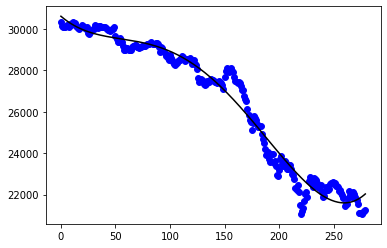

2022-06-15T07:30:00, Order Canceled
2022-06-15T07:30:00, SELL EXECUTED, Price: 21059.32, Costed Total Of: 83172.05, Comm 0.00
2022-06-15T07:30:00, OPERATION PROFIT, GROSS -1017.22, NET -1017.22


2022-06-15T07:30:00, Close, 20693.82
2022-08-21 16:53:54:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 21320.07
- Closed: -3.901115217975622
- Opened: 0
- Adjbase: 21059.32
--- Position End
Open Orders: 
2022-06-15T07:30:00, predict, and max, min 22027.52,  23042.71,21012.32,
Portfolio 82994.9554445952 the other one 82994.9554445952
2022-08-21 16:53:54:  Finding the best model and optimizing time...
2022-08-21 16:53:59:  FInished computing all models... Finding and returning best model
2022-08-21 16:53:59:  Remodeling inaccurate model...
current model value 21977.175858781564 predicted model next value 22024.454456766143


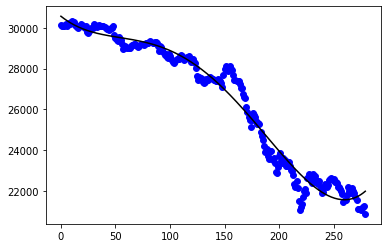



2022-06-15T08:00:00, Close, 20430.48
2022-08-21 16:53:59:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 21320.07
- Closed: -3.901115217975622
- Opened: 0
- Adjbase: 21059.32
--- Position End
Open Orders: 
2022-06-15T08:00:00, predict, and max, min 21977.18,  23002.38,20951.98,
Portfolio 82994.9554445952 the other one 82994.9554445952
2022-08-21 16:53:59:  Finding the best model and optimizing time...
2022-08-21 16:54:04:  FInished computing all models... Finding and returning best model
2022-08-21 16:54:04:  Remodeling inaccurate model...
current model value 20556.510622028534 predicted model next value 20402.777863508436


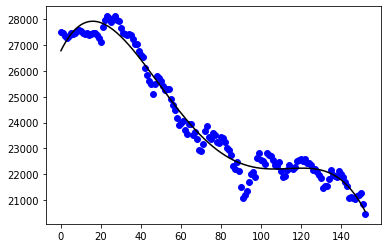



2022-06-15T08:30:00, Close, 20223.71
2022-08-21 16:54:04:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 21320.07
- Closed: -3.901115217975622
- Opened: 0
- Adjbase: 21059.32
--- Position End
Open Orders: 
2022-06-15T08:30:00, predict, and max, min 20556.51,  21219.25,19893.77,
Portfolio 82994.9554445952 the other one 82994.9554445952
2022-08-21 16:54:04:  In Downtrend
2022-06-15: Limit Order / Buy at 20079.047978871964
2022-06-15: Limit Order / Sell at 20689.16315286363
current model value 20402.777863508436 predicted model next value 20239.57372602545


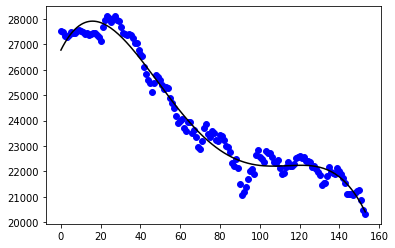



2022-06-15T09:00:00, Close, 20172.03
2022-08-21 16:54:04:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 21320.07
- Closed: -3.901115217975622
- Opened: 0
- Adjbase: 21059.32
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        3.9714030617413645
-----Order price:        20689.16315286363
-----Order Type:        2
-----Trail Amount:        None
-----Trail Percent:        None
-----Created Price:        20689.16315286363
-----Is Buy:        False
-----Asset:             BTCUSD
-----Order Size:        4.092076774586464
-----Order price:        20079.047978871964
-----Order Type:        2
-----Trail Amount:        None
-----Trail Percent:        None
-----Created Price:        20079.047978871964
-----Is Buy:        True
2022-06-15T09:00:00, predict, and max, min 20402.78,  21065.82,19739.74,
Portfolio 82994.9554445952 the other one 82994.9554445952
2022-08-21 16:54:04:  In Downtrend
2022-06-15: Limit Order / Buy at 19915.755803665656
2022-06-

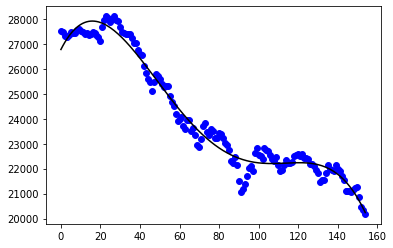

2022-06-15T09:30:00, ORDER EXPIRED
2022-06-15T09:30:00, Order Canceled


2022-06-15T09:30:00, Close, 20203.36
2022-08-21 16:54:05:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 21320.07
- Closed: -3.901115217975622
- Opened: 0
- Adjbase: 21059.32
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        4.002964931866927
-----Order price:        20526.036897312668
-----Order Type:        2
-----Trail Amount:        None
-----Trail Percent:        None
-----Created Price:        20526.036897312668
-----Is Buy:        False
-----Asset:             BTCUSD
-----Order Size:        4.125628306560483
-----Order price:        19915.755803665656
-----Order Type:        2
-----Trail Amount:        None
-----Trail Percent:        None
-----Created Price:        19915.755803665656
-----Is Buy:        True
2022-06-15T09:30:00, predict, and max, min 20239.57,  20903.44,19575.70,
Portfolio 82994.9554445952 the other one 82994.9554445952
2022-08-21 16:54:05:  I

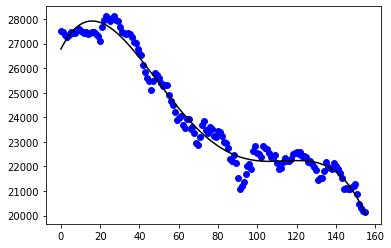

2022-06-15T10:00:00, ORDER EXPIRED
2022-06-15T10:00:00, Order Canceled
Limit ordering
2022-06-15T10:00:00, SELL EXECUTED, Price: 20353.24, Costed Total Of: 82165.01, Comm 0.00
2022-06-15T10:00:00, Order Canceled


2022-06-15T10:00:00, Close, 20477.03
2022-08-21 16:54:05:  --- Position Begin
- Size: -4.036949449868917
- Price: 20353.241206133313
- Price orig: 0.0
- Closed: 0
- Opened: -4.036949449868917
- Adjbase: 20477.03
--- Position End
Open Orders: 
2022-06-15T10:00:00, predict, and max, min 20066.56,  20730.47,19402.66,
Portfolio 82495.22634129514 the other one 829.9495544459496
2022-08-21 16:54:05:  In Downtrend
sell value 20170.09351455745
current model value 19883.406432816 predicted model next value 19689.75926980894


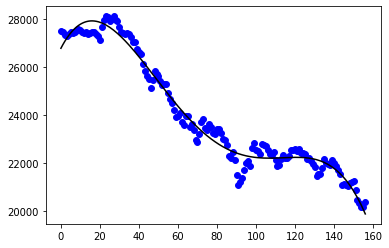



2022-06-15T10:30:00, Close, 20539.38
2022-08-21 16:54:05:  --- Position Begin
- Size: -4.036949449868917
- Price: 20353.241206133313
- Price orig: 0.0
- Closed: 0
- Opened: -4.036949449868917
- Adjbase: 20539.38
--- Position End
Open Orders: 
2022-06-15T10:30:00, predict, and max, min 19883.41,  20546.93,19219.88,
Portfolio 82243.52254309581 the other one 829.9495544459496
2022-08-21 16:54:05:  In Downtrend
sell value 19976.348039127573
current model value 19689.75926980894 predicted model next value 19485.272713277936


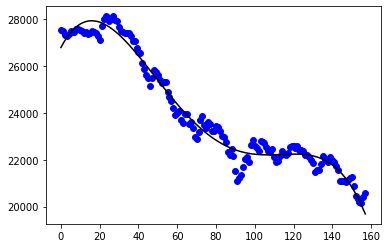



2022-06-15T11:00:00, Close, 20950.17
2022-08-21 16:54:05:  --- Position Begin
- Size: -4.036949449868917
- Price: 20353.241206133313
- Price orig: 0.0
- Closed: 0
- Opened: -4.036949449868917
- Adjbase: 20950.17
--- Position End
Open Orders: 
2022-06-15T11:00:00, predict, and max, min 19689.76,  20364.43,19015.08,
Portfolio 80585.18407858416 the other one 829.9495544459496
2022-08-21 16:54:05:  Finding the best model and optimizing time...
2022-08-21 16:54:10:  FInished computing all models... Finding and returning best model
2022-08-21 16:54:10:  Remodeling inaccurate model...
2022-08-21 16:54:10:  Close all short positions here
current model value 20678.489637906463 predicted model next value 20653.774551802486


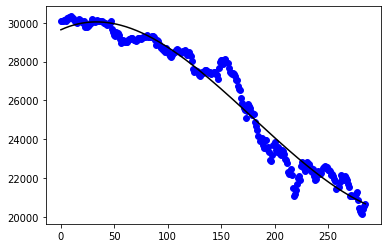

2022-06-15T11:30:00, BUY EXECUTED, Price: 20950.17, Costed Total Of: 82165.01, Comm 0.00
2022-06-15T11:30:00, OPERATION PROFIT, GROSS -2409.77, NET -2409.77


2022-06-15T11:30:00, Close, 21143.66
2022-08-21 16:54:10:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 20353.241206133313
- Closed: 4.036949449868917
- Opened: 0
- Adjbase: 20950.17
--- Position End
Open Orders: 
2022-06-15T11:30:00, predict, and max, min 20678.49,  21919.48,19437.50,
Portfolio 80585.18407858416 the other one 80585.18407858416
2022-08-21 16:54:10:  In Downtrend
2022-06-15: Limit Order / Buy at 20098.58643396767
2022-06-15: Limit Order / Sell at 21177.148987823424
current model value 20653.774551802486 predicted model next value 20629.55354042329


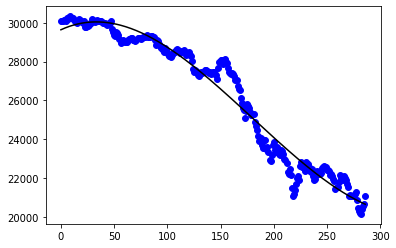

Limit ordering
2022-06-15T12:00:00, SELL EXECUTED, Price: 21177.15, Costed Total Of: 79779.33, Comm 0.00
2022-06-15T12:00:00, Order Canceled


2022-06-15T12:00:00, Close, 21178.60
2022-08-21 16:54:10:  --- Position Begin
- Size: -3.7672366702274402
- Price: 21177.148987823424
- Price orig: 0.0
- Closed: 0
- Opened: -3.7672366702274402
- Adjbase: 21178.6
--- Position End
Open Orders: 
2022-06-15T12:00:00, predict, and max, min 20653.77,  21892.60,19414.94,
Portfolio 80579.71777230363 the other one 805.8518407858355
2022-08-21 16:54:10:  In Downtrend
sell value 21152.381964045984
current model value 20629.55354042329 predicted model next value 20605.831276381217


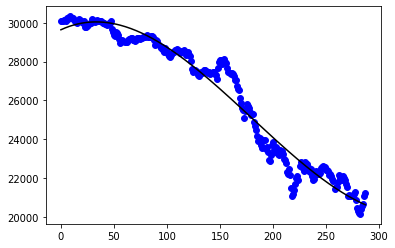



2022-06-15T12:30:00, Close, 21165.75
2022-08-21 16:54:10:  --- Position Begin
- Size: -3.7672366702274402
- Price: 21177.148987823424
- Price orig: 0.0
- Closed: 0
- Opened: -3.7672366702274402
- Adjbase: 21165.75
--- Position End
Open Orders: 
2022-06-15T12:30:00, predict, and max, min 20629.55,  21866.61,19392.50,
Portfolio 80628.12676351605 the other one 805.8518407858355
2022-08-21 16:54:10:  In Downtrend
sell value 21128.2110173146
current model value 20605.831276381217 predicted model next value 20582.61243228863


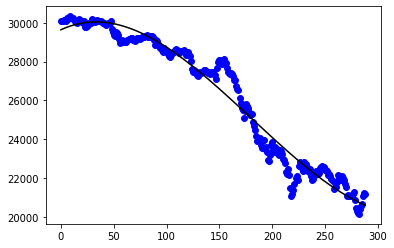



2022-06-15T13:00:00, Close, 21396.01
2022-08-21 16:54:10:  --- Position Begin
- Size: -3.7672366702274402
- Price: 21177.148987823424
- Price orig: 0.0
- Closed: 0
- Opened: -3.7672366702274402
- Adjbase: 21396.01
--- Position End
Open Orders: 
2022-06-15T13:00:00, predict, and max, min 20605.83,  21841.03,19370.64,
Portfolio 79760.68284782948 the other one 805.8518407858355
2022-08-21 16:54:10:  In Downtrend
sell value 21103.62807931829
current model value 20582.61243228863 predicted model next value 20559.901680757885


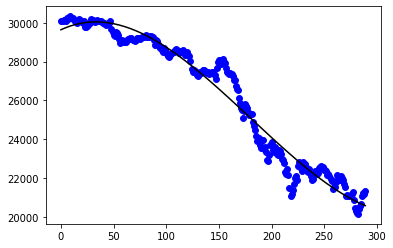



2022-06-15T13:30:00, Close, 21527.32
2022-08-21 16:54:11:  --- Position Begin
- Size: -3.7672366702274402
- Price: 21177.148987823424
- Price orig: 0.0
- Closed: 0
- Opened: -3.7672366702274402
- Adjbase: 21527.32
--- Position End
Open Orders: 
2022-06-15T13:30:00, predict, and max, min 20582.61,  21817.01,19348.22,
Portfolio 79266.0070006619 the other one 805.8518407858355
2022-08-21 16:54:11:  In Downtrend
sell value 21080.7145563773
current model value 20559.901680757885 predicted model next value 20537.70369440135


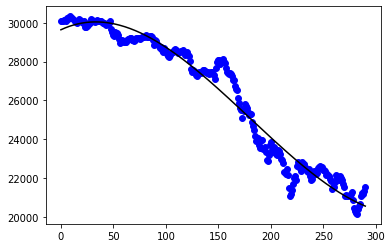



2022-06-15T14:00:00, Close, 21359.52
2022-08-21 16:54:11:  --- Position Begin
- Size: -3.7672366702274402
- Price: 21177.148987823424
- Price orig: 0.0
- Closed: 0
- Opened: -3.7672366702274402
- Adjbase: 21359.52
--- Position End
Open Orders: 
2022-06-15T14:00:00, predict, and max, min 20559.90,  21795.41,19324.39,
Portfolio 79898.14931392607 the other one 805.8518407858355
2022-08-21 16:54:11:  In Downtrend
sell value 21058.799811726072
current model value 20537.70369440135 predicted model next value 20516.023145831372


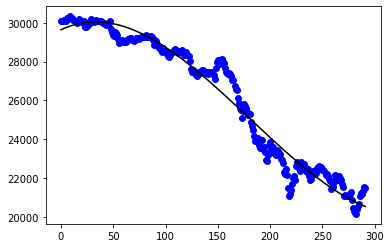



2022-06-15T14:30:00, Close, 21184.11
2022-08-21 16:54:11:  --- Position Begin
- Size: -3.7672366702274402
- Price: 21177.148987823424
- Price orig: 0.0
- Closed: 0
- Opened: -3.7672366702274402
- Adjbase: 21184.11
--- Position End
Open Orders: 
2022-06-15T14:30:00, predict, and max, min 20537.70,  21774.14,19301.26,
Portfolio 80558.96029825066 the other one 805.8518407858355
2022-08-21 16:54:11:  In Downtrend
sell value 21039.79080358071
current model value 20516.023145831372 predicted model next value 20494.864707660312


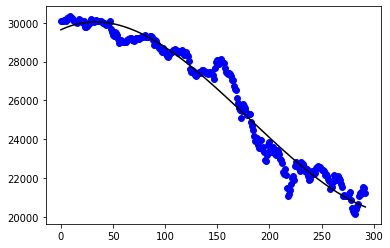



2022-06-15T15:00:00, Close, 21212.45
2022-08-21 16:54:11:  --- Position Begin
- Size: -3.7672366702274402
- Price: 21177.148987823424
- Price orig: 0.0
- Closed: 0
- Opened: -3.7672366702274402
- Adjbase: 21212.45
--- Position End
Open Orders: 
2022-06-15T15:00:00, predict, and max, min 20516.02,  21751.20,19280.85,
Portfolio 80452.19681101642 the other one 805.8518407858355
2022-08-21 16:54:11:  In Downtrend
sell value 21018.311040829423
current model value 20494.864707660312 predicted model next value 20474.23305250053


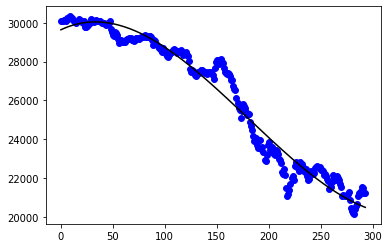



2022-06-15T15:30:00, Close, 21391.53
2022-08-21 16:54:11:  --- Position Begin
- Size: -3.7672366702274402
- Price: 21177.148987823424
- Price orig: 0.0
- Closed: 0
- Opened: -3.7672366702274402
- Adjbase: 21391.53
--- Position End
Open Orders: 
2022-06-15T15:30:00, predict, and max, min 20494.86,  21729.02,19260.71,
Portfolio 79777.5600681121 the other one 805.8518407858355
2022-08-21 16:54:11:  In Downtrend
sell value 20997.41963202185
current model value 20474.23305250053 predicted model next value 20454.132852964387


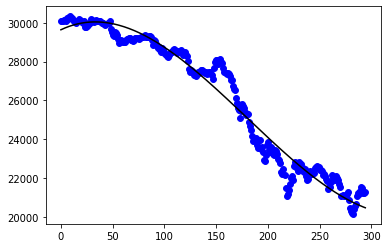



2022-06-15T16:00:00, Close, 21182.59
2022-08-21 16:54:11:  --- Position Begin
- Size: -3.7672366702274402
- Price: 21177.148987823424
- Price orig: 0.0
- Closed: 0
- Opened: -3.7672366702274402
- Adjbase: 21182.59
--- Position End
Open Orders: 
2022-06-15T16:00:00, predict, and max, min 20474.23,  21707.84,19240.63,
Portfolio 80564.68649798942 the other one 805.8518407858355
2022-08-21 16:54:11:  In Downtrend
sell value 20977.17989334173
current model value 20454.132852964387 predicted model next value 20434.56878166424


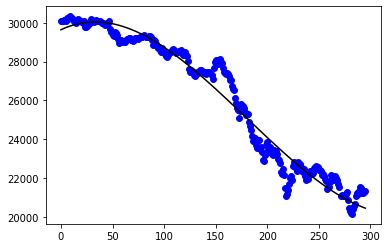



2022-06-15T16:30:00, Close, 20691.55
2022-08-21 16:54:11:  --- Position Begin
- Size: -3.7672366702274402
- Price: 21177.148987823424
- Price orig: 0.0
- Closed: 0
- Opened: -3.7672366702274402
- Adjbase: 20691.55
--- Position End
Open Orders: 
2022-06-15T16:30:00, predict, and max, min 20454.13,  21687.77,19220.50,
Portfolio 82414.5503925379 the other one 805.8518407858355
2022-08-21 16:54:11:  In Downtrend
2022-06-15: Limit Order / Buy at 19883.879568332355
2022-06-15: Limit Order / Sell at 20957.622499349134
current model value 20434.56878166424 predicted model next value 20415.545511212436


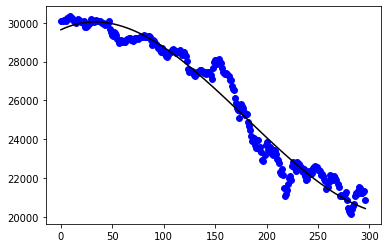

2022-06-15T17:00:00, Insufficient Margin for order of type 2
2022-06-15T17:00:00, Order Canceled


2022-06-15T17:00:00, Close, 20624.30
2022-08-21 16:54:11:  --- Position Begin
- Size: -3.7672366702274402
- Price: 21177.148987823424
- Price orig: 0.0
- Closed: 0
- Opened: -3.7672366702274402
- Adjbase: 20624.3
--- Position End
Open Orders: 
2022-06-15T17:00:00, predict, and max, min 20434.57,  21666.14,19203.00,
Portfolio 82667.89705861069 the other one 805.8518407858355
2022-08-21 16:54:11:  In Downtrend
2022-06-15: Limit Order / Buy at 19865.409234349263
2022-06-15: Limit Order / Sell at 20939.26365827066
current model value 20415.545511212436 predicted model next value 20397.067714221346


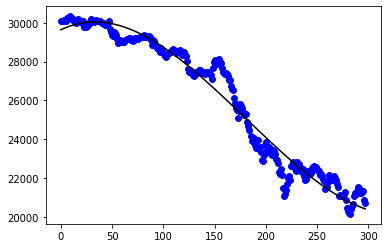

2022-06-15T17:30:00, Insufficient Margin for order of type 2
2022-06-15T17:30:00, Order Canceled


2022-06-15T17:30:00, Close, 21068.50
2022-08-21 16:54:11:  --- Position Begin
- Size: -3.7672366702274402
- Price: 21177.148987823424
- Price orig: 0.0
- Closed: 0
- Opened: -3.7672366702274402
- Adjbase: 21068.5
--- Position End
Open Orders: 
2022-06-15T17:30:00, predict, and max, min 20415.55,  21645.32,19185.77,
Portfolio 80994.49052969566 the other one 805.8518407858355
2022-08-21 16:54:11:  In Downtrend
sell value 20920.32722016602
current model value 20397.067714221346 predicted model next value 20379.140063303326


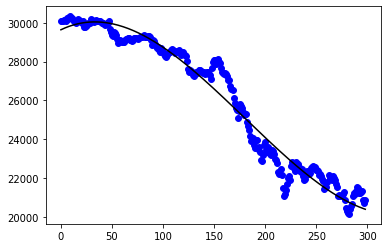



2022-06-15T18:00:00, Close, 20726.52
2022-08-21 16:54:12:  --- Position Begin
- Size: -3.7672366702274402
- Price: 21177.148987823424
- Price orig: 0.0
- Closed: 0
- Opened: -3.7672366702274402
- Adjbase: 20726.52
--- Position End
Open Orders: 
2022-06-15T18:00:00, predict, and max, min 20397.07,  21624.78,19169.35,
Portfolio 82282.81012618003 the other one 805.8518407858355
2022-08-21 16:54:12:  In Downtrend
2022-06-15: Limit Order / Buy at 19831.65199313201
2022-06-15: Limit Order / Sell at 20901.87409807046
current model value 20379.140063303326 predicted model next value 20361.76723107074


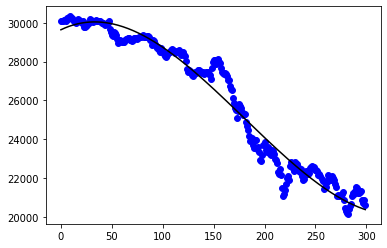

2022-06-15T18:30:00, Insufficient Margin for order of type 2
2022-06-15T18:30:00, Order Canceled


2022-06-15T18:30:00, Close, 21519.86
2022-08-21 16:54:12:  --- Position Begin
- Size: -3.7672366702274402
- Price: 21177.148987823424
- Price orig: 0.0
- Closed: 0
- Opened: -3.7672366702274402
- Adjbase: 21519.86
--- Position End
Open Orders: 
2022-06-15T18:30:00, predict, and max, min 20379.14,  21605.39,19152.89,
Portfolio 79294.1105862218 the other one 805.8518407858355
2022-08-21 16:54:12:  In Downtrend
sell value 20882.685766421786
current model value 20361.76723107074 predicted model next value 20344.95389013593


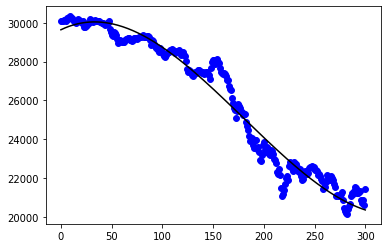



2022-06-15T19:00:00, Close, 21886.23
2022-08-21 16:54:12:  --- Position Begin
- Size: -3.7672366702274402
- Price: 21177.148987823424
- Price orig: 0.0
- Closed: 0
- Opened: -3.7672366702274402
- Adjbase: 21886.23
--- Position End
Open Orders: 
2022-06-15T19:00:00, predict, and max, min 20361.77,  21590.63,19132.91,
Portfolio 77913.90808735057 the other one 805.8518407858355
2022-08-21 16:54:12:  Finding the best model and optimizing time...
2022-08-21 16:54:17:  FInished computing all models... Finding and returning best model
2022-08-21 16:54:17:  Remodeling inaccurate model...
2022-08-21 16:54:17:  Close all short positions here
current model value 20550.82783953499 predicted model next value 20532.326897427756


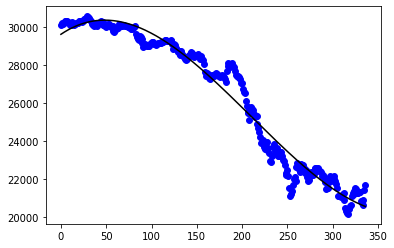

2022-06-15T19:30:00, BUY EXECUTED, Price: 21886.23, Costed Total Of: 79779.33, Comm 0.00
2022-06-15T19:30:00, OPERATION PROFIT, GROSS -2671.28, NET -2671.28


2022-06-15T19:30:00, Close, 21591.21
2022-08-21 16:54:17:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 21177.148987823424
- Closed: 3.7672366702274402
- Opened: 0
- Adjbase: 21886.23
--- Position End
Open Orders: 
2022-06-15T19:30:00, predict, and max, min 20550.83,  21787.13,19314.53,
Portfolio 77913.90808735057 the other one 77913.90808735057
2022-08-21 16:54:17:  In Downtrend
sell value 21052.816143741613
2022-06-15T19:30:00, SELL CREATE, 21591.21 and now rebalancing portfolio
current model value 20532.326897427756 predicted model next value 20514.281377489926


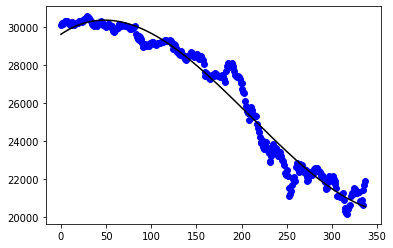

2022-06-15T20:00:00, SELL EXECUTED, Price: 21591.21, Costed Total Of: 77134.77, Comm 0.00


2022-06-15T20:00:00, Close, 21588.65
2022-08-21 16:54:17:  --- Position Begin
- Size: -3.5725079329262726
- Price: 21591.21
- Price orig: 0.0
- Closed: 0
- Opened: -3.5725079329262726
- Adjbase: 21588.65
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        3.5725079329262726
-----Order price:        None
-----Order Type:        5
-----Trail Amount:        350
-----Trail Percent:        None
-----Created Price:        21938.65
-----Is Buy:        True
2022-06-15T20:00:00, predict, and max, min 20532.33,  21775.31,19289.35,
Portfolio 77923.05370765885 the other one 779.1390808735159
2022-08-21 16:54:17:  In Downtrend
sell value 21036.456473415914
current model value 20514.281377489926 predicted model next value 20496.69487344125


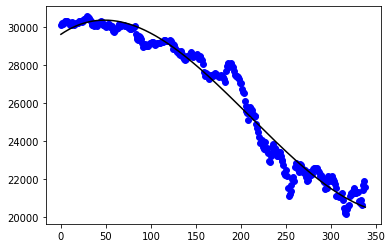



2022-06-15T20:30:00, Close, 21638.72
2022-08-21 16:54:17:  --- Position Begin
- Size: -3.5725079329262726
- Price: 21591.21
- Price orig: 0.0
- Closed: 0
- Opened: -3.5725079329262726
- Adjbase: 21638.72
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        3.5725079329262726
-----Order price:        None
-----Order Type:        5
-----Trail Amount:        350
-----Trail Percent:        None
-----Created Price:        21938.65
-----Is Buy:        True
2022-06-15T20:30:00, predict, and max, min 20514.28,  21759.37,19269.20,
Portfolio 77744.17823545724 the other one 779.1390808735159
2022-08-21 16:54:17:  In Downtrend
sell value 21027.681229957645
current model value 20496.69487344125 predicted model next value 20479.570979001546


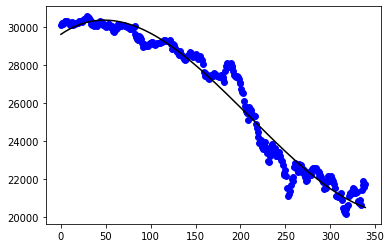



2022-06-15T21:00:00, Close, 21869.96
2022-08-21 16:54:17:  --- Position Begin
- Size: -3.5725079329262726
- Price: 21591.21
- Price orig: 0.0
- Closed: 0
- Opened: -3.5725079329262726
- Adjbase: 21869.96
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        3.5725079329262726
-----Order price:        None
-----Order Type:        5
-----Trail Amount:        350
-----Trail Percent:        None
-----Created Price:        21938.65
-----Is Buy:        True
2022-06-15T21:00:00, predict, and max, min 20496.69,  21746.26,19247.13,
Portfolio 76918.07150104738 the other one 779.1390808735159
2022-08-21 16:54:17:  Finding the best model and optimizing time...
2022-08-21 16:54:22:  FInished computing all models... Finding and returning best model
2022-08-21 16:54:22:  Remodeling inaccurate model...
2022-08-21 16:54:22:  Close all short positions here
current model value 20761.76088254633 predicted model next value 20752.74737382533


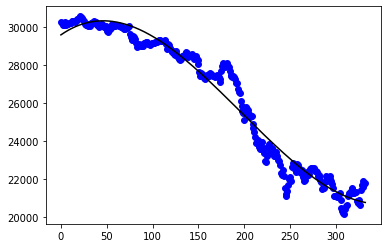

2022-06-15T21:30:00, Order Canceled
2022-06-15T21:30:00, BUY EXECUTED, Price: 21869.96, Costed Total Of: 77134.77, Comm 0.00
2022-06-15T21:30:00, OPERATION PROFIT, GROSS -995.84, NET -995.84


2022-06-15T21:30:00, Close, 22183.04
2022-08-21 16:54:23:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 21591.21
- Closed: 3.5725079329262726
- Opened: 0
- Adjbase: 21869.96
--- Position End
Open Orders: 
2022-06-15T21:30:00, predict, and max, min 20761.76,  22001.41,19522.11,
Portfolio 76918.07150104738 the other one 76918.07150104738
2022-08-21 16:54:23:  Finding the best model and optimizing time...
2022-08-21 16:54:28:  FInished computing all models... Finding and returning best model
2022-08-21 16:54:28:  Remodeling inaccurate model...
current model value 21606.866373388588 predicted model next value 21641.717265263313


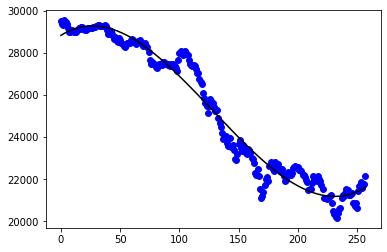



2022-06-15T22:00:00, Close, 22610.68
2022-08-21 16:54:28:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 21591.21
- Closed: 3.5725079329262726
- Opened: 0
- Adjbase: 21869.96
--- Position End
Open Orders: 
2022-06-15T22:00:00, predict, and max, min 21606.87,  22762.33,20451.40,
Portfolio 76918.07150104738 the other one 76918.07150104738
2022-08-21 16:54:28:  In Uptrend
2022-06-15: Limit Order / Buy at 21121.789075518653
2022-06-15: Limit Order / Sell at 22131.995498478864
current model value 21641.717265263313 predicted model next value 21678.03907362876


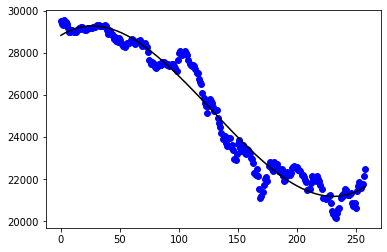

2022-06-15T22:30:00, Insufficient Margin for order of type 2
2022-06-15T22:30:00, Order Canceled


2022-06-15T22:30:00, Close, 22451.45
2022-08-21 16:54:28:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 21591.21
- Closed: 3.5725079329262726
- Opened: 0
- Adjbase: 21869.96
--- Position End
Open Orders: 
2022-06-15T22:30:00, predict, and max, min 21641.72,  22797.55,20485.89,
Portfolio 76918.07150104738 the other one 76918.07150104738
2022-08-21 16:54:28:  In Uptrend
2022-06-15: Limit Order / Buy at 21158.012102235643
2022-06-15: Limit Order / Sell at 22168.410455269484
current model value 21678.03907362876 predicted model next value 21715.843182413904


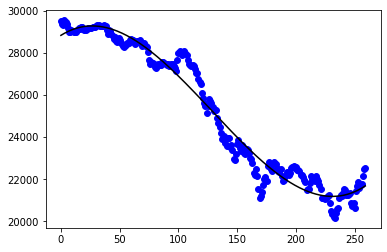

2022-06-15T23:00:00, Insufficient Margin for order of type 2
2022-06-15T23:00:00, Order Canceled


2022-06-15T23:00:00, Close, 22600.42
2022-08-21 16:54:28:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 21591.21
- Closed: 3.5725079329262726
- Opened: 0
- Adjbase: 21869.96
--- Position End
Open Orders: 
2022-06-15T23:00:00, predict, and max, min 21678.04,  22834.45,20521.63,
Portfolio 76918.07150104738 the other one 76918.07150104738
2022-08-21 16:54:28:  In Uptrend
2022-06-15: Limit Order / Buy at 21195.659539749435
2022-06-15: Limit Order / Sell at 22206.36230082988
current model value 21715.843182413904 predicted model next value 21755.1409755477


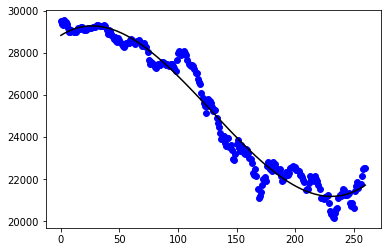

2022-06-15T23:30:00, Insufficient Margin for order of type 2
2022-06-15T23:30:00, Order Canceled


2022-06-15T23:30:00, Close, 22562.33
2022-08-21 16:54:29:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 21591.21
- Closed: 3.5725079329262726
- Opened: 0
- Adjbase: 21869.96
--- Position End
Open Orders: 
2022-06-15T23:30:00, predict, and max, min 21715.84,  22872.40,20559.29,
Portfolio 76918.07150104738 the other one 76918.07150104738
2022-08-21 16:54:29:  In Uptrend
2022-06-15: Limit Order / Buy at 21234.917922297944
2022-06-15: Limit Order / Sell at 22245.69725708063
current model value 21755.1409755477 predicted model next value 21795.943836959137


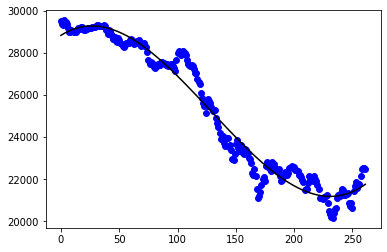

2022-06-16T00:00:00, Insufficient Margin for order of type 2
2022-06-16T00:00:00, Order Canceled


2022-06-16T00:00:00, Close, 22541.29
2022-08-21 16:54:29:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 21591.21
- Closed: 3.5725079329262726
- Opened: 0
- Adjbase: 21869.96
--- Position End
Open Orders: 
2022-06-16T00:00:00, predict, and max, min 21755.14,  22911.02,20599.26,
Portfolio 76918.07150104738 the other one 76918.07150104738
2022-08-21 16:54:29:  In Uptrend
2022-06-16: Limit Order / Buy at 21275.902481343495
2022-06-16: Limit Order / Sell at 22287.71617077654
current model value 21795.943836959137 predicted model next value 21838.263150577142


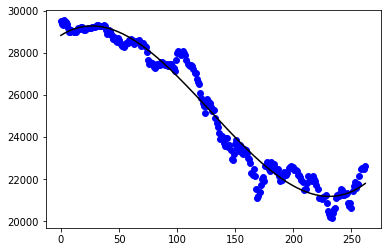

2022-06-16T00:30:00, Insufficient Margin for order of type 2
2022-06-16T00:30:00, Order Canceled


2022-06-16T00:30:00, Close, 22655.83
2022-08-21 16:54:29:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 21591.21
- Closed: 3.5725079329262726
- Opened: 0
- Adjbase: 21869.96
--- Position End
Open Orders: 
2022-06-16T00:30:00, predict, and max, min 21795.94,  22952.10,20639.79,
Portfolio 76918.07150104738 the other one 76918.07150104738
2022-08-21 16:54:29:  In Uptrend
2022-06-16: Limit Order / Buy at 21318.749490644288
2022-06-16: Limit Order / Sell at 22330.104844282512
current model value 21838.263150577142 predicted model next value 21882.11030033072


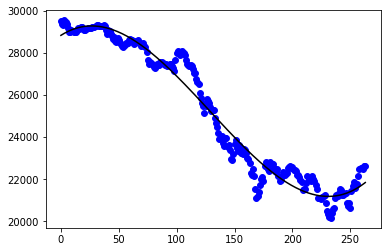

2022-06-16T01:00:00, Insufficient Margin for order of type 2
2022-06-16T01:00:00, Order Canceled


2022-06-16T01:00:00, Close, 22665.42
2022-08-21 16:54:29:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 21591.21
- Closed: 3.5725079329262726
- Opened: 0
- Adjbase: 21869.96
--- Position End
Open Orders: 
2022-06-16T01:00:00, predict, and max, min 21838.26,  22993.91,20682.61,
Portfolio 76918.07150104738 the other one 76918.07150104738
2022-08-21 16:54:29:  In Uptrend
2022-06-16: Limit Order / Buy at 21362.732909693746
2022-06-16: Limit Order / Sell at 22375.26329823991
current model value 21882.11030033072 predicted model next value 21927.49667014881


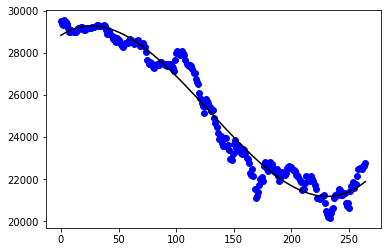

2022-06-16T01:30:00, Insufficient Margin for order of type 2
2022-06-16T01:30:00, Order Canceled


2022-06-16T01:30:00, Close, 22343.42
2022-08-21 16:54:29:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 21591.21
- Closed: 3.5725079329262726
- Opened: 0
- Adjbase: 21869.96
--- Position End
Open Orders: 
2022-06-16T01:30:00, predict, and max, min 21882.11,  23038.79,20725.43,
Portfolio 76918.07150104738 the other one 76918.07150104738
2022-08-21 16:54:29:  In Uptrend
2022-06-16: Limit Order / Buy at 21408.256900145574
2022-06-16: Limit Order / Sell at 22420.912418124008
current model value 21927.49667014881 predicted model next value 21974.43364396038


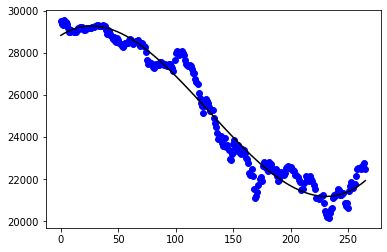

Limit ordering
2022-06-16T02:00:00, SELL EXECUTED, Price: 22420.91, Costed Total Of: 76148.89, Comm 0.00
2022-06-16T02:00:00, Order Canceled


2022-06-16T02:00:00, Close, 22396.46
2022-08-21 16:54:29:  --- Position Begin
- Size: -3.3963332698486317
- Price: 22420.912418124008
- Price orig: 0.0
- Closed: 0
- Opened: -3.3963332698486317
- Adjbase: 22396.46
--- Position End
Open Orders: 
2022-06-16T02:00:00, predict, and max, min 21927.50,  23082.25,20772.74,
Portfolio 77001.1200622502 the other one 769.1807150104723
2022-08-21 16:54:29:  In Uptrend
2022-06-16: Limit Order / Buy at 21455.711689311982
2022-06-16: Limit Order / Sell at 22469.50074317994
current model value 21974.43364396038 predicted model next value 22022.932605694405


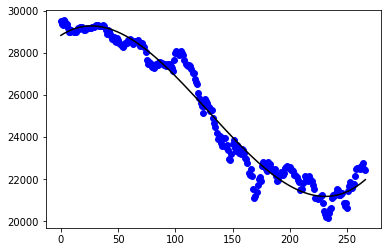

2022-06-16T02:30:00, Insufficient Margin for order of type 2
2022-06-16T02:30:00, Order Canceled


2022-06-16T02:30:00, Close, 22425.45
2022-08-21 16:54:29:  --- Position Begin
- Size: -3.3963332698486317
- Price: 22420.912418124008
- Price orig: 0.0
- Closed: 0
- Opened: -3.3963332698486317
- Adjbase: 22425.45
--- Position End
Open Orders: 
2022-06-16T02:30:00, predict, and max, min 21974.43,  23127.04,20821.83,
Portfolio 76902.66036075728 the other one 769.1807150104723
2022-08-21 16:54:29:  In Uptrend
2022-06-16: Limit Order / Buy at 21504.79030722882
2022-06-16: Limit Order / Sell at 22517.446482320625
current model value 22022.932605694405 predicted model next value 22073.00493927984


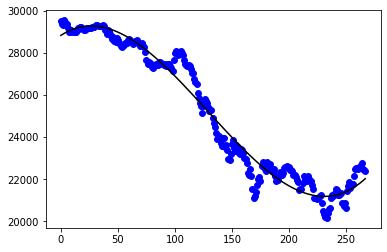

2022-06-16T03:00:00, Insufficient Margin for order of type 2
2022-06-16T03:00:00, Order Canceled


2022-06-16T03:00:00, Close, 22293.60
2022-08-21 16:54:29:  --- Position Begin
- Size: -3.3963332698486317
- Price: 22420.912418124008
- Price orig: 0.0
- Closed: 0
- Opened: -3.3963332698486317
- Adjbase: 22293.6
--- Position End
Open Orders: 
2022-06-16T03:00:00, predict, and max, min 22022.93,  23173.41,20872.45,
Portfolio 77350.46690238683 the other one 769.1807150104723
2022-08-21 16:54:29:  In Uptrend
2022-06-16: Limit Order / Buy at 21555.435722597576
2022-06-16: Limit Order / Sell at 22566.971867905228
current model value 22073.00493927984 predicted model next value 22124.662028645645


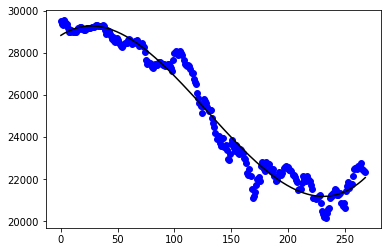

2022-06-16T03:30:00, Insufficient Margin for order of type 2
2022-06-16T03:30:00, Order Canceled


2022-06-16T03:30:00, Close, 22187.15
2022-08-21 16:54:29:  --- Position Begin
- Size: -3.3963332698486317
- Price: 22420.912418124008
- Price orig: 0.0
- Closed: 0
- Opened: -3.3963332698486317
- Adjbase: 22187.15
--- Position End
Open Orders: 
2022-06-16T03:30:00, predict, and max, min 22073.00,  23221.65,20924.36,
Portfolio 77712.0065789622 the other one 769.1807150104723
2022-08-21 16:54:29:  In Uptrend
2022-06-16: Limit Order / Buy at 21607.587303527383
2022-06-16: Limit Order / Sell at 22618.15701560366
current model value 22124.662028645645 predicted model next value 22177.915257720808


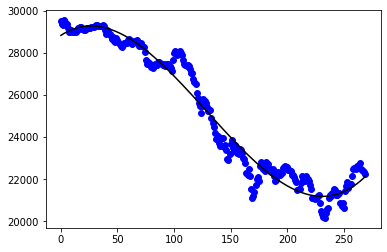

2022-06-16T04:00:00, Insufficient Margin for order of type 2
2022-06-16T04:00:00, Order Canceled


2022-06-16T04:00:00, Close, 22304.60
2022-08-21 16:54:30:  --- Position Begin
- Size: -3.3963332698486317
- Price: 22420.912418124008
- Price orig: 0.0
- Closed: 0
- Opened: -3.3963332698486317
- Adjbase: 22304.6
--- Position End
Open Orders: 
2022-06-16T04:00:00, predict, and max, min 22124.66,  23272.48,20976.84,
Portfolio 77313.1072364185 the other one 769.1807150104723
2022-08-21 16:54:30:  In Uptrend
2022-06-16: Limit Order / Buy at 21661.064800993525
2022-06-16: Limit Order / Sell at 22671.196203416886
current model value 22177.915257720808 predicted model next value 22232.776010434274


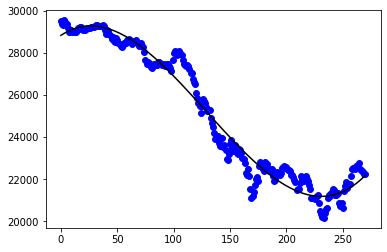

2022-06-16T04:30:00, Insufficient Margin for order of type 2
2022-06-16T04:30:00, Order Canceled


2022-06-16T04:30:00, Close, 22072.04
2022-08-21 16:54:30:  --- Position Begin
- Size: -3.3963332698486317
- Price: 22420.912418124008
- Price orig: 0.0
- Closed: 0
- Opened: -3.3963332698486317
- Adjbase: 22072.04
--- Position End
Open Orders: 
2022-06-16T04:30:00, predict, and max, min 22177.92,  23325.35,21030.48,
Portfolio 78102.95850165449 the other one 769.1807150104723
2022-08-21 16:54:30:  In Uptrend
2022-06-16: Limit Order / Buy at 21716.988613816895
2022-06-16: Limit Order / Sell at 22725.958285212793
current model value 22232.776010434274 predicted model next value 22289.255670715014


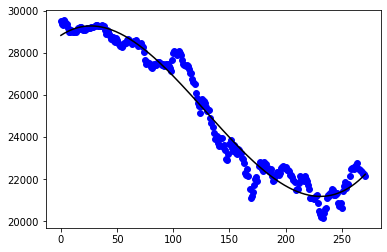

2022-06-16T05:00:00, Insufficient Margin for order of type 2
2022-06-16T05:00:00, Order Canceled


2022-06-16T05:00:00, Close, 22138.34
2022-08-21 16:54:30:  --- Position Begin
- Size: -3.3963332698486317
- Price: 22420.912418124008
- Price orig: 0.0
- Closed: 0
- Opened: -3.3963332698486317
- Adjbase: 22138.34
--- Position End
Open Orders: 
2022-06-16T05:00:00, predict, and max, min 22232.78,  23379.81,21085.74,
Portfolio 77877.78160586352 the other one 769.1807150104723
2022-08-21 16:54:30:  In Uptrend
2022-06-16: Limit Order / Buy at 21773.576565495518
2022-06-16: Limit Order / Sell at 22781.65770234478
current model value 22289.255670715014 predicted model next value 22347.365622491998


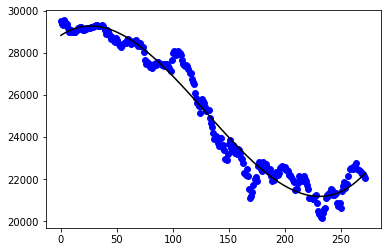

2022-06-16T05:30:00, Insufficient Margin for order of type 2
2022-06-16T05:30:00, Order Canceled


2022-06-16T05:30:00, Close, 21912.05
2022-08-21 16:54:30:  --- Position Begin
- Size: -3.3963332698486317
- Price: 22420.912418124008
- Price orig: 0.0
- Closed: 0
- Opened: -3.3963332698486317
- Adjbase: 21912.05
--- Position End
Open Orders: 
2022-06-16T05:30:00, predict, and max, min 22289.26,  23434.75,21143.76,
Portfolio 78646.33786149758 the other one 769.1807150104723
2022-08-21 16:54:30:  In Uptrend
2022-06-16: Limit Order / Buy at 21832.102366512412
2022-06-16: Limit Order / Sell at 22839.3705757672
current model value 22347.365622491998 predicted model next value 22407.117249694187


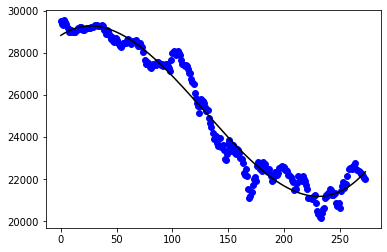

2022-06-16T06:00:00, Insufficient Margin for order of type 2
2022-06-16T06:00:00, Order Canceled


2022-06-16T06:00:00, Close, 21835.15
2022-08-21 16:54:30:  --- Position Begin
- Size: -3.3963332698486317
- Price: 22420.912418124008
- Price orig: 0.0
- Closed: 0
- Opened: -3.3963332698486317
- Adjbase: 21835.15
--- Position End
Open Orders: 
2022-06-16T06:00:00, predict, and max, min 22347.37,  23490.90,21203.83,
Portfolio 78907.51588994893 the other one 769.1807150104723
2022-08-21 16:54:30:  In Uptrend
buy value 21892.383306581818
2022-06-16T06:00:00, BUY CREATE, 21835.15 and now rebalancing portfolio
current model value 22407.117249694187 predicted model next value 22468.521936250538


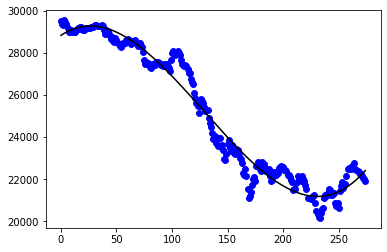

2022-06-16T06:30:00, BUY EXECUTED, Price: 21835.15, Costed Total Of: 150308.34, Comm 0.00
2022-06-16T06:30:00, OPERATION PROFIT, GROSS 1989.44, NET 1989.44


2022-06-16T06:30:00, Close, 21777.17
2022-08-21 16:54:30:  --- Position Begin
- Size: 3.3963332698486317
- Price: 21835.15
- Price orig: 22420.912418124008
- Closed: 3.3963332698486317
- Opened: 3.3963332698486317
- Adjbase: 21777.17
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        6.792666539697263
-----Order price:        None
-----Order Type:        5
-----Trail Amount:        350
-----Trail Percent:        None
-----Created Price:        21485.15
-----Is Buy:        False
2022-06-16T06:30:00, predict, and max, min 22407.12,  23548.64,21265.59,
Portfolio 78710.5964869631 the other one 4748.069492813578
2022-08-21 16:54:30:  In Uptrend
buy value 21954.329612145964
current model value 22468.521936250538 predicted model next value 22531.59106609002


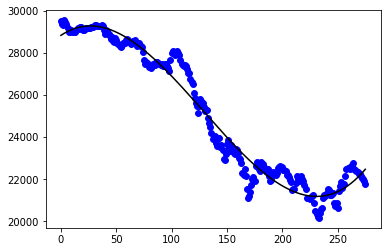



2022-06-16T07:00:00, Close, 21811.94
2022-08-21 16:54:30:  --- Position Begin
- Size: 3.3963332698486317
- Price: 21835.15
- Price orig: 22420.912418124008
- Closed: 3.3963332698486317
- Opened: 3.3963332698486317
- Adjbase: 21811.94
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        6.792666539697263
-----Order price:        None
-----Order Type:        5
-----Trail Amount:        350
-----Trail Percent:        None
-----Created Price:        21485.15
-----Is Buy:        False
2022-06-16T07:00:00, predict, and max, min 22468.52,  23609.15,21327.89,
Portfolio 78828.68699475574 the other one 4748.069492813578
2022-08-21 16:54:30:  In Uptrend
buy value 22017.641788550995
current model value 22531.59106609002 predicted model next value 22596.336023141623


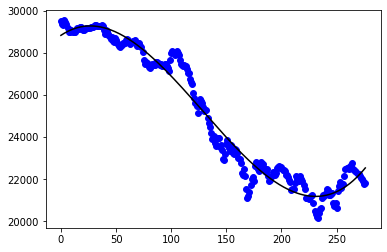



2022-06-16T07:30:00, Close, 21757.23
2022-08-21 16:54:30:  --- Position Begin
- Size: 3.3963332698486317
- Price: 21835.15
- Price orig: 22420.912418124008
- Closed: 3.3963332698486317
- Opened: 3.3963332698486317
- Adjbase: 21757.23
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        6.792666539697263
-----Order price:        None
-----Order Type:        5
-----Trail Amount:        350
-----Trail Percent:        None
-----Created Price:        21485.15
-----Is Buy:        False
2022-06-16T07:30:00, predict, and max, min 22531.59,  23671.23,21391.95,
Portfolio 78642.87360156233 the other one 4748.069492813578
2022-08-21 16:54:30:  In Uptrend
buy value 22083.38694714329
current model value 22596.336023141623 predicted model next value 22662.768191334275


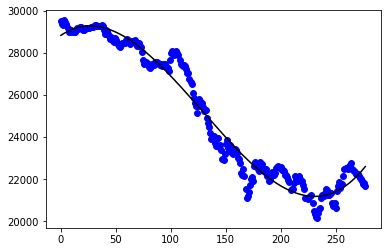



2022-06-16T08:00:00, Close, 21711.46
2022-08-21 16:54:30:  --- Position Begin
- Size: 3.3963332698486317
- Price: 21835.15
- Price orig: 22420.912418124008
- Closed: 3.3963332698486317
- Opened: 3.3963332698486317
- Adjbase: 21711.46
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        6.792666539697263
-----Order price:        None
-----Order Type:        5
-----Trail Amount:        350
-----Trail Percent:        None
-----Created Price:        21485.15
-----Is Buy:        False
2022-06-16T08:00:00, predict, and max, min 22596.34,  23737.12,21455.55,
Portfolio 78487.42342780135 the other one 4748.069492813578
2022-08-21 16:54:30:  In Uptrend
buy value 22149.509419695445
current model value 22662.768191334275 predicted model next value 22730.898954596967


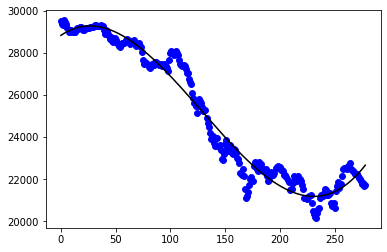



2022-06-16T08:30:00, Close, 21756.75
2022-08-21 16:54:31:  --- Position Begin
- Size: 3.3963332698486317
- Price: 21835.15
- Price orig: 22420.912418124008
- Closed: 3.3963332698486317
- Opened: 3.3963332698486317
- Adjbase: 21756.75
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        6.792666539697263
-----Order price:        None
-----Order Type:        5
-----Trail Amount:        350
-----Trail Percent:        None
-----Created Price:        21485.15
-----Is Buy:        False
2022-06-16T08:30:00, predict, and max, min 22662.77,  23805.50,21520.04,
Portfolio 78641.2433615928 the other one 4748.069492813578
2022-08-21 16:54:31:  In Uptrend
buy value 22216.228787285272
current model value 22730.898954596967 predicted model next value 22800.73969685864


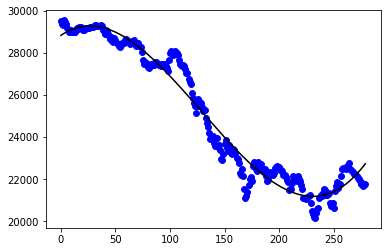

2022-06-16T09:00:00, SELL EXECUTED, Price: 21485.15, Costed Total Of: 147130.18, Comm 0.00
2022-06-16T09:00:00, OPERATION PROFIT, GROSS -1188.72, NET -1188.72


2022-06-16T09:00:00, Close, 21289.18
2022-08-21 16:54:31:  --- Position Begin
- Size: -3.3963332698486317
- Price: 21485.15
- Price orig: 21835.15
- Closed: -3.3963332698486317
- Opened: -3.3963332698486317
- Adjbase: 21289.18
--- Position End
Open Orders: 
2022-06-16T09:00:00, predict, and max, min 22730.90,  23875.46,21586.34,
Portfolio 78384.37867639415 the other one 4748.069492813578
2022-08-21 16:54:31:  Finding the best model and optimizing time...
2022-08-21 16:54:36:  FInished computing all models... Finding and returning best model
2022-08-21 16:54:36:  Remodeling inaccurate model...
current model value 22295.63019338423 predicted model next value 22342.165068875944


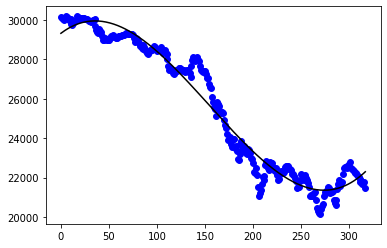



2022-06-16T09:30:00, Close, 21247.54
2022-08-21 16:54:36:  --- Position Begin
- Size: -3.3963332698486317
- Price: 21485.15
- Price orig: 21835.15
- Closed: -3.3963332698486317
- Opened: -3.3963332698486317
- Adjbase: 21247.54
--- Position End
Open Orders: 
2022-06-16T09:30:00, predict, and max, min 22295.63,  23472.95,21118.31,
Portfolio 78525.80199375065 the other one 4748.069492813578
2022-08-21 16:54:36:  In Uptrend
buy value 21819.12484369987
2022-06-16T09:30:00, BUY CREATE, 21247.54 and now rebalancing portfolio
current model value 22342.165068875944 predicted model next value 22389.939933751844


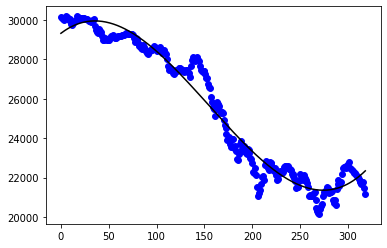

2022-06-16T10:00:00, BUY EXECUTED, Price: 21247.54, Costed Total Of: 145134.46, Comm 0.00
2022-06-16T10:00:00, OPERATION PROFIT, GROSS 807.00, NET 807.00


2022-06-16T10:00:00, Close, 21042.83
2022-08-21 16:54:36:  --- Position Begin
- Size: 3.3963332698486317
- Price: 21247.54
- Price orig: 21485.15
- Closed: 3.3963332698486317
- Opened: 3.3963332698486317
- Adjbase: 21042.83
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        6.792666539697263
-----Order price:        None
-----Order Type:        5
-----Trail Amount:        350
-----Trail Percent:        None
-----Created Price:        20897.54
-----Is Buy:        False
2022-06-16T10:00:00, predict, and max, min 22342.17,  23523.37,21160.96,
Portfolio 77830.53861007994 the other one 6362.074989311048
2022-08-21 16:54:36:  Finding the best model and optimizing time...
2022-08-21 16:54:42:  FInished computing all models... Finding and returning best model
2022-08-21 16:54:42:  Remodeling inaccurate mod

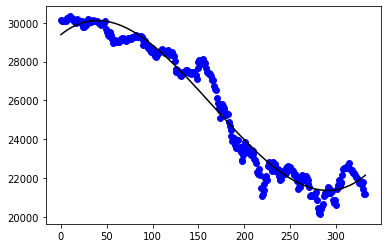

2022-06-16T10:30:00, Order Canceled
2022-06-16T10:30:00, SELL EXECUTED, Price: 21042.83, Costed Total Of: 72163.73, Comm 0.00
2022-06-16T10:30:00, OPERATION PROFIT, GROSS -695.26, NET -695.26


2022-06-16T10:30:00, Close, 21230.54
2022-08-21 16:54:42:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 21247.54
- Closed: -3.3963332698486317
- Opened: 0
- Adjbase: 21042.83
--- Position End
Open Orders: 
2022-06-16T10:30:00, predict, and max, min 22146.84,  23380.38,20913.30,
Portfolio 77830.53861007994 the other one 77830.53861007994
2022-08-21 16:54:42:  In Uptrend
buy value 21645.538822849143
2022-06-16T10:30:00, BUY CREATE, 21230.54 and now rebalancing portfolio
current model value 22187.14923773492 predicted model next value 22228.568871711155


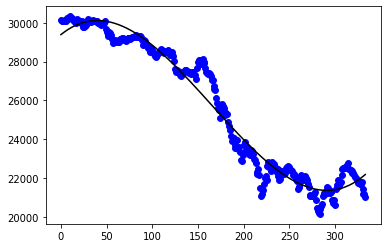

2022-06-16T11:00:00, BUY EXECUTED, Price: 21230.54, Costed Total Of: 77052.23, Comm 0.00


2022-06-16T11:00:00, Close, 21110.70
2022-08-21 16:54:42:  --- Position Begin
- Size: 3.6293110407921385
- Price: 21230.54
- Price orig: 0.0
- Closed: 0
- Opened: 3.6293110407921385
- Adjbase: 21110.7
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        3.6293110407921385
-----Order price:        None
-----Order Type:        5
-----Trail Amount:        350
-----Trail Percent:        None
-----Created Price:        20880.54
-----Is Buy:        False
2022-06-16T11:00:00, predict, and max, min 22187.15,  23424.19,20950.11,
Portfolio 77395.60197495141 the other one 778.3053861008084
2022-08-21 16:54:42:  In Uptrend
buy value 21686.03737311899
current model value 22228.568871711155 predicted model next value 22271.105718208848


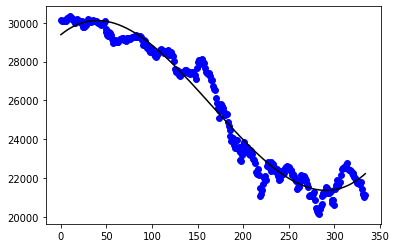

2022-06-16T11:30:00, SELL EXECUTED, Price: 20880.54, Costed Total Of: 77052.23, Comm 0.00
2022-06-16T11:30:00, OPERATION PROFIT, GROSS -1270.26, NET -1270.26


2022-06-16T11:30:00, Close, 21015.55
2022-08-21 16:54:42:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 21230.54
- Closed: -3.6293110407921385
- Opened: 0
- Adjbase: 21110.7
--- Position End
Open Orders: 
2022-06-16T11:30:00, predict, and max, min 22228.57,  23467.62,20989.51,
Portfolio 76560.27974580269 the other one 76560.27974580269
2022-08-21 16:54:42:  In Uptrend
buy value 21724.727969466552
2022-06-16T11:30:00, BUY CREATE, 21015.55 and now rebalancing portfolio
current model value 22271.105718208848 predicted model next value 22314.76640126759


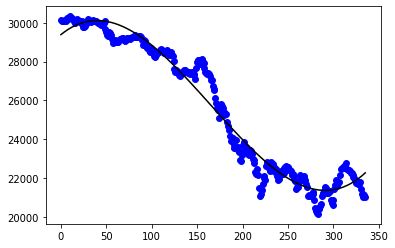

2022-06-16T12:00:00, BUY EXECUTED, Price: 21015.55, Costed Total Of: 75794.68, Comm 0.00


2022-06-16T12:00:00, Close, 21225.50
2022-08-21 16:54:42:  --- Position Begin
- Size: 3.606599729645175
- Price: 21015.55
- Price orig: 0.0
- Closed: 0
- Opened: 3.606599729645175
- Adjbase: 21225.5
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        3.606599729645175
-----Order price:        None
-----Order Type:        5
-----Trail Amount:        350
-----Trail Percent:        None
-----Created Price:        20875.5
-----Is Buy:        False
2022-06-16T12:00:00, predict, and max, min 22271.11,  23514.20,21028.02,
Portfolio 77317.4853590417 the other one 765.6027974580356
2022-08-21 16:54:42:  In Uptrend
buy value 21767.32168041047
current model value 22314.76640126759 predicted model next value 22359.557544926996


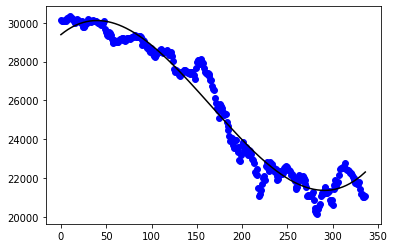



2022-06-16T12:30:00, Close, 21115.53
2022-08-21 16:54:43:  --- Position Begin
- Size: 3.606599729645175
- Price: 21015.55
- Price orig: 0.0
- Closed: 0
- Opened: 3.606599729645175
- Adjbase: 21115.53
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        3.606599729645175
-----Order price:        None
-----Order Type:        5
-----Trail Amount:        350
-----Trail Percent:        None
-----Created Price:        20875.5
-----Is Buy:        False
2022-06-16T12:30:00, predict, and max, min 22314.77,  23562.20,21067.33,
Portfolio 76920.86758677261 the other one 765.6027974580356
2022-08-21 16:54:43:  In Uptrend
buy value 21807.399827691843
current model value 22359.557544926996 predicted model next value 22405.485773226705


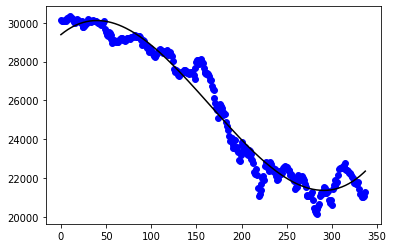



2022-06-16T13:00:00, Close, 21224.37
2022-08-21 16:54:43:  --- Position Begin
- Size: 3.606599729645175
- Price: 21015.55
- Price orig: 0.0
- Closed: 0
- Opened: 3.606599729645175
- Adjbase: 21224.37
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        3.606599729645175
-----Order price:        None
-----Order Type:        5
-----Trail Amount:        350
-----Trail Percent:        None
-----Created Price:        20875.5
-----Is Buy:        False
2022-06-16T13:00:00, predict, and max, min 22359.56,  23608.86,21110.26,
Portfolio 77313.4099013472 the other one 765.6027974580356
2022-08-21 16:54:43:  In Uptrend
buy value 21852.83413051108
current model value 22405.485773226705 predicted model next value 22452.55771020629


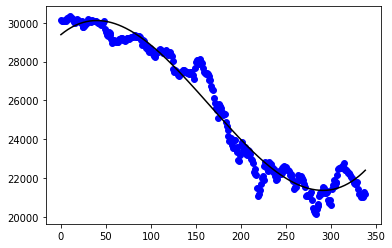



2022-06-16T13:30:00, Close, 20994.85
2022-08-21 16:54:43:  --- Position Begin
- Size: 3.606599729645175
- Price: 21015.55
- Price orig: 0.0
- Closed: 0
- Opened: 3.606599729645175
- Adjbase: 20994.85
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        3.606599729645175
-----Order price:        None
-----Order Type:        5
-----Trail Amount:        350
-----Trail Percent:        None
-----Created Price:        20875.5
-----Is Buy:        False
2022-06-16T13:30:00, predict, and max, min 22405.49,  23658.49,21152.48,
Portfolio 76485.62313139903 the other one 765.6027974580356
2022-08-21 16:54:43:  Finding the best model and optimizing time...
2022-08-21 16:54:48:  FInished computing all models... Finding and returning best model
2022-08-21 16:54:48:  Remodeling inaccurate model...
2022-08-21 16:54:49:  Close all long positions here
current model value 22112.490722034338 predicted model next value 22153.867183591985


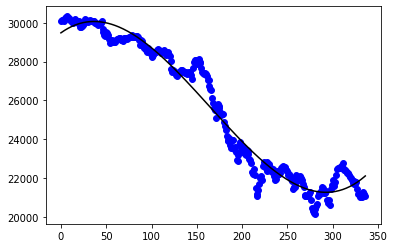

2022-06-16T14:00:00, Order Canceled
2022-06-16T14:00:00, SELL EXECUTED, Price: 20994.85, Costed Total Of: 75794.68, Comm 0.00
2022-06-16T14:00:00, OPERATION PROFIT, GROSS -74.66, NET -74.66


2022-06-16T14:00:00, Close, 21022.67
2022-08-21 16:54:49:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 21015.55
- Closed: -3.606599729645175
- Opened: 0
- Adjbase: 20994.85
--- Position End
Open Orders: 
2022-06-16T14:00:00, predict, and max, min 22112.49,  23368.86,20856.12,
Portfolio 76485.62313139903 the other one 76485.62313139903
2022-08-21 16:54:49:  In Uptrend
buy value 21596.447106435073
2022-06-16T14:00:00, BUY CREATE, 21022.67 and now rebalancing portfolio
current model value 22153.867183591985 predicted model next value 22196.327300250796


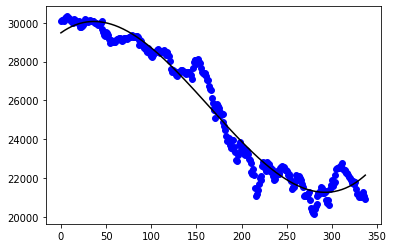

2022-06-16T14:30:00, BUY EXECUTED, Price: 21022.67, Costed Total Of: 75720.77, Comm 0.00


2022-06-16T14:30:00, Close, 20895.50
2022-08-21 16:54:49:  --- Position Begin
- Size: 3.6018625084294738
- Price: 21022.67
- Price orig: 0.0
- Closed: 0
- Opened: 3.6018625084294738
- Adjbase: 20895.5
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        3.6018625084294738
-----Order price:        None
-----Order Type:        5
-----Trail Amount:        350
-----Trail Percent:        None
-----Created Price:        20672.67
-----Is Buy:        False
2022-06-16T14:30:00, predict, and max, min 22153.87,  23414.48,20893.26,
Portfolio 76027.57427620205 the other one 764.8562313139846
2022-08-21 16:54:49:  In Uptrend
buy value 21637.780596887762
current model value 22196.327300250796 predicted model next value 22239.87735549964


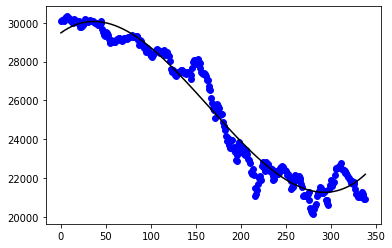



2022-06-16T15:00:00, Close, 21182.50
2022-08-21 16:54:49:  --- Position Begin
- Size: 3.6018625084294738
- Price: 21022.67
- Price orig: 0.0
- Closed: 0
- Opened: 3.6018625084294738
- Adjbase: 21182.5
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        3.6018625084294738
-----Order price:        None
-----Order Type:        5
-----Trail Amount:        350
-----Trail Percent:        None
-----Created Price:        20832.5
-----Is Buy:        False
2022-06-16T15:00:00, predict, and max, min 22196.33,  23461.20,20931.46,
Portfolio 77061.30881612131 the other one 764.8562313139846
2022-08-21 16:54:49:  In Uptrend
buy value 21676.524368761846
current model value 22239.87735549964 predicted model next value 22284.5236328274


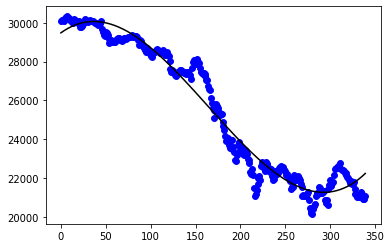



2022-06-16T15:30:00, Close, 21042.18
2022-08-21 16:54:49:  --- Position Begin
- Size: 3.6018625084294738
- Price: 21022.67
- Price orig: 0.0
- Closed: 0
- Opened: 3.6018625084294738
- Adjbase: 21042.18
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        3.6018625084294738
-----Order price:        None
-----Order Type:        5
-----Trail Amount:        350
-----Trail Percent:        None
-----Created Price:        20832.5
-----Is Buy:        False
2022-06-16T15:30:00, predict, and max, min 22239.88,  23507.71,20972.05,
Portfolio 76555.89546893848 the other one 764.8562313139846
2022-08-21 16:54:49:  In Uptrend
buy value 21720.379261446084
current model value 22284.5236328274 predicted model next value 22330.272415722935


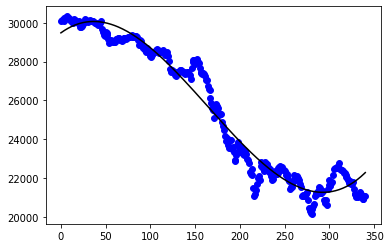

2022-06-16T16:00:00, SELL EXECUTED, Price: 20832.50, Costed Total Of: 75720.77, Comm 0.00
2022-06-16T16:00:00, OPERATION PROFIT, GROSS -684.97, NET -684.97


2022-06-16T16:00:00, Close, 21054.61
2022-08-21 16:54:49:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 21022.67
- Closed: -3.6018625084294738
- Opened: 0
- Adjbase: 21042.18
--- Position End
Open Orders: 
2022-06-16T16:00:00, predict, and max, min 22284.52,  23555.70,21013.35,
Portfolio 75800.656938171 the other one 75800.656938171
2022-08-21 16:54:49:  In Uptrend
buy value 21765.235925569345
2022-06-16T16:00:00, BUY CREATE, 21054.61 and now rebalancing portfolio
current model value 22330.272415722935 predicted model next value 22377.129987675125


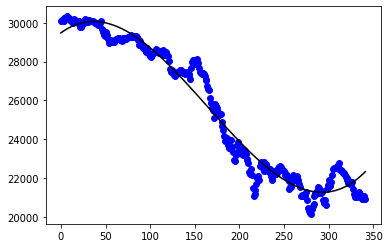

2022-06-16T16:30:00, BUY EXECUTED, Price: 21054.61, Costed Total Of: 75042.65, Comm 0.00


2022-06-16T16:30:00, Close, 21138.89
2022-08-21 16:54:49:  --- Position Begin
- Size: 3.5641909476731835
- Price: 21054.61
- Price orig: 0.0
- Closed: 0
- Opened: 3.5641909476731835
- Adjbase: 21138.89
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        3.5641909476731835
-----Order price:        None
-----Order Type:        5
-----Trail Amount:        350
-----Trail Percent:        None
-----Created Price:        20788.89
-----Is Buy:        False
2022-06-16T16:30:00, predict, and max, min 22330.27,  23607.67,21052.88,
Portfolio 76101.04695124089 the other one 758.006569381716
2022-08-21 16:54:49:  In Uptrend
buy value 21810.43644172323
current model value 22377.129987675125 predicted model next value 22425.10263217286


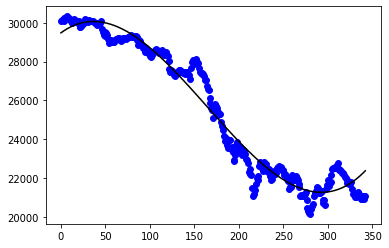



2022-06-16T17:00:00, Close, 21312.78
2022-08-21 16:54:49:  --- Position Begin
- Size: 3.5641909476731835
- Price: 21054.61
- Price orig: 0.0
- Closed: 0
- Opened: 3.5641909476731835
- Adjbase: 21312.78
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        3.5641909476731835
-----Order price:        None
-----Order Type:        5
-----Trail Amount:        350
-----Trail Percent:        None
-----Created Price:        20962.78
-----Is Buy:        False
2022-06-16T17:00:00, predict, and max, min 22377.13,  23658.81,21095.45,
Portfolio 76720.82411513178 the other one 758.006569381716
2022-08-21 16:54:49:  In Uptrend
buy value 21852.174160312337
current model value 22425.10263217286 predicted model next value 22474.196632705007


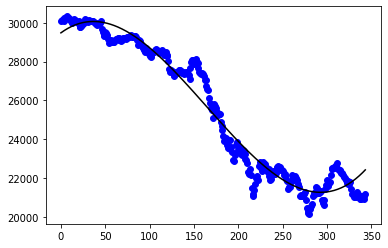



2022-06-16T17:30:00, Close, 21035.54
2022-08-21 16:54:50:  --- Position Begin
- Size: 3.5641909476731835
- Price: 21054.61
- Price orig: 0.0
- Closed: 0
- Opened: 3.5641909476731835
- Adjbase: 21035.54
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        3.5641909476731835
-----Order price:        None
-----Order Type:        5
-----Trail Amount:        350
-----Trail Percent:        None
-----Created Price:        20962.78
-----Is Buy:        False
2022-06-16T17:30:00, predict, and max, min 22425.10,  23710.19,21140.02,
Portfolio 75732.68781679888 the other one 758.006569381716
2022-08-21 16:54:50:  Finding the best model and optimizing time...
2022-08-21 16:54:55:  FInished computing all models... Finding and returning best model
2022-08-21 16:54:55:  Remodeling inaccurate model...
2022-08-21 16:54:55:  Close all long positions here
current model value 22111.17003820881 predicted model next value 22155.020168430565


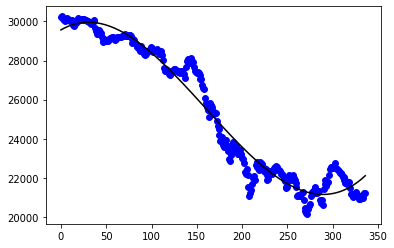

2022-06-16T18:00:00, Order Canceled
2022-06-16T18:00:00, SELL EXECUTED, Price: 21035.54, Costed Total Of: 75042.65, Comm 0.00
2022-06-16T18:00:00, OPERATION PROFIT, GROSS -67.97, NET -67.97


2022-06-16T18:00:00, Close, 20958.67
2022-08-21 16:54:55:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 21054.61
- Closed: -3.5641909476731835
- Opened: 0
- Adjbase: 21035.54
--- Position End
Open Orders: 
2022-06-16T18:00:00, predict, and max, min 22111.17,  23379.11,20843.23,
Portfolio 75732.68781679888 the other one 75732.68781679888
2022-08-21 16:54:55:  In Uptrend
buy value 21587.565318300178
2022-06-16T18:00:00, BUY CREATE, 20958.67 and now rebalancing portfolio
current model value 22155.020168430565 predicted model next value 22199.947436962233


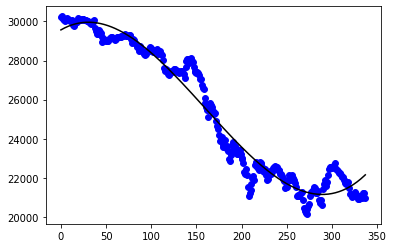

2022-06-16T18:30:00, BUY EXECUTED, Price: 20958.67, Costed Total Of: 74975.36, Comm 0.00


2022-06-16T18:30:00, Close, 21000.80
2022-08-21 16:54:55:  --- Position Begin
- Size: 3.577295741506064
- Price: 20958.67
- Price orig: 0.0
- Closed: 0
- Opened: 3.577295741506064
- Adjbase: 21000.8
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        3.577295741506064
-----Order price:        None
-----Order Type:        5
-----Trail Amount:        350
-----Trail Percent:        None
-----Created Price:        20650.8
-----Is Buy:        False
2022-06-16T18:30:00, predict, and max, min 22155.02,  23425.88,20884.16,
Portfolio 75883.39928638852 the other one 757.3268781679799
2022-08-21 16:54:55:  In Uptrend
buy value 21631.709971890166
current model value 22199.947436962233 predicted model next value 22245.95792568726


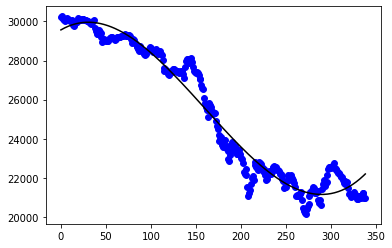



2022-06-16T19:00:00, Close, 21043.00
2022-08-21 16:54:56:  --- Position Begin
- Size: 3.577295741506064
- Price: 20958.67
- Price orig: 0.0
- Closed: 0
- Opened: 3.577295741506064
- Adjbase: 21043.0
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        3.577295741506064
-----Order price:        None
-----Order Type:        5
-----Trail Amount:        350
-----Trail Percent:        None
-----Created Price:        20693.0
-----Is Buy:        False
2022-06-16T19:00:00, predict, and max, min 22199.95,  23474.13,20925.76,
Portfolio 76034.36116668009 the other one 757.3268781679799
2022-08-21 16:54:56:  In Uptrend
buy value 21674.300390095654
current model value 22245.95792568726 predicted model next value 22293.0577164891


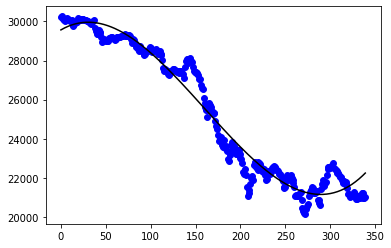



2022-06-16T19:30:00, Close, 20837.63
2022-08-21 16:54:56:  --- Position Begin
- Size: 3.577295741506064
- Price: 20958.67
- Price orig: 0.0
- Closed: 0
- Opened: 3.577295741506064
- Adjbase: 20837.63
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        3.577295741506064
-----Order price:        None
-----Order Type:        5
-----Trail Amount:        350
-----Trail Percent:        None
-----Created Price:        20693.0
-----Is Buy:        False
2022-06-16T19:30:00, predict, and max, min 22245.96,  23523.79,20968.13,
Portfolio 75299.691940247 the other one 757.3268781679799
2022-08-21 16:54:56:  Finding the best model and optimizing time...
2022-08-21 16:55:01:  FInished computing all models... Finding and returning best model
2022-08-21 16:55:01:  Remodeling inaccurate model...
2022-08-21 16:55:01:  Close all long positions here
current model value 21187.37427710866 predicted model next value 21159.997664449103


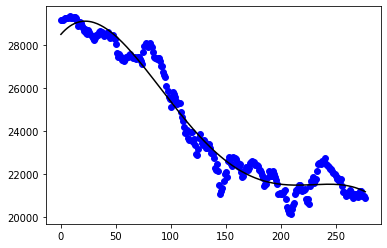

2022-06-16T20:00:00, Order Canceled
2022-06-16T20:00:00, SELL EXECUTED, Price: 20837.63, Costed Total Of: 74975.36, Comm 0.00
2022-06-16T20:00:00, OPERATION PROFIT, GROSS -433.00, NET -433.00


2022-06-16T20:00:00, Close, 20927.54
2022-08-21 16:55:01:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 20958.67
- Closed: -3.577295741506064
- Opened: 0
- Adjbase: 20837.63
--- Position End
Open Orders: 
2022-06-16T20:00:00, predict, and max, min 21187.37,  22265.42,20109.33,
Portfolio 75299.691940247 the other one 75299.691940247
2022-08-21 16:55:01:  In Downtrend
2022-06-16: Limit Order / Buy at 20674.091167267587
2022-06-16: Limit Order / Sell at 21627.451423796414
current model value 21159.997664449103 predicted model next value 21131.24565036619


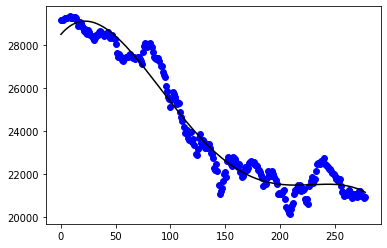

Limit ordering
2022-06-16T20:30:00, BUY EXECUTED, Price: 20674.09, Costed Total Of: 74546.70, Comm 0.00
2022-06-16T20:30:00, Order Canceled


2022-06-16T20:30:00, Close, 20677.53
2022-08-21 16:55:01:  --- Position Begin
- Size: 3.6058027614230097
- Price: 20674.091167267587
- Price orig: 0.0
- Closed: 0
- Opened: 3.6058027614230097
- Adjbase: 20677.53
--- Position End
Open Orders: 
2022-06-16T20:30:00, predict, and max, min 21160.00,  22237.20,20082.80,
Portfolio 75312.0916928096 the other one 752.9969194024743
2022-08-21 16:55:01:  In Downtrend
2022-06-16: Limit Order / Buy at 20646.81139209782
2022-06-16: Limit Order / Sell at 21598.48050002956
current model value 21131.24565036619 predicted model next value 21101.082138635313


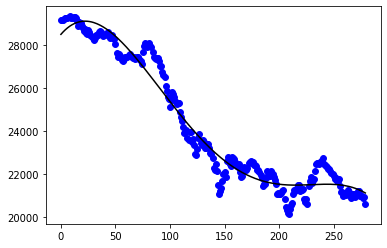

Limit ordering
2022-06-16T21:00:00, SELL EXECUTED, Price: 20676.80, Costed Total Of: 0.12, Comm 0.00
2022-06-16T21:00:00, Order Canceled


2022-06-16T21:00:00, Close, 20813.93
2022-08-21 16:55:01:  --- Position Begin
- Size: 3.605796755772875
- Price: 20674.091167267587
- Price orig: 20674.091167267587
- Closed: -6.005650134676699e-06
- Opened: 0
- Adjbase: 20813.93
--- Position End
Open Orders: 
2022-06-16T21:00:00, predict, and max, min 21131.25,  22206.52,20055.97,
Portfolio 75803.92236591289 the other one 753.1210970291789
2022-08-21 16:55:01:  In Downtrend
2022-06-16: Limit Order / Buy at 20617.166716848948
2022-06-16: Limit Order / Sell at 21566.65536542026
current model value 21101.082138635313 predicted model next value 21069.470727584303


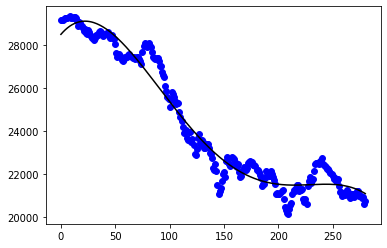

Limit ordering
2022-06-16T21:30:00, SELL EXECUTED, Price: 20813.93, Costed Total Of: 4.93, Comm 0.00
2022-06-16T21:30:00, Order Canceled


2022-06-16T21:30:00, Close, 20643.71
2022-08-21 16:55:01:  --- Position Begin
- Size: 3.605558210549979
- Price: 20674.091167267587
- Price orig: 20674.091167267587
- Closed: -0.00023854522289608768
- Opened: 0
- Adjbase: 20643.71
--- Position End
Open Orders: 
2022-06-16T21:30:00, predict, and max, min 21101.08,  22174.74,20027.42,
Portfolio 75190.18424731308 the other one 758.0861606003725
2022-08-21 16:55:01:  In Downtrend
2022-06-16: Limit Order / Buy at 20587.151836883797
2022-06-16: Limit Order / Sell at 21534.622939085944
current model value 21069.470727584303 predicted model next value 21036.374710093492


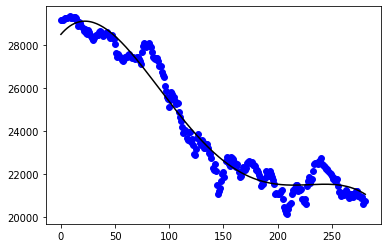

Limit ordering
2022-06-16T22:00:00, BUY EXECUTED, Price: 20587.15, Costed Total Of: 6.18, Comm 0.00
2022-06-16T22:00:00, Order Canceled


2022-06-16T22:00:00, Close, 20566.09
2022-08-21 16:55:01:  --- Position Begin
- Size: 3.6058586075245698
- Price: 20674.083924523304
- Price orig: 20674.091167267587
- Closed: 0
- Opened: 0.00030039697459081184
- Adjbase: 20566.09
--- Position End
Open Orders: 
2022-06-16T22:00:00, predict, and max, min 21069.47,  22141.63,19997.31,
Portfolio 74910.31449209811 the other one 751.901842473131
2022-08-21 16:55:01:  In Downtrend
2022-06-16: Limit Order / Buy at 20554.460031006492
2022-06-16: Limit Order / Sell at 21499.79657998477
current model value 21036.374710093492 predicted model next value 21001.757073595603


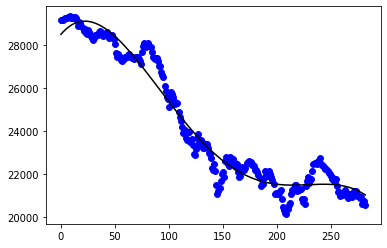

Limit ordering
2022-06-16T22:30:00, BUY EXECUTED, Price: 20554.46, Costed Total Of: 2.80, Comm 0.00
2022-06-16T22:30:00, Order Canceled


2022-06-16T22:30:00, Close, 20334.61
2022-08-21 16:55:02:  --- Position Begin
- Size: 3.6059947676352184
- Price: 20674.079407599787
- Price orig: 20674.083924523304
- Closed: 0
- Opened: 0.00013616011064883747
- Adjbase: 20334.61
--- Position End
Open Orders: 
2022-06-16T22:30:00, predict, and max, min 21036.37,  22106.64,19966.11,
Portfolio 74075.60040682378 the other one 749.103144920982
2022-08-21 16:55:02:  In Downtrend
2022-06-16: Limit Order / Buy at 20520.35372569791
2022-06-16: Limit Order / Sell at 21464.68723392466
current model value 21001.757073595603 predicted model next value 20965.580500075863


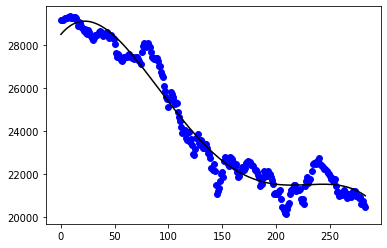

Limit ordering
2022-06-16T23:00:00, BUY EXECUTED, Price: 20334.60, Costed Total Of: 8.27, Comm 0.00
2022-06-16T23:00:00, Order Canceled


2022-06-16T23:00:00, Close, 20367.67
2022-08-21 16:55:02:  --- Position Begin
- Size: 3.6064015413665254
- Price: 20674.041116992445
- Price orig: 20674.079407599787
- Closed: 0
- Opened: 0.00040677373130693317
- Adjbase: 20367.67
--- Position End
Open Orders: 
2022-06-16T23:00:00, predict, and max, min 21001.76,  22070.17,19933.35,
Portfolio 74194.82804584908 the other one 740.8315638043481
2022-08-21 16:55:02:  In Downtrend
2022-06-16: Limit Order / Buy at 20484.677928929832
2022-06-16: Limit Order / Sell at 21428.029100268395
current model value 20965.580500075863 predicted model next value 20927.807366071902


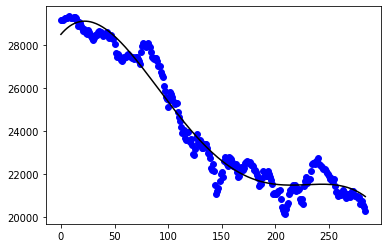



2022-06-16T23:30:00, Close, 20372.00
2022-08-21 16:55:02:  --- Position Begin
- Size: 3.6064015413665254
- Price: 20674.041116992445
- Price orig: 20674.079407599787
- Closed: 0
- Opened: 0.00040677373130693317
- Adjbase: 20372.0
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        6.855827736653356
-----Order price:        21428.029100268395
-----Order Type:        2
-----Trail Amount:        None
-----Trail Percent:        None
-----Created Price:        21428.029100268395
-----Is Buy:        False
-----Asset:             BTCUSD
-----Order Size:        5.4514728424371894e-05
-----Order price:        20484.677928929832
-----Order Type:        2
-----Trail Amount:        None
-----Trail Percent:        None
-----Created Price:        20484.677928929832
-----Is Buy:        False
2022-06-16T23:30:00, predict, and max, min 20965.58,  22032.78,19898.38,
Portfolio 74210.4437645232 the other one 740.8315638043481
2022-08-21 16:55:02:  In Downtrend
2022-06-1

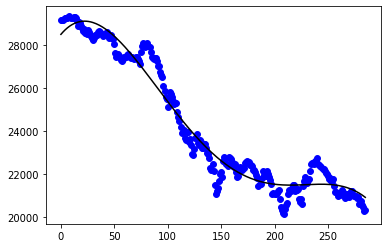

2022-06-17T00:00:00, ORDER EXPIRED
2022-06-17T00:00:00, Order Canceled
Limit ordering
2022-06-17T00:00:00, SELL EXECUTED, Price: 20447.23, Costed Total Of: 1.29, Comm 0.00
2022-06-17T00:00:00, Order Canceled


2022-06-17T00:00:00, Close, 20427.81
2022-08-21 16:55:02:  --- Position Begin
- Size: 3.606339289719794
- Price: 20674.041116992445
- Price orig: 20674.041116992445
- Closed: -6.225164673128308e-05
- Opened: 0
- Adjbase: 20427.81
--- Position End
Open Orders: 
2022-06-17T00:00:00, predict, and max, min 20927.81,  21993.35,19862.27,
Portfolio 74411.71824357615 the other one 742.1044376452395
2022-08-21 16:55:02:  In Downtrend
2022-06-17: Limit Order / Buy at 20408.649561386806
2022-06-17: Limit Order / Sell at 21350.102343391063
current model value 20888.399742673857 predicted model next value 20847.319395524224


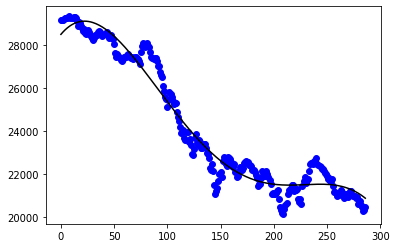

Limit ordering
2022-06-17T00:30:00, SELL EXECUTED, Price: 20419.86, Costed Total Of: 2.04, Comm 0.00
2022-06-17T00:30:00, Order Canceled


2022-06-17T00:30:00, Close, 20338.62
2022-08-21 16:55:02:  --- Position Begin
- Size: 3.606240667575077
- Price: 20674.041116992445
- Price orig: 20674.041116992445
- Closed: -9.862214471717382e-05
- Opened: 0
- Adjbase: 20338.62
--- Position End
Open Orders: 
2022-06-17T00:30:00, predict, and max, min 20888.40,  21952.15,19824.65,
Portfolio 74090.07685438907 the other one 744.118288033264
2022-08-21 16:55:02:  In Downtrend
2022-06-17: Limit Order / Buy at 20368.052901691306
2022-06-17: Limit Order / Sell at 21308.556504482975
current model value 20847.319395524224 predicted model next value 20804.52778481805


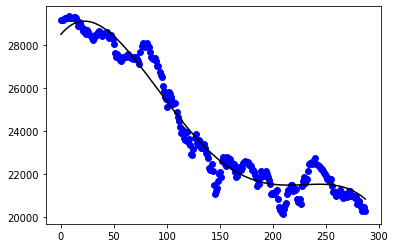

Limit ordering
2022-06-17T01:00:00, BUY EXECUTED, Price: 20338.63, Costed Total Of: 3.21, Comm 0.00
2022-06-17T01:00:00, Order Canceled


2022-06-17T01:00:00, Close, 20438.42
2022-08-21 16:55:02:  --- Position Begin
- Size: 3.6063986365034233
- Price: 20674.026425179352
- Price orig: 20674.041116992445
- Closed: 0
- Opened: 0.0001579689283462008
- Adjbase: 20438.42
--- Position End
Open Orders: 
2022-06-17T01:00:00, predict, and max, min 20847.32,  21909.29,19785.35,
Portfolio 74449.99543673242 the other one 740.9054164481341
2022-08-21 16:55:02:  In Downtrend
2022-06-17: Limit Order / Buy at 20325.74175858581
2022-06-17: Limit Order / Sell at 21264.05935408784
current model value 20804.52778481805 predicted model next value 20759.986065302808


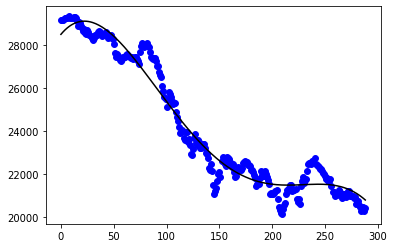

Limit ordering
2022-06-17T01:30:00, SELL EXECUTED, Price: 20440.03, Costed Total Of: 3.66, Comm 0.00
2022-06-17T01:30:00, Order Canceled


2022-06-17T01:30:00, Close, 20844.36
2022-08-21 16:55:02:  --- Position Begin
- Size: 3.606221789923265
- Price: 20674.026425179352
- Price orig: 20674.026425179352
- Closed: -0.0001768465801581447
- Opened: 0
- Adjbase: 20844.36
--- Position End
Open Orders: 
2022-06-17T01:30:00, predict, and max, min 20804.53,  21864.88,19744.17,
Portfolio 75913.90539485688 the other one 744.5201658519641
2022-08-21 16:55:02:  In Downtrend
2022-06-17: Limit Order / Buy at 20282.58352443863
2022-06-17: Limit Order / Sell at 21219.097878469318
current model value 20759.986065302808 predicted model next value 20713.655086278384


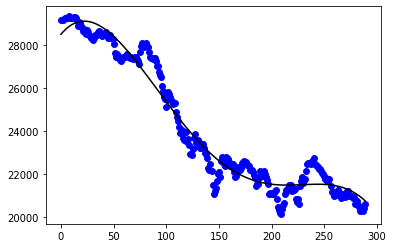

Limit ordering
2022-06-17T02:00:00, SELL EXECUTED, Price: 20849.30, Costed Total Of: 14.90, Comm 0.00
2022-06-17T02:00:00, Order Canceled


2022-06-17T02:00:00, Close, 20715.65
2022-08-21 16:55:02:  --- Position Begin
- Size: 3.6055010292726806
- Price: 20674.026425179352
- Price orig: 20674.026425179352
- Closed: -0.000720760650584429
- Opened: 0
- Adjbase: 20715.65
--- Position End
Open Orders: 
2022-06-17T02:00:00, predict, and max, min 20759.99,  21820.29,19699.68,
Portfolio 75449.8449179368 the other one 759.547520884194
2022-08-21 16:55:02:  In Downtrend
2022-06-17: Limit Order / Buy at 20236.2651130537
2022-06-17: Limit Order / Sell at 21172.75481330948
current model value 20713.655086278384 predicted model next value 20665.49539159712


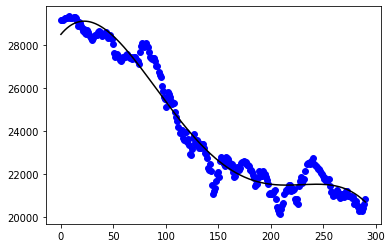



2022-06-17T02:30:00, Close, 20552.98
2022-08-21 16:55:02:  --- Position Begin
- Size: 3.6055010292726806
- Price: 20674.026425179352
- Price orig: 20674.026425179352
- Closed: -0.000720760650584429
- Opened: 0
- Adjbase: 20552.98
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        7.055560090456638
-----Order price:        21172.75481330948
-----Order Type:        2
-----Trail Amount:        None
-----Trail Percent:        None
-----Created Price:        21172.75481330948
-----Is Buy:        False
-----Asset:             BTCUSD
-----Order Size:        0.0002495061058261345
-----Order price:        20236.2651130537
-----Order Type:        2
-----Trail Amount:        None
-----Trail Percent:        None
-----Created Price:        20236.2651130537
-----Is Buy:        True
2022-06-17T02:30:00, predict, and max, min 20713.66,  21773.86,19653.45,
Portfolio 74863.33806550501 the other one 759.547520884194
2022-08-21 16:55:02:  In Downtrend
2022-06-17: Limit

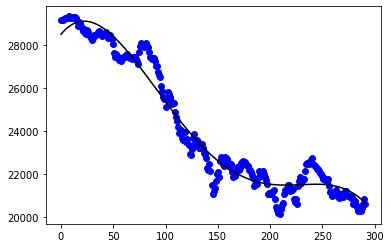

2022-06-17T03:00:00, ORDER EXPIRED
2022-06-17T03:00:00, Order Canceled


2022-06-17T03:00:00, Close, 20559.14
2022-08-21 16:55:02:  --- Position Begin
- Size: 3.6055010292726806
- Price: 20674.026425179352
- Price orig: 20674.026425179352
- Closed: -0.000720760650584429
- Opened: 0
- Adjbase: 20559.14
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        7.0164038888616584
-----Order price:        21124.567168199
-----Order Type:        2
-----Trail Amount:        None
-----Trail Percent:        None
-----Created Price:        21124.567168199
-----Is Buy:        False
-----Asset:             BTCUSD
-----Order Size:        0.0005406215338369017
-----Order price:        20188.134482329286
-----Order Type:        2
-----Trail Amount:        None
-----Trail Percent:        None
-----Created Price:        20188.134482329286
-----Is Buy:        True
2022-06-17T03:00:00, predict, and max, min 20665.50,  21726.85,19604.14,
Portfolio 74885.54795184534 the other o

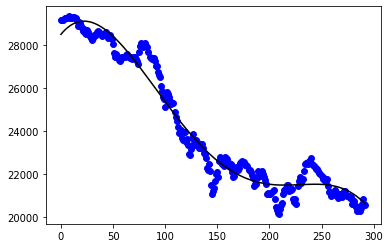

2022-06-17T03:30:00, ORDER EXPIRED
2022-06-17T03:30:00, Order Canceled


2022-06-17T03:30:00, Close, 20352.38
2022-08-21 16:55:03:  --- Position Begin
- Size: 3.6055010292726806
- Price: 20674.026425179352
- Price orig: 20674.026425179352
- Closed: -0.000720760650584429
- Opened: 0
- Adjbase: 20352.38
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        7.035328428730923
-----Order price:        21074.025812044794
-----Order Type:        2
-----Trail Amount:        None
-----Trail Percent:        None
-----Created Price:        21074.025812044794
-----Is Buy:        False
-----Asset:             BTCUSD
-----Order Size:        0.0005309440114642432
-----Order price:        20137.79444700529
-----Order Type:        2
-----Trail Amount:        None
-----Trail Percent:        None
-----Created Price:        20137.79444700529
-----Is Buy:        True
2022-06-17T03:30:00, predict, and max, min 20615.47,  21677.89,19553.05,
Portfolio 74140.07455903292 the othe

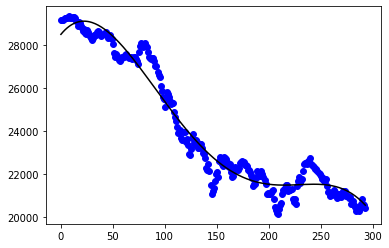

2022-06-17T04:00:00, ORDER EXPIRED
2022-06-17T04:00:00, Order Canceled


2022-06-17T04:00:00, Close, 20485.07
2022-08-21 16:55:03:  --- Position Begin
- Size: 3.6055010292726806
- Price: 20674.026425179352
- Price orig: 20674.026425179352
- Closed: -0.000720760650584429
- Opened: 0
- Adjbase: 20485.07
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        6.982049829594233
-----Order price:        21022.365126850073
-----Order Type:        2
-----Trail Amount:        None
-----Trail Percent:        None
-----Created Price:        21022.365126850073
-----Is Buy:        False
-----Asset:             BTCUSD
-----Order Size:        0.0009034732456527432
-----Order price:        20085.570193892934
-----Order Type:        2
-----Trail Amount:        None
-----Trail Percent:        None
-----Created Price:        20085.570193892934
-----Is Buy:        True
2022-06-17T04:00:00, predict, and max, min 20563.53,  21625.97,19501.09,
Portfolio 74618.48849060711 the ot

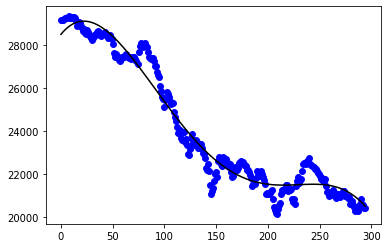

2022-06-17T04:30:00, ORDER EXPIRED
2022-06-17T04:30:00, Order Canceled


2022-06-17T04:30:00, Close, 20510.76
2022-08-21 16:55:03:  --- Position Begin
- Size: 3.6055010292726806
- Price: 20674.026425179352
- Price orig: 20674.026425179352
- Closed: -0.000720760650584429
- Opened: 0
- Adjbase: 20510.76
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        7.045394742091063
-----Order price:        20968.48366676152
-----Order Type:        2
-----Trail Amount:        None
-----Trail Percent:        None
-----Created Price:        20968.48366676152
-----Is Buy:        False
-----Asset:             BTCUSD
-----Order Size:        0.0006670751447385032
-----Order price:        20031.68021401462
-----Order Type:        2
-----Trail Amount:        None
-----Trail Percent:        None
-----Created Price:        20031.68021401462
-----Is Buy:        True
2022-06-17T04:30:00, predict, and max, min 20509.64,  21572.39,19446.90,
Portfolio 74711.11381204912 the other 

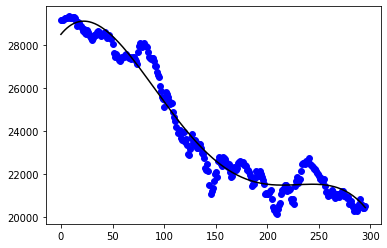

2022-06-17T05:00:00, ORDER EXPIRED
2022-06-17T05:00:00, Order Canceled


2022-06-17T05:00:00, Close, 20724.05
2022-08-21 16:55:03:  --- Position Begin
- Size: 3.6055010292726806
- Price: 20674.026425179352
- Price orig: 20674.026425179352
- Closed: -0.000720760650584429
- Opened: 0
- Adjbase: 20724.05
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        7.073005881089448
-----Order price:        20912.688530425803
-----Order Type:        2
-----Trail Amount:        None
-----Trail Percent:        None
-----Created Price:        20912.688530425803
-----Is Buy:        False
-----Asset:             BTCUSD
-----Order Size:        0.0006225748956590503
-----Order price:        19975.721556414388
-----Order Type:        2
-----Trail Amount:        None
-----Trail Percent:        None
-----Created Price:        19975.721556414388
-----Is Buy:        True
2022-06-17T05:00:00, predict, and max, min 20453.77,  21516.89,19390.65,
Portfolio 75480.1311265827 the oth

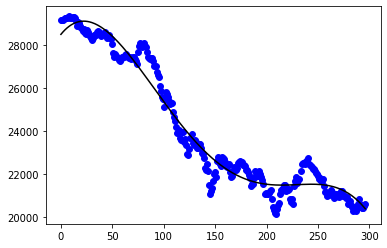

2022-06-17T05:30:00, ORDER EXPIRED
2022-06-17T05:30:00, Order Canceled
Limit ordering
2022-06-17T05:30:00, SELL EXECUTED, Price: 20854.88, Costed Total Of: 148793.85, Comm 0.00
2022-06-17T05:30:00, Order Canceled
2022-06-17T05:30:00, OPERATION PROFIT, GROSS 652.14, NET 652.14


2022-06-17T05:30:00, Close, 20778.71
2022-08-21 16:55:03:  --- Position Begin
- Size: -3.5604917080727256
- Price: 20854.879274741856
- Price orig: 20674.026425179352
- Closed: -3.6055010292726806
- Opened: -3.5604917080727256
- Adjbase: 20778.71
--- Position End
Open Orders: 
2022-06-17T05:30:00, predict, and max, min 20395.86,  21458.03,19333.70,
Portfolio 76223.03628245174 the other one 1698.2114807473263
2022-08-21 16:55:03:  In Downtrend
2022-06-17: Limit Order / Buy at 19858.493044373176
2022-06-17: Limit Order / Sell at 20794.654117031143
current model value 20335.886164057585 predicted model next value 20273.795030050627


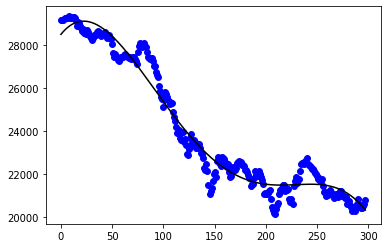

2022-06-17T06:00:00, Insufficient Margin for order of type 2
2022-06-17T06:00:00, Order Canceled


2022-06-17T06:00:00, Close, 20701.48
2022-08-21 16:55:03:  --- Position Begin
- Size: -3.5604917080727256
- Price: 20854.879274741856
- Price orig: 20674.026425179352
- Closed: -3.6055010292726806
- Opened: -3.5604917080727256
- Adjbase: 20701.48
--- Position End
Open Orders: 
2022-06-17T06:00:00, predict, and max, min 20335.89,  21396.27,19275.50,
Portfolio 76498.0130570662 the other one 1698.2114807473263
2022-08-21 16:55:03:  In Downtrend
2022-06-17: Limit Order / Buy at 19796.881819291342
2022-06-17: Limit Order / Sell at 20732.1017974182
current model value 20273.795030050627 predicted model next value 20209.54853509402


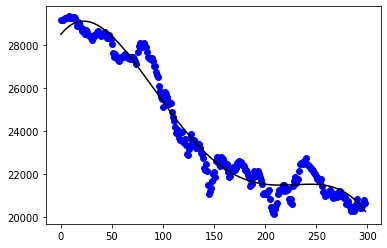

2022-06-17T06:30:00, Insufficient Margin for order of type 2
2022-06-17T06:30:00, Order Canceled


2022-06-17T06:30:00, Close, 20869.86
2022-08-21 16:55:03:  --- Position Begin
- Size: -3.5604917080727256
- Price: 20854.879274741856
- Price orig: 20674.026425179352
- Closed: -3.6055010292726806
- Opened: -3.5604917080727256
- Adjbase: 20869.86
--- Position End
Open Orders: 
2022-06-17T06:30:00, predict, and max, min 20273.80,  21332.48,19215.11,
Portfolio 75898.49746326091 the other one 1698.2114807473263
2022-08-21 16:55:03:  In Downtrend
sell value 20666.41378630597
current model value 20209.54853509402 predicted model next value 20143.104474012136


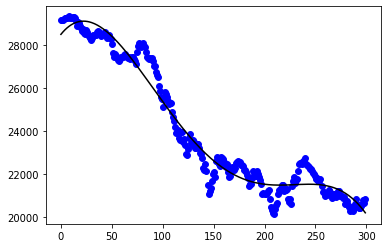



2022-06-17T07:00:00, Close, 21095.17
2022-08-21 16:55:03:  --- Position Begin
- Size: -3.5604917080727256
- Price: 20854.879274741856
- Price orig: 20674.026425179352
- Closed: -3.6055010292726806
- Opened: -3.5604917080727256
- Adjbase: 21095.17
--- Position End
Open Orders: 
2022-06-17T07:00:00, predict, and max, min 20209.55,  21266.85,19152.24,
Portfolio 75096.28307651504 the other one 1698.2114807473263
2022-08-21 16:55:03:  In Downtrend
sell value 20599.612886023686
current model value 20143.104474012136 predicted model next value 20074.420336181858


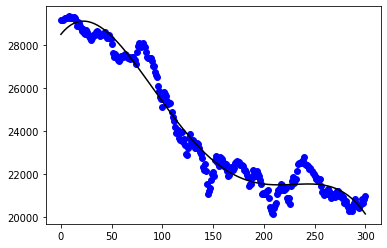



2022-06-17T07:30:00, Close, 21067.64
2022-08-21 16:55:03:  --- Position Begin
- Size: -3.5604917080727256
- Price: 20854.879274741856
- Price orig: 20674.026425179352
- Closed: -3.6055010292726806
- Opened: -3.5604917080727256
- Adjbase: 21067.64
--- Position End
Open Orders: 
2022-06-17T07:30:00, predict, and max, min 20143.10,  21200.59,19085.62,
Portfolio 75194.30341323829 the other one 1698.2114807473263
2022-08-21 16:55:03:  In Downtrend
sell value 20530.974978121198
current model value 20074.420336181858 predicted model next value 20003.453305532552


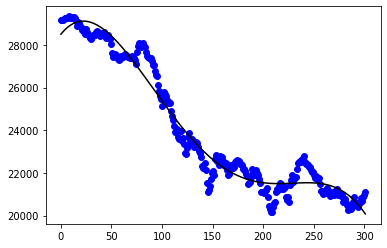



2022-06-17T08:00:00, Close, 21203.45
2022-08-21 16:55:03:  --- Position Begin
- Size: -3.5604917080727256
- Price: 20854.879274741856
- Price orig: 20674.026425179352
- Closed: -3.6055010292726806
- Opened: -3.5604917080727256
- Adjbase: 21203.45
--- Position End
Open Orders: 
2022-06-17T08:00:00, predict, and max, min 20074.42,  21134.31,19014.53,
Portfolio 74710.75303436493 the other one 1698.2114807473263
2022-08-21 16:55:03:  Finding the best model and optimizing time...
2022-08-21 16:55:08:  FInished computing all models... Finding and returning best model
2022-08-21 16:55:08:  Remodeling inaccurate model...
2022-08-21 16:55:09:  Close all short positions here
current model value 20356.45891959284 predicted model next value 20307.027886064283


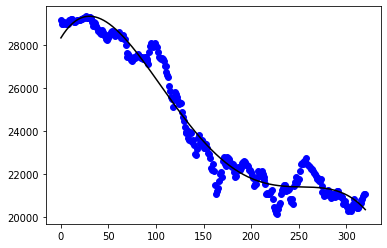

2022-06-17T08:30:00, BUY EXECUTED, Price: 21203.45, Costed Total Of: 74253.62, Comm 0.00
2022-06-17T08:30:00, OPERATION PROFIT, GROSS -1241.08, NET -1241.08


2022-06-17T08:30:00, Close, 21036.68
2022-08-21 16:55:09:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 20854.879274741856
- Closed: 3.5604917080727256
- Opened: 0
- Adjbase: 21203.45
--- Position End
Open Orders: 
2022-06-17T08:30:00, predict, and max, min 20356.46,  21522.30,19190.61,
Portfolio 74710.75303436493 the other one 74710.75303436493
2022-08-21 16:55:09:  In Downtrend
sell value 20809.418687472622
2022-06-17T08:30:00, SELL CREATE, 21036.68 and now rebalancing portfolio
current model value 20307.027886064283 predicted model next value 20255.962054148895


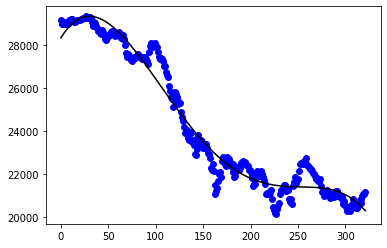

2022-06-17T09:00:00, SELL EXECUTED, Price: 21036.68, Costed Total Of: 73963.65, Comm 0.00


2022-06-17T09:00:00, Close, 21064.47
2022-08-21 16:55:09:  --- Position Begin
- Size: -3.5159371870476366
- Price: 21036.68
- Price orig: 0.0
- Closed: 0
- Opened: -3.5159371870476366
- Adjbase: 21064.47
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        3.5159371870476366
-----Order price:        None
-----Order Type:        5
-----Trail Amount:        350
-----Trail Percent:        None
-----Created Price:        21386.68
-----Is Buy:        True
2022-06-17T09:00:00, predict, and max, min 20307.03,  21473.01,19141.05,
Portfolio 74613.04513993688 the other one 747.1075303436519
2022-08-21 16:55:09:  In Downtrend
sell value 20758.38856121108
current model value 20255.962054148895 predicted model next value 20203.229472635325


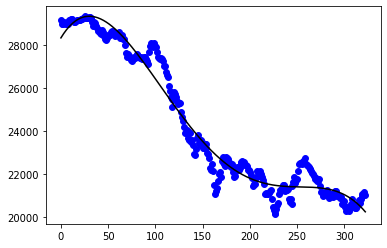



2022-06-17T09:30:00, Close, 20947.33
2022-08-21 16:55:09:  --- Position Begin
- Size: -3.5159371870476366
- Price: 21036.68
- Price orig: 0.0
- Closed: 0
- Opened: -3.5159371870476366
- Adjbase: 20947.33
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        3.5159371870476366
-----Order price:        None
-----Order Type:        5
-----Trail Amount:        350
-----Trail Percent:        None
-----Created Price:        21297.33
-----Is Buy:        True
2022-06-17T09:30:00, predict, and max, min 20255.96,  21421.41,19090.52,
Portfolio 75024.90202202763 the other one 747.1075303436519
2022-08-21 16:55:09:  In Downtrend
sell value 20706.553507794353
current model value 20203.229472635325 predicted model next value 20148.79796566402


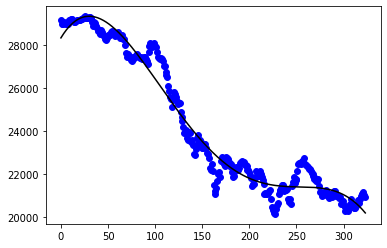



2022-06-17T10:00:00, Close, 20919.84
2022-08-21 16:55:09:  --- Position Begin
- Size: -3.5159371870476366
- Price: 21036.68
- Price orig: 0.0
- Closed: 0
- Opened: -3.5159371870476366
- Adjbase: 20919.84
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        3.5159371870476366
-----Order price:        None
-----Order Type:        5
-----Trail Amount:        350
-----Trail Percent:        None
-----Created Price:        21269.84
-----Is Buy:        True
2022-06-17T10:00:00, predict, and max, min 20203.23,  21367.95,19038.51,
Portfolio 75121.55513529957 the other one 747.1075303436519
2022-08-21 16:55:09:  In Downtrend
sell value 20651.934775856942
current model value 20148.79796566402 predicted model next value 20092.6351327275


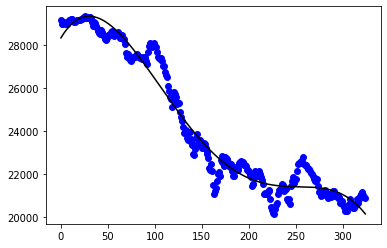



2022-06-17T10:30:00, Close, 21092.16
2022-08-21 16:55:09:  --- Position Begin
- Size: -3.5159371870476366
- Price: 21036.68
- Price orig: 0.0
- Closed: 0
- Opened: -3.5159371870476366
- Adjbase: 21092.16
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        3.5159371870476366
-----Order price:        None
-----Order Type:        5
-----Trail Amount:        350
-----Trail Percent:        None
-----Created Price:        21269.84
-----Is Buy:        True
2022-06-17T10:30:00, predict, and max, min 20148.80,  21312.85,18984.74,
Portfolio 74515.68883922753 the other one 747.1075303436519
2022-08-21 16:55:09:  In Downtrend
sell value 20595.59943525756
current model value 20092.6351327275 predicted model next value 20034.708348670272


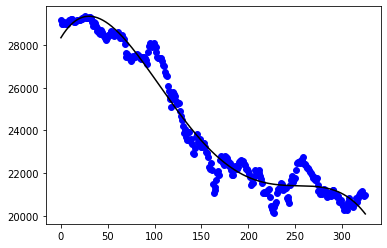



2022-06-17T11:00:00, Close, 21100.46
2022-08-21 16:55:09:  --- Position Begin
- Size: -3.5159371870476366
- Price: 21036.68
- Price orig: 0.0
- Closed: 0
- Opened: -3.5159371870476366
- Adjbase: 21100.46
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        3.5159371870476366
-----Order price:        None
-----Order Type:        5
-----Trail Amount:        350
-----Trail Percent:        None
-----Created Price:        21269.84
-----Is Buy:        True
2022-06-17T11:00:00, predict, and max, min 20092.64,  21257.11,18928.16,
Portfolio 74486.50656057503 the other one 747.1075303436519
2022-08-21 16:55:09:  In Downtrend
sell value 20537.78125828505
current model value 20034.708348670272 predicted model next value 19974.98476368865


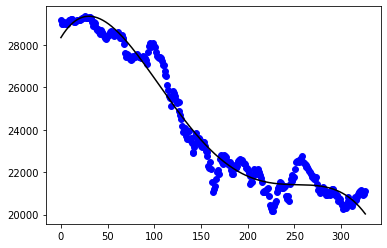



2022-06-17T11:30:00, Close, 20951.63
2022-08-21 16:55:10:  --- Position Begin
- Size: -3.5159371870476366
- Price: 21036.68
- Price orig: 0.0
- Closed: 0
- Opened: -3.5159371870476366
- Adjbase: 20951.63
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        3.5159371870476366
-----Order price:        None
-----Order Type:        5
-----Trail Amount:        350
-----Trail Percent:        None
-----Created Price:        21269.84
-----Is Buy:        True
2022-06-17T11:30:00, predict, and max, min 20034.71,  21201.87,18867.55,
Portfolio 75009.78349212333 the other one 747.1075303436519
2022-08-21 16:55:10:  In Downtrend
sell value 20478.753291587924
current model value 19974.98476368865 predicted model next value 19913.431303331145


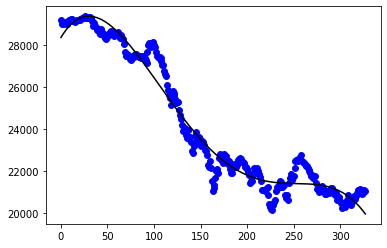



2022-06-17T12:00:00, Close, 20883.26
2022-08-21 16:55:10:  --- Position Begin
- Size: -3.5159371870476366
- Price: 21036.68
- Price orig: 0.0
- Closed: 0
- Opened: -3.5159371870476366
- Adjbase: 20883.26
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        3.5159371870476366
-----Order price:        None
-----Order Type:        5
-----Trail Amount:        350
-----Trail Percent:        None
-----Created Price:        21233.26
-----Is Buy:        True
2022-06-17T12:00:00, predict, and max, min 19974.98,  21145.33,18804.64,
Portfolio 75250.16811760179 the other one 747.1075303436519
2022-08-21 16:55:10:  In Downtrend
sell value 20421.557783681696
current model value 19913.431303331145 predicted model next value 19850.01466849807


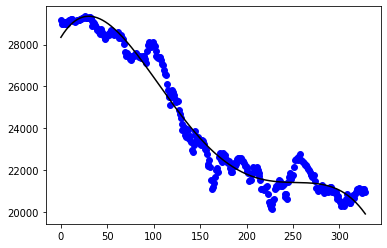



2022-06-17T12:30:00, Close, 20619.22
2022-08-21 16:55:10:  --- Position Begin
- Size: -3.5159371870476366
- Price: 21036.68
- Price orig: 0.0
- Closed: 0
- Opened: -3.5159371870476366
- Adjbase: 20619.22
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        3.5159371870476366
-----Order price:        None
-----Order Type:        5
-----Trail Amount:        350
-----Trail Percent:        None
-----Created Price:        20969.22
-----Is Buy:        True
2022-06-17T12:30:00, predict, and max, min 19913.43,  21086.03,18740.83,
Portfolio 76178.51617246983 the other one 747.1075303436519
2022-08-21 16:55:10:  In Downtrend
sell value 20358.729271928518
current model value 19850.01466849807 predicted model next value 19784.701335441696


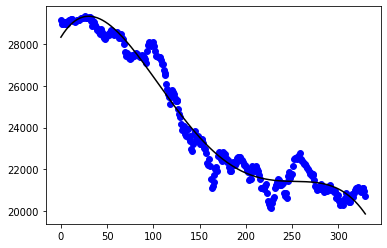



2022-06-17T13:00:00, Close, 20599.62
2022-08-21 16:55:10:  --- Position Begin
- Size: -3.5159371870476366
- Price: 21036.68
- Price orig: 0.0
- Closed: 0
- Opened: -3.5159371870476366
- Adjbase: 20599.62
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        3.5159371870476366
-----Order price:        None
-----Order Type:        5
-----Trail Amount:        350
-----Trail Percent:        None
-----Created Price:        20949.62
-----Is Buy:        True
2022-06-17T13:00:00, predict, and max, min 19850.01,  21022.73,18677.30,
Portfolio 76247.42854133598 the other one 747.1075303436519
2022-08-21 16:55:10:  In Downtrend
sell value 20293.445223734772
current model value 19784.701335441696 predicted model next value 19717.457555766403


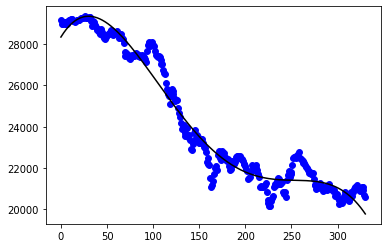



2022-06-17T13:30:00, Close, 20775.82
2022-08-21 16:55:10:  --- Position Begin
- Size: -3.5159371870476366
- Price: 21036.68
- Price orig: 0.0
- Closed: 0
- Opened: -3.5159371870476366
- Adjbase: 20775.82
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        3.5159371870476366
-----Order price:        None
-----Order Type:        5
-----Trail Amount:        350
-----Trail Percent:        None
-----Created Price:        20949.62
-----Is Buy:        True
2022-06-17T13:30:00, predict, and max, min 19784.70,  20957.05,18612.35,
Portfolio 75627.92040897817 the other one 747.1075303436519
2022-08-21 16:55:10:  In Downtrend
sell value 20226.107197456626
current model value 19717.457555766403 predicted model next value 19648.249356428318


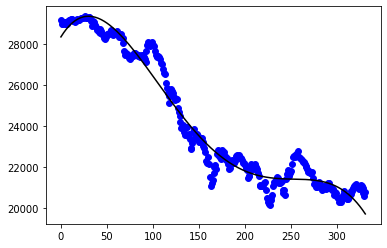



2022-06-17T14:00:00, Close, 20459.62
2022-08-21 16:55:10:  --- Position Begin
- Size: -3.5159371870476366
- Price: 21036.68
- Price orig: 0.0
- Closed: 0
- Opened: -3.5159371870476366
- Adjbase: 20459.62
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        3.5159371870476366
-----Order price:        None
-----Order Type:        5
-----Trail Amount:        350
-----Trail Percent:        None
-----Created Price:        20809.62
-----Is Buy:        True
2022-06-17T14:00:00, predict, and max, min 19717.46,  20892.00,18542.92,
Portfolio 76739.65974752264 the other one 747.1075303436519
2022-08-21 16:55:10:  In Downtrend
sell value 20157.46921142531
current model value 19648.249356428318 predicted model next value 19577.042539735758


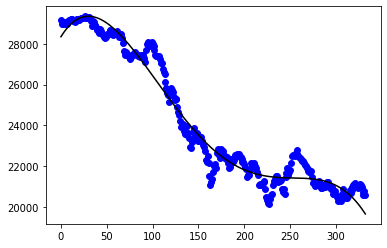



2022-06-17T14:30:00, Close, 20528.73
2022-08-21 16:55:10:  --- Position Begin
- Size: -3.5159371870476366
- Price: 21036.68
- Price orig: 0.0
- Closed: 0
- Opened: -3.5159371870476366
- Adjbase: 20528.73
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        3.5159371870476366
-----Order price:        None
-----Order Type:        5
-----Trail Amount:        350
-----Trail Percent:        None
-----Created Price:        20809.62
-----Is Buy:        True
2022-06-17T14:30:00, predict, and max, min 19648.25,  20823.28,18473.21,
Portfolio 76496.67332852578 the other one 747.1075303436519
2022-08-21 16:55:10:  In Downtrend
sell value 20089.349206851395
current model value 19577.042539735758 predicted model next value 19503.802683348837


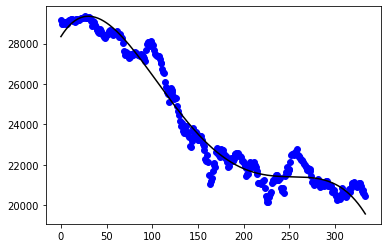



2022-06-17T15:00:00, Close, 20625.49
2022-08-21 16:55:10:  --- Position Begin
- Size: -3.5159371870476366
- Price: 21036.68
- Price orig: 0.0
- Closed: 0
- Opened: -3.5159371870476366
- Adjbase: 20625.49
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        3.5159371870476366
-----Order price:        None
-----Order Type:        5
-----Trail Amount:        350
-----Trail Percent:        None
-----Created Price:        20809.62
-----Is Buy:        True
2022-06-17T15:00:00, predict, and max, min 19577.04,  20752.49,18401.60,
Portfolio 76156.47124630705 the other one 747.1075303436519
2022-08-21 16:55:10:  In Downtrend
sell value 20016.217159300042
current model value 19503.802683348837 predicted model next value 19428.495140279727


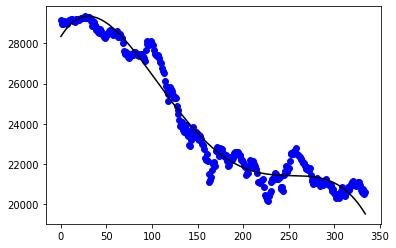



2022-06-17T15:30:00, Close, 20639.67
2022-08-21 16:55:10:  --- Position Begin
- Size: -3.5159371870476366
- Price: 21036.68
- Price orig: 0.0
- Closed: 0
- Opened: -3.5159371870476366
- Adjbase: 20639.67
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        3.5159371870476366
-----Order price:        None
-----Order Type:        5
-----Trail Amount:        350
-----Trail Percent:        None
-----Created Price:        20809.62
-----Is Buy:        True
2022-06-17T15:30:00, predict, and max, min 19503.80,  20682.17,18325.44,
Portfolio 76106.61525699472 the other one 747.1075303436519
2022-08-21 16:55:10:  In Downtrend
sell value 19941.672914031325
current model value 19428.495140279727 predicted model next value 19351.08503889253


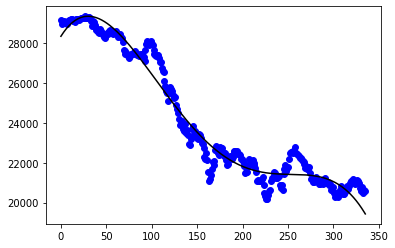



2022-06-17T16:00:00, Close, 20668.77
2022-08-21 16:55:10:  --- Position Begin
- Size: -3.5159371870476366
- Price: 21036.68
- Price orig: 0.0
- Closed: 0
- Opened: -3.5159371870476366
- Adjbase: 20668.77
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        3.5159371870476366
-----Order price:        None
-----Order Type:        5
-----Trail Amount:        350
-----Trail Percent:        None
-----Created Price:        20809.62
-----Is Buy:        True
2022-06-17T16:00:00, predict, and max, min 19428.50,  20610.61,18246.38,
Portfolio 76004.30148485162 the other one 747.1075303436519
2022-08-21 16:55:10:  Finding the best model and optimizing time...
2022-08-21 16:55:16:  FInished computing all models... Finding and returning best model
2022-08-21 16:55:16:  Remodeling inaccurate model...
2022-08-21 16:55:16:  Close all short positions here
current model value 20208.519633655294 predicted model next value 20156.94109627944


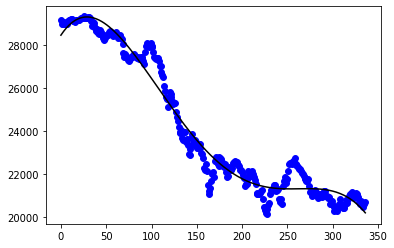

2022-06-17T16:30:00, Order Canceled
2022-06-17T16:30:00, BUY EXECUTED, Price: 20668.77, Costed Total Of: 73963.65, Comm 0.00
2022-06-17T16:30:00, OPERATION PROFIT, GROSS 1293.55, NET 1293.55


2022-06-17T16:30:00, Close, 20554.92
2022-08-21 16:55:16:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 21036.68
- Closed: 3.5159371870476366
- Opened: 0
- Adjbase: 20668.77
--- Position End
Open Orders: 
2022-06-17T16:30:00, predict, and max, min 20208.52,  21367.52,19049.52,
Portfolio 76004.30148485162 the other one 76004.30148485162
2022-08-21 16:55:16:  In Downtrend
2022-06-17: Limit Order / Buy at 19646.00686789968
2022-06-17: Limit Order / Sell at 20656.485543404866
current model value 20156.94109627944 predicted model next value 20103.74304588467


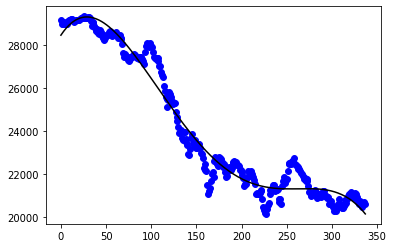

Limit ordering
2022-06-17T17:00:00, SELL EXECUTED, Price: 20656.49, Costed Total Of: 75244.26, Comm 0.00
2022-06-17T17:00:00, Order Canceled


2022-06-17T17:00:00, Close, 20567.99
2022-08-21 16:55:16:  --- Position Begin
- Size: -3.6426457110477264
- Price: 20656.485543404866
- Price orig: 0.0
- Closed: 0
- Opened: -3.6426457110477264
- Adjbase: 20567.99
--- Position End
Open Orders: 
2022-06-17T17:00:00, predict, and max, min 20156.94,  21314.23,18999.66,
Portfolio 76326.65939648218 the other one 760.0430148485175
2022-08-21 16:55:16:  In Downtrend
2022-06-17: Limit Order / Buy at 19593.26243792701
2022-06-17: Limit Order / Sell at 20601.657430003932
current model value 20103.74304588467 predicted model next value 20048.8962884181


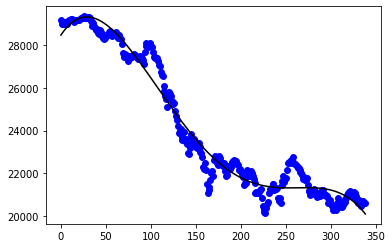

2022-06-17T17:30:00, Insufficient Margin for order of type 2
2022-06-17T17:30:00, Order Canceled


2022-06-17T17:30:00, Close, 20570.66
2022-08-21 16:55:16:  --- Position Begin
- Size: -3.6426457110477264
- Price: 20656.485543404866
- Price orig: 0.0
- Closed: 0
- Opened: -3.6426457110477264
- Adjbase: 20570.66
--- Position End
Open Orders: 
2022-06-17T17:30:00, predict, and max, min 20103.74,  21259.35,18948.14,
Portfolio 76316.9335324337 the other one 760.0430148485175
2022-08-21 16:55:16:  In Downtrend
sell value 20546.377206379624
current model value 20048.8962884181 predicted model next value 19992.371438181613


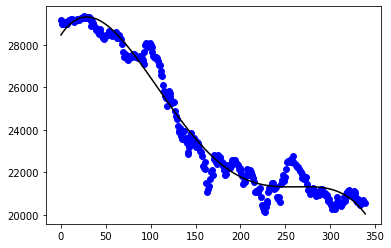



2022-06-17T18:00:00, Close, 20574.06
2022-08-21 16:55:16:  --- Position Begin
- Size: -3.6426457110477264
- Price: 20656.485543404866
- Price orig: 0.0
- Closed: 0
- Opened: -3.6426457110477264
- Adjbase: 20574.06
--- Position End
Open Orders: 
2022-06-17T18:00:00, predict, and max, min 20048.90,  21202.83,18894.96,
Portfolio 76304.54853701612 the other one 760.0430148485175
2022-08-21 16:55:16:  In Downtrend
sell value 20489.420548750873
current model value 19992.371438181613 predicted model next value 19934.138917831708


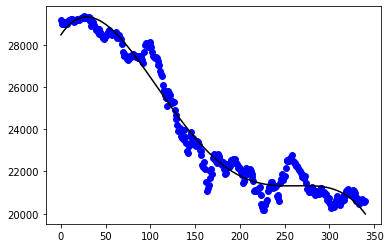



2022-06-17T18:30:00, Close, 20496.91
2022-08-21 16:55:16:  --- Position Begin
- Size: -3.6426457110477264
- Price: 20656.485543404866
- Price orig: 0.0
- Closed: 0
- Opened: -3.6426457110477264
- Adjbase: 20496.91
--- Position End
Open Orders: 
2022-06-17T18:30:00, predict, and max, min 19992.37,  21144.87,18839.87,
Portfolio 76585.57865362347 the other one 760.0430148485175
2022-08-21 16:55:16:  In Downtrend
sell value 20430.816903430386
current model value 19934.138917831708 predicted model next value 19874.1689583797


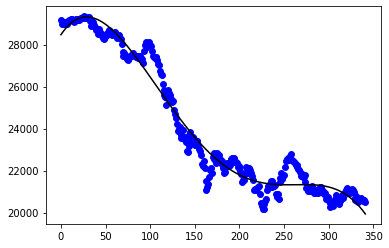



2022-06-17T19:00:00, Close, 20462.96
2022-08-21 16:55:16:  --- Position Begin
- Size: -3.6426457110477264
- Price: 20656.485543404866
- Price orig: 0.0
- Closed: 0
- Opened: -3.6426457110477264
- Adjbase: 20462.96
--- Position End
Open Orders: 
2022-06-17T19:00:00, predict, and max, min 19934.14,  21085.10,18783.17,
Portfolio 76709.24647551353 the other one 760.0430148485175
2022-08-21 16:55:16:  In Downtrend
sell value 20369.704829469305
current model value 19874.1689583797 predicted model next value 19812.431599191685


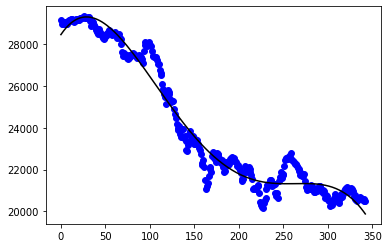



2022-06-17T19:30:00, Close, 20494.16
2022-08-21 16:55:17:  --- Position Begin
- Size: -3.6426457110477264
- Price: 20656.485543404866
- Price orig: 0.0
- Closed: 0
- Opened: -3.6426457110477264
- Adjbase: 20494.16
--- Position End
Open Orders: 
2022-06-17T19:30:00, predict, and max, min 19874.17,  21023.73,18724.61,
Portfolio 76595.59592932885 the other one 760.0430148485175
2022-08-21 16:55:17:  In Downtrend
sell value 20307.60432597045
current model value 19812.431599191685 predicted model next value 19748.896687988385


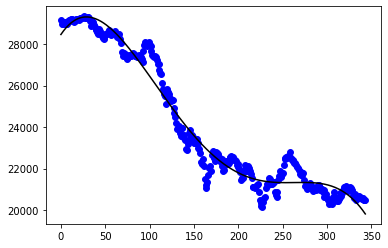



2022-06-17T20:00:00, Close, 20668.75
2022-08-21 16:55:17:  --- Position Begin
- Size: -3.6426457110477264
- Price: 20656.485543404866
- Price orig: 0.0
- Closed: 0
- Opened: -3.6426457110477264
- Adjbase: 20668.75
--- Position End
Open Orders: 
2022-06-17T20:00:00, predict, and max, min 19812.43,  20960.85,18664.01,
Portfolio 75959.62641463702 the other one 760.0430148485175
2022-08-21 16:55:17:  In Downtrend
sell value 20243.77449655714
current model value 19748.896687988385 predicted model next value 19683.53388084521


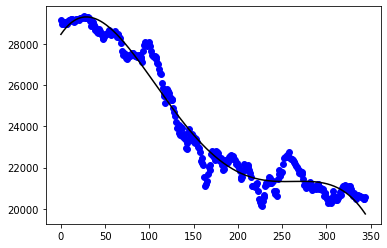



2022-06-17T20:30:00, Close, 20629.04
2022-08-21 16:55:17:  --- Position Begin
- Size: -3.6426457110477264
- Price: 20656.485543404866
- Price orig: 0.0
- Closed: 0
- Opened: -3.6426457110477264
- Adjbase: 20629.04
--- Position End
Open Orders: 
2022-06-17T20:30:00, predict, and max, min 19748.90,  20897.40,18600.39,
Portfolio 76104.27587582273 the other one 760.0430148485175
2022-08-21 16:55:17:  In Downtrend
sell value 20178.43312785711
current model value 19683.53388084521 predicted model next value 19616.312642192457


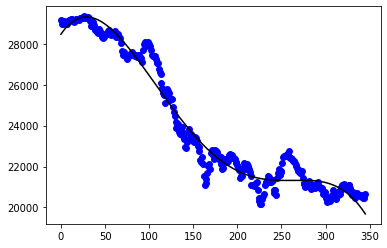



2022-06-17T21:00:00, Close, 20556.74
2022-08-21 16:55:17:  --- Position Begin
- Size: -3.6426457110477264
- Price: 20656.485543404866
- Price orig: 0.0
- Closed: 0
- Opened: -3.6426457110477264
- Adjbase: 20556.74
--- Position End
Open Orders: 
2022-06-17T21:00:00, predict, and max, min 19683.53,  20833.18,18533.88,
Portfolio 76367.63916073147 the other one 760.0430148485175
2022-08-21 16:55:17:  In Downtrend
sell value 20111.50895130547
current model value 19616.312642192457 predicted model next value 19547.202244815013


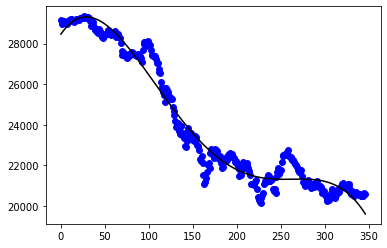



2022-06-17T21:30:00, Close, 20533.58
2022-08-21 16:55:17:  --- Position Begin
- Size: -3.6426457110477264
- Price: 20656.485543404866
- Price orig: 0.0
- Closed: 0
- Opened: -3.6426457110477264
- Adjbase: 20533.58
--- Position End
Open Orders: 
2022-06-17T21:30:00, predict, and max, min 19616.31,  20767.33,18465.29,
Portfolio 76452.00283539934 the other one 760.0430148485175
2022-08-21 16:55:17:  In Downtrend
sell value 20044.72359836881
current model value 19547.202244815013 predicted model next value 19476.17176985249


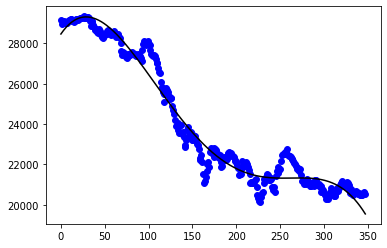



2022-06-17T22:00:00, Close, 20397.39
2022-08-21 16:55:17:  --- Position Begin
- Size: -3.6426457110477264
- Price: 20656.485543404866
- Price orig: 0.0
- Closed: 0
- Opened: -3.6426457110477264
- Adjbase: 20397.39
--- Position End
Open Orders: 
2022-06-17T22:00:00, predict, and max, min 19547.20,  20699.75,18394.66,
Portfolio 76948.09475478693 the other one 760.0430148485175
2022-08-21 16:55:17:  In Downtrend
sell value 19974.089206378383
current model value 19476.17176985249 predicted model next value 19403.19010679922


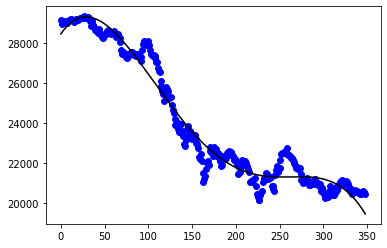



2022-06-17T22:30:00, Close, 20426.58
2022-08-21 16:55:17:  --- Position Begin
- Size: -3.6426457110477264
- Price: 20656.485543404866
- Price orig: 0.0
- Closed: 0
- Opened: -3.6426457110477264
- Adjbase: 20426.58
--- Position End
Open Orders: 
2022-06-17T22:30:00, predict, and max, min 19476.17,  20630.22,18322.12,
Portfolio 76841.76592648144 the other one 760.0430148485175
2022-08-21 16:55:17:  In Downtrend
sell value 19901.496872939366
current model value 19403.19010679922 predicted model next value 19328.225953504418


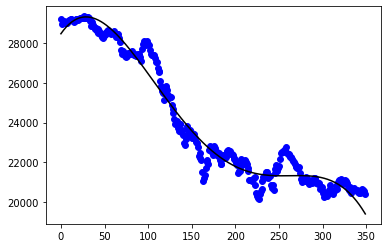



2022-06-17T23:00:00, Close, 20516.91
2022-08-21 16:55:17:  --- Position Begin
- Size: -3.6426457110477264
- Price: 20656.485543404866
- Price orig: 0.0
- Closed: 0
- Opened: -3.6426457110477264
- Adjbase: 20516.91
--- Position End
Open Orders: 
2022-06-17T23:00:00, predict, and max, min 19403.19,  20558.90,18247.48,
Portfolio 76512.72573940251 the other one 760.0430148485175
2022-08-21 16:55:17:  In Downtrend
sell value 19826.963012756725
current model value 19328.225953504418 predicted model next value 19251.24781617182


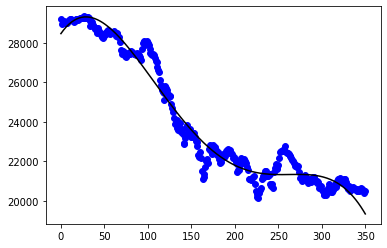



2022-06-17T23:30:00, Close, 20447.86
2022-08-21 16:55:18:  --- Position Begin
- Size: -3.6426457110477264
- Price: 20656.485543404866
- Price orig: 0.0
- Closed: 0
- Opened: -3.6426457110477264
- Adjbase: 20447.86
--- Position End
Open Orders: 
2022-06-17T23:30:00, predict, and max, min 19328.23,  20487.35,18169.10,
Portfolio 76764.25042575035 the other one 760.0430148485175
2022-08-21 16:55:18:  In Downtrend
sell value 19750.86921053488
current model value 19251.24781617182 predicted model next value 19172.224009359987


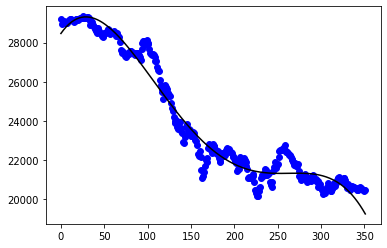



2022-06-18T00:00:00, Close, 20674.62
2022-08-21 16:55:18:  --- Position Begin
- Size: -3.6426457110477264
- Price: 20656.485543404866
- Price orig: 0.0
- Closed: 0
- Opened: -3.6426457110477264
- Adjbase: 20674.62
--- Position End
Open Orders: 
2022-06-18T00:00:00, predict, and max, min 19251.25,  20414.94,18087.55,
Portfolio 75938.24408431318 the other one 760.0430148485175
2022-08-21 16:55:18:  Finding the best model and optimizing time...
2022-08-21 16:55:23:  FInished computing all models... Finding and returning best model
2022-08-21 16:55:23:  Remodeling inaccurate model...
2022-08-21 16:55:23:  Close all short positions here
current model value 20866.986270234298 predicted model next value 20874.708720391383


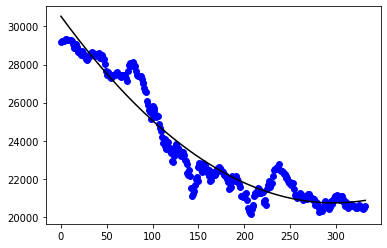

2022-06-18T00:30:00, BUY EXECUTED, Price: 20674.62, Costed Total Of: 75244.26, Comm 0.00
2022-06-18T00:30:00, OPERATION PROFIT, GROSS -66.06, NET -66.06


2022-06-18T00:30:00, Close, 20546.73
2022-08-21 16:55:23:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 20656.485543404866
- Closed: 3.6426457110477264
- Opened: 0
- Adjbase: 20674.62
--- Position End
Open Orders: 
2022-06-18T00:30:00, predict, and max, min 20866.99,  22340.31,19393.67,
Portfolio 75938.24408431318 the other one 75938.24408431318
2022-08-21 16:55:23:  In Uptrend
2022-06-18: Limit Order / Buy at 20228.86547883026
2022-06-18: Limit Order / Sell at 21511.45010885814
current model value 20874.708720391383 predicted model next value 20882.652457596323


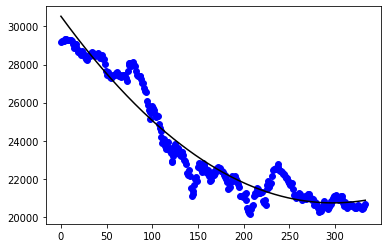



2022-06-18T01:00:00, Close, 20468.20
2022-08-21 16:55:23:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 20656.485543404866
- Closed: 3.6426457110477264
- Opened: 0
- Adjbase: 20674.62
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        3.4948300213620813
-----Order price:        21511.45010885814
-----Order Type:        2
-----Trail Amount:        None
-----Trail Percent:        None
-----Created Price:        21511.45010885814
-----Is Buy:        False
-----Asset:             BTCUSD
-----Order Size:        3.716415125808493
-----Order price:        20228.86547883026
-----Order Type:        2
-----Trail Amount:        None
-----Trail Percent:        None
-----Created Price:        20228.86547883026
-----Is Buy:        True
2022-06-18T01:00:00, predict, and max, min 20874.71,  22347.09,19402.32,
Portfolio 75938.24408431318 the other one 75938.24408431318
2022-08-21 16:55:23:  In Uptrend
2022-06-18: Limit Order / Buy at 20237.05496022823
2

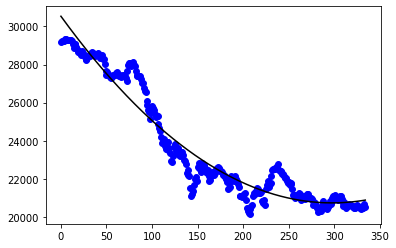

2022-06-18T01:30:00, ORDER EXPIRED
2022-06-18T01:30:00, Order Canceled


2022-06-18T01:30:00, Close, 20360.00
2022-08-21 16:55:23:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 20656.485543404866
- Closed: 3.6426457110477264
- Opened: 0
- Adjbase: 20674.62
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        3.4935792619847876
-----Order price:        21519.15156513698
-----Order Type:        2
-----Trail Amount:        None
-----Trail Percent:        None
-----Created Price:        21519.15156513698
-----Is Buy:        False
-----Asset:             BTCUSD
-----Order Size:        3.7149111761181968
-----Order price:        20237.05496022823
-----Order Type:        2
-----Trail Amount:        None
-----Trail Percent:        None
-----Created Price:        20237.05496022823
-----Is Buy:        True
2022-06-18T01:30:00, predict, and max, min 20882.65,  22353.23,19412.08,
Portfolio 75938.24408431318 the other one 75938.24408431318
2022-08-21 16

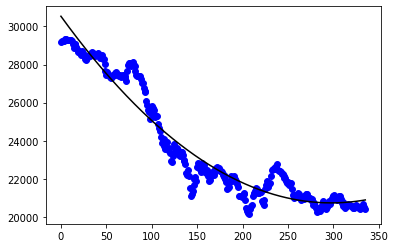

2022-06-18T02:00:00, ORDER EXPIRED
2022-06-18T02:00:00, Order Canceled


2022-06-18T02:00:00, Close, 20449.10
2022-08-21 16:55:24:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 20656.485543404866
- Closed: 3.6426457110477264
- Opened: 0
- Adjbase: 20674.62
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        3.4925319952453564
-----Order price:        21525.604273866815
-----Order Type:        2
-----Trail Amount:        None
-----Trail Percent:        None
-----Created Price:        21525.604273866815
-----Is Buy:        False
-----Asset:             BTCUSD
-----Order Size:        3.7133255909523224
-----Order price:        20245.696156202022
-----Order Type:        2
-----Trail Amount:        None
-----Trail Percent:        None
-----Created Price:        20245.696156202022
-----Is Buy:        True
2022-06-18T02:00:00, predict, and max, min 20890.82,  22359.28,19422.36,
Portfolio 75938.24408431318 the other one 75938.24408431318
2022-08-2

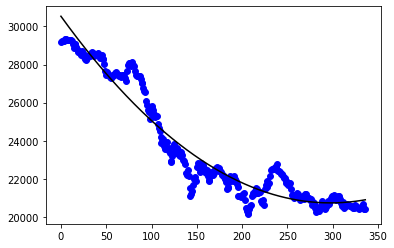

2022-06-18T02:30:00, ORDER EXPIRED
2022-06-18T02:30:00, Order Canceled


2022-06-18T02:30:00, Close, 20444.56
2022-08-21 16:55:24:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 20656.485543404866
- Closed: 3.6426457110477264
- Opened: 0
- Adjbase: 20674.62
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        3.4912607409234835
-----Order price:        21533.442278385734
-----Order Type:        2
-----Trail Amount:        None
-----Trail Percent:        None
-----Created Price:        21533.442278385734
-----Is Buy:        False
-----Asset:             BTCUSD
-----Order Size:        3.7116859521399355
-----Order price:        20254.639700895605
-----Order Type:        2
-----Trail Amount:        None
-----Trail Percent:        None
-----Created Price:        20254.639700895605
-----Is Buy:        True
2022-06-18T02:30:00, predict, and max, min 20899.20,  22365.55,19432.86,
Portfolio 75938.24408431318 the other one 75938.24408431318
2022-08-2

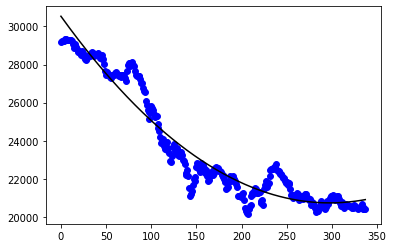

2022-06-18T03:00:00, ORDER EXPIRED
2022-06-18T03:00:00, Order Canceled


2022-06-18T03:00:00, Close, 20384.99
2022-08-21 16:55:24:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 20656.485543404866
- Closed: 3.6426457110477264
- Opened: 0
- Adjbase: 20674.62
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        3.4899545006732784
-----Order price:        21541.501939055826
-----Order Type:        2
-----Trail Amount:        None
-----Trail Percent:        None
-----Created Price:        21541.501939055826
-----Is Buy:        False
-----Asset:             BTCUSD
-----Order Size:        3.709708899334354
-----Order price:        20265.43421155219
-----Order Type:        2
-----Trail Amount:        None
-----Trail Percent:        None
-----Created Price:        20265.43421155219
-----Is Buy:        True
2022-06-18T03:00:00, predict, and max, min 20907.81,  22372.03,19443.59,
Portfolio 75938.24408431318 the other one 75938.24408431318
2022-08-21 1

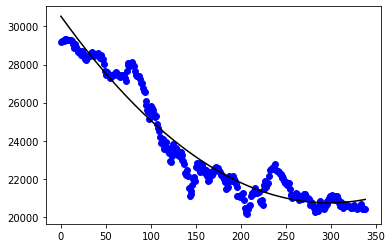

2022-06-18T03:30:00, ORDER EXPIRED
2022-06-18T03:30:00, Order Canceled


2022-06-18T03:30:00, Close, 20426.83
2022-08-21 16:55:24:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 20656.485543404866
- Closed: 3.6426457110477264
- Opened: 0
- Adjbase: 20674.62
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        3.4888916457349812
-----Order price:        21548.064335954066
-----Order Type:        2
-----Trail Amount:        None
-----Trail Percent:        None
-----Created Price:        21548.064335954066
-----Is Buy:        False
-----Asset:             BTCUSD
-----Order Size:        3.7079912507072454
-----Order price:        20274.82174590643
-----Order Type:        2
-----Trail Amount:        None
-----Trail Percent:        None
-----Created Price:        20274.82174590643
-----Is Buy:        True
2022-06-18T03:30:00, predict, and max, min 20916.64,  22378.75,19454.53,
Portfolio 75938.24408431318 the other one 75938.24408431318
2022-08-21 

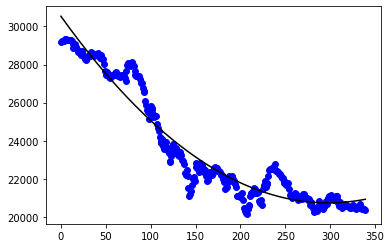

2022-06-18T04:00:00, ORDER EXPIRED
2022-06-18T04:00:00, Order Canceled


2022-06-18T04:00:00, Close, 20412.61
2022-08-21 16:55:24:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 20656.485543404866
- Closed: 3.6426457110477264
- Opened: 0
- Adjbase: 20674.62
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        3.487515317522338
-----Order price:        21556.568157779428
-----Order Type:        2
-----Trail Amount:        None
-----Trail Percent:        None
-----Created Price:        21556.568157779428
-----Is Buy:        False
-----Asset:             BTCUSD
-----Order Size:        3.7059456381880143
-----Order price:        20286.013067430747
-----Order Type:        2
-----Trail Amount:        None
-----Trail Percent:        None
-----Created Price:        20286.013067430747
-----Is Buy:        True
2022-06-18T04:00:00, predict, and max, min 20925.69,  22385.66,19465.72,
Portfolio 75938.24408431318 the other one 75938.24408431318
2022-08-21

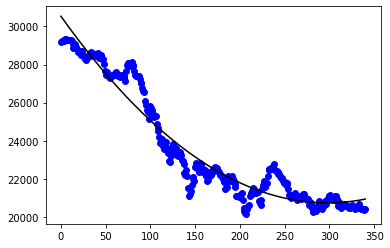

2022-06-18T04:30:00, ORDER EXPIRED
2022-06-18T04:30:00, Order Canceled


2022-06-18T04:30:00, Close, 20455.24
2022-08-21 16:55:24:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 20656.485543404866
- Closed: 3.6426457110477264
- Opened: 0
- Adjbase: 20674.62
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        3.4863741961273202
-----Order price:        21563.62381495912
-----Order Type:        2
-----Trail Amount:        None
-----Trail Percent:        None
-----Created Price:        21563.62381495912
-----Is Buy:        False
-----Asset:             BTCUSD
-----Order Size:        3.7041503105119835
-----Order price:        20295.845292811267
-----Order Type:        2
-----Trail Amount:        None
-----Trail Percent:        None
-----Created Price:        20295.845292811267
-----Is Buy:        True
2022-06-18T04:30:00, predict, and max, min 20934.96,  22392.82,19477.10,
Portfolio 75938.24408431318 the other one 75938.24408431318
2022-08-21 

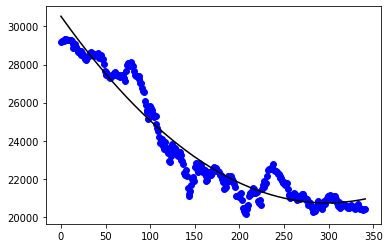

2022-06-18T05:00:00, ORDER EXPIRED
2022-06-18T05:00:00, Order Canceled


2022-06-18T05:00:00, Close, 20400.73
2022-08-21 16:55:24:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 20656.485543404866
- Closed: 3.6426457110477264
- Opened: 0
- Adjbase: 20674.62
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        3.484928430323539
-----Order price:        21572.569751881667
-----Order Type:        2
-----Trail Amount:        None
-----Trail Percent:        None
-----Created Price:        21572.569751881667
-----Is Buy:        False
-----Asset:             BTCUSD
-----Order Size:        3.702038669707568
-----Order price:        20307.422031712213
-----Order Type:        2
-----Trail Amount:        None
-----Trail Percent:        None
-----Created Price:        20307.422031712213
-----Is Buy:        True
2022-06-18T05:00:00, predict, and max, min 20944.45,  22400.22,19488.69,
Portfolio 75938.24408431318 the other one 75938.24408431318
2022-08-21 

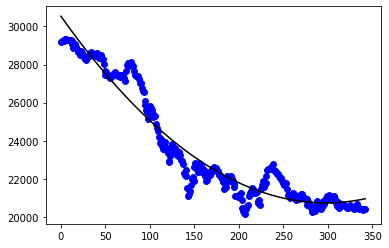

2022-06-18T05:30:00, ORDER EXPIRED
2022-06-18T05:30:00, Order Canceled


2022-06-18T05:30:00, Close, 20386.36
2022-08-21 16:55:24:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 20656.485543404866
- Closed: 3.6426457110477264
- Opened: 0
- Adjbase: 20674.62
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        3.483447162650674
-----Order price:        21581.743064609564
-----Order Type:        2
-----Trail Amount:        None
-----Trail Percent:        None
-----Created Price:        21581.743064609564
-----Is Buy:        False
-----Asset:             BTCUSD
-----Order Size:        3.7001687756618344
-----Order price:        20317.68446292645
-----Order Type:        2
-----Trail Amount:        None
-----Trail Percent:        None
-----Created Price:        20317.68446292645
-----Is Buy:        True
2022-06-18T05:30:00, predict, and max, min 20954.17,  22407.84,19500.50,
Portfolio 75938.24408431318 the other one 75938.24408431318
2022-08-21 1

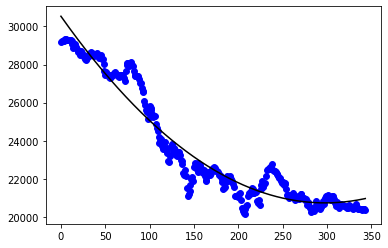

2022-06-18T06:00:00, ORDER EXPIRED
2022-06-18T06:00:00, Order Canceled


2022-06-18T06:00:00, Close, 20358.22
2022-08-21 16:55:24:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 20656.485543404866
- Closed: 3.6426457110477264
- Opened: 0
- Adjbase: 20674.62
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        3.4821917974066414
-----Order price:        21589.523500531883
-----Order Type:        2
-----Trail Amount:        None
-----Trail Percent:        None
-----Created Price:        21589.523500531883
-----Is Buy:        False
-----Asset:             BTCUSD
-----Order Size:        3.6982601054879165
-----Order price:        20328.170409623363
-----Order Type:        2
-----Trail Amount:        None
-----Trail Percent:        None
-----Created Price:        20328.170409623363
-----Is Buy:        True
2022-06-18T06:00:00, predict, and max, min 20964.10,  22415.66,19512.55,
Portfolio 75938.24408431318 the other one 75938.24408431318
2022-08-2

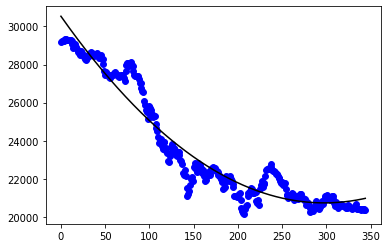

2022-06-18T06:30:00, ORDER EXPIRED
2022-06-18T06:30:00, Order Canceled
Limit ordering
2022-06-18T06:30:00, BUY EXECUTED, Price: 20338.88, Costed Total Of: 75178.86, Comm 0.00
2022-06-18T06:30:00, Order Canceled


2022-06-18T06:30:00, Close, 19416.00
2022-08-21 16:55:24:  --- Position Begin
- Size: 3.6963123639154345
- Price: 20338.882172781112
- Price orig: 0.0
- Closed: 0
- Opened: 3.6963123639154345
- Adjbase: 19416.0
--- Position End
Open Orders: 
2022-06-18T06:30:00, predict, and max, min 20974.26,  22423.71,19524.81,
Portfolio 72526.98329862521 the other one 759.3824408431392
2022-08-21 16:55:24:  Finding the best model and optimizing time...
2022-08-21 16:55:30:  FInished computing all models... Finding and returning best model
2022-08-21 16:55:30:  Remodeling inaccurate model...
2022-08-21 16:55:30:  Close all long positions here
current model value 20894.618700745854 predicted model next value 20905.24512995509


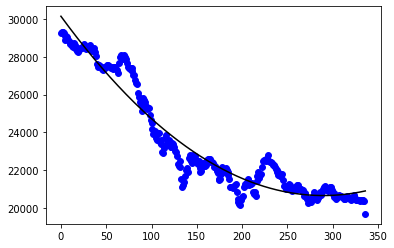

2022-06-18T07:00:00, SELL EXECUTED, Price: 19416.00, Costed Total Of: 75178.86, Comm 0.00
2022-06-18T07:00:00, OPERATION PROFIT, GROSS -3411.26, NET -3411.26


2022-06-18T07:00:00, Close, 19223.44
2022-08-21 16:55:30:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 20338.882172781112
- Closed: -3.6963123639154345
- Opened: 0
- Adjbase: 19416.0
--- Position End
Open Orders: 
2022-06-18T07:00:00, predict, and max, min 20894.62,  22344.96,19444.28,
Portfolio 72526.98329862521 the other one 72526.98329862521
2022-08-21 16:55:30:  Finding the best model and optimizing time...
2022-08-21 16:55:35:  FInished computing all models... Finding and returning best model
2022-08-21 16:55:35:  Remodeling inaccurate model...
current model value 20871.076928355487 predicted model next value 20881.617041360027


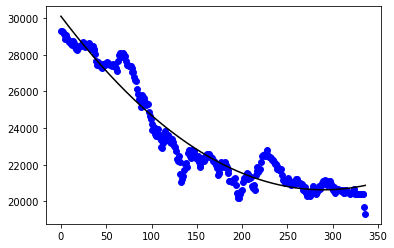



2022-06-18T07:30:00, Close, 19229.90
2022-08-21 16:55:35:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 20338.882172781112
- Closed: -3.6963123639154345
- Opened: 0
- Adjbase: 19416.0
--- Position End
Open Orders: 
2022-06-18T07:30:00, predict, and max, min 20871.08,  22332.92,19409.23,
Portfolio 72526.98329862521 the other one 72526.98329862521
2022-08-21 16:55:35:  Finding the best model and optimizing time...
2022-08-21 16:55:40:  FInished computing all models... Finding and returning best model
2022-08-21 16:55:40:  Remodeling inaccurate model...
current model value 20844.74099243609 predicted model next value 20855.153259760842


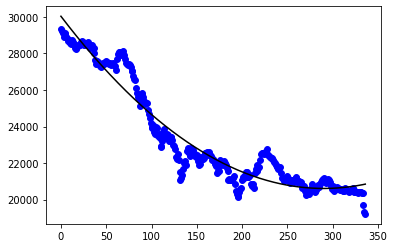



2022-06-18T08:00:00, Close, 19110.22
2022-08-21 16:55:41:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 20338.882172781112
- Closed: -3.6963123639154345
- Opened: 0
- Adjbase: 19416.0
--- Position End
Open Orders: 
2022-06-18T08:00:00, predict, and max, min 20844.74,  22319.95,19369.53,
Portfolio 72526.98329862521 the other one 72526.98329862521
2022-08-21 16:55:41:  Finding the best model and optimizing time...
2022-08-21 16:55:46:  FInished computing all models... Finding and returning best model
2022-08-21 16:55:46:  Remodeling inaccurate model...
current model value 20812.55006375972 predicted model next value 20822.756780326195


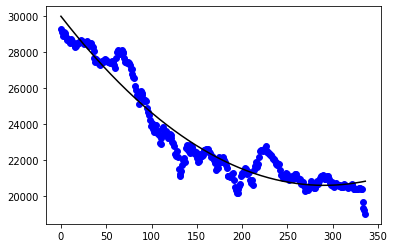



2022-06-18T08:30:00, Close, 18984.08
2022-08-21 16:55:46:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 20338.882172781112
- Closed: -3.6963123639154345
- Opened: 0
- Adjbase: 19416.0
--- Position End
Open Orders: 
2022-06-18T08:30:00, predict, and max, min 20812.55,  22304.84,19320.26,
Portfolio 72526.98329862521 the other one 72526.98329862521
2022-08-21 16:55:46:  Finding the best model and optimizing time...
2022-08-21 16:55:51:  FInished computing all models... Finding and returning best model
2022-08-21 16:55:51:  Remodeling inaccurate model...
current model value 20783.558969967013 predicted model next value 20793.598408851944


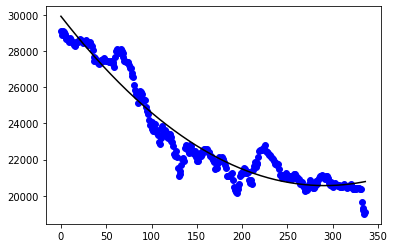



2022-06-18T09:00:00, Close, 19171.74
2022-08-21 16:55:52:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 20338.882172781112
- Closed: -3.6963123639154345
- Opened: 0
- Adjbase: 19416.0
--- Position End
Open Orders: 
2022-06-18T09:00:00, predict, and max, min 20783.56,  22287.34,19279.78,
Portfolio 72526.98329862521 the other one 72526.98329862521
2022-08-21 16:55:52:  Finding the best model and optimizing time...
2022-08-21 16:55:57:  FInished computing all models... Finding and returning best model
2022-08-21 16:55:57:  Remodeling inaccurate model...
current model value 20753.860816816366 predicted model next value 20763.734977305758


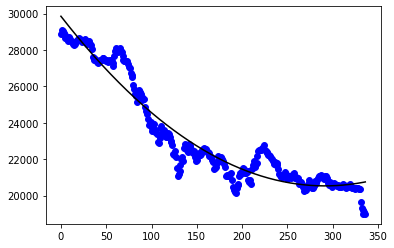



2022-06-18T09:30:00, Close, 19147.38
2022-08-21 16:55:57:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 20338.882172781112
- Closed: -3.6963123639154345
- Opened: 0
- Adjbase: 19416.0
--- Position End
Open Orders: 
2022-06-18T09:30:00, predict, and max, min 20753.86,  22267.14,19240.58,
Portfolio 72526.98329862521 the other one 72526.98329862521
2022-08-21 16:55:57:  Finding the best model and optimizing time...
2022-08-21 16:56:02:  FInished computing all models... Finding and returning best model
2022-08-21 16:56:02:  Remodeling inaccurate model...
current model value 20728.253953023734 predicted model next value 20738.0302526958


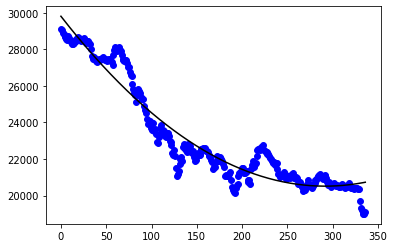



2022-06-18T10:00:00, Close, 19425.72
2022-08-21 16:56:03:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 20338.882172781112
- Closed: -3.6963123639154345
- Opened: 0
- Adjbase: 19416.0
--- Position End
Open Orders: 
2022-06-18T10:00:00, predict, and max, min 20728.25,  22246.94,19209.57,
Portfolio 72526.98329862521 the other one 72526.98329862521
2022-08-21 16:56:03:  In Uptrend
buy value 20058.460267303937
2022-06-18T10:00:00, BUY CREATE, 19425.72 and now rebalancing portfolio
current model value 20738.0302526958 predicted model next value 20748.024906237137


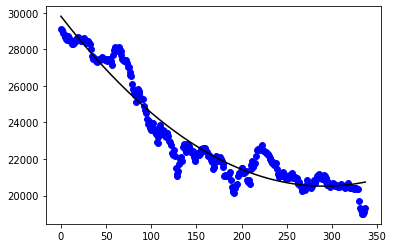

2022-06-18T10:30:00, BUY EXECUTED, Price: 19425.72, Costed Total Of: 71801.71, Comm 0.00


2022-06-18T10:30:00, Close, 19372.36
2022-08-21 16:56:03:  --- Position Begin
- Size: 3.6962189028586305
- Price: 19425.72
- Price orig: 0.0
- Closed: 0
- Opened: 3.6962189028586305
- Adjbase: 19372.36
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        3.6962189028586305
-----Order price:        None
-----Order Type:        5
-----Trail Amount:        350
-----Trail Percent:        None
-----Created Price:        19075.72
-----Is Buy:        False
2022-06-18T10:30:00, predict, and max, min 20738.03,  22260.75,19215.31,
Portfolio 72329.75305796869 the other one 725.2698329862615
2022-08-21 16:56:03:  In Uptrend
buy value 20067.37269614249
current model value 20748.024906237137 predicted model next value 20758.237913647747


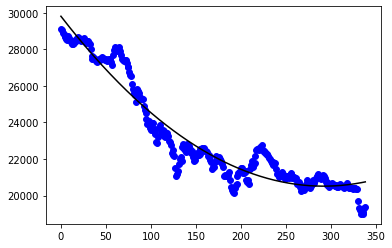



2022-06-18T11:00:00, Close, 19417.67
2022-08-21 16:56:03:  --- Position Begin
- Size: 3.6962189028586305
- Price: 19425.72
- Price orig: 0.0
- Closed: 0
- Opened: 3.6962189028586305
- Adjbase: 19417.67
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        3.6962189028586305
-----Order price:        None
-----Order Type:        5
-----Trail Amount:        350
-----Trail Percent:        None
-----Created Price:        19075.72
-----Is Buy:        False
2022-06-18T11:00:00, predict, and max, min 20748.02,  22273.98,19222.07,
Portfolio 72497.2287364572 the other one 725.2698329862615
2022-08-21 16:56:03:  In Uptrend
buy value 20076.717790063733
current model value 20758.237913647747 predicted model next value 20768.669274927626


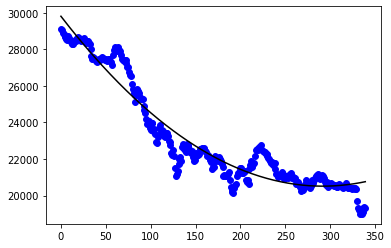



2022-06-18T11:30:00, Close, 19220.20
2022-08-21 16:56:03:  --- Position Begin
- Size: 3.6962189028586305
- Price: 19425.72
- Price orig: 0.0
- Closed: 0
- Opened: 3.6962189028586305
- Adjbase: 19220.2
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        3.6962189028586305
-----Order price:        None
-----Order Type:        5
-----Trail Amount:        350
-----Trail Percent:        None
-----Created Price:        19075.72
-----Is Buy:        False
2022-06-18T11:30:00, predict, and max, min 20758.24,  22288.31,19228.17,
Portfolio 71767.33638970972 the other one 725.2698329862615
2022-08-21 16:56:03:  Finding the best model and optimizing time...
2022-08-21 16:56:08:  FInished computing all models... Finding and returning best model
2022-08-21 16:56:08:  Remodeling inaccurate model...
2022-08-21 16:56:08:  Close all long positions here
current model value 19109.83585431698 predicted model next value 19050.02147863095


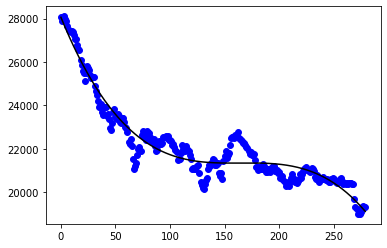

2022-06-18T12:00:00, Order Canceled
2022-06-18T12:00:00, SELL EXECUTED, Price: 19220.20, Costed Total Of: 71801.71, Comm 0.00
2022-06-18T12:00:00, OPERATION PROFIT, GROSS -759.65, NET -759.65


2022-06-18T12:00:00, Close, 19209.84
2022-08-21 16:56:09:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 19425.72
- Closed: -3.6962189028586305
- Opened: 0
- Adjbase: 19220.2
--- Position End
Open Orders: 
2022-06-18T12:00:00, predict, and max, min 19109.84,  20067.14,18152.53,
Portfolio 71767.3363897097 the other one 71767.3363897097
2022-08-21 16:56:09:  In Downtrend
2022-06-18: Limit Order / Buy at 18609.57701691203
2022-06-18: Limit Order / Sell at 19466.1506825309
current model value 19050.02147863095 predicted model next value 18989.154789964494


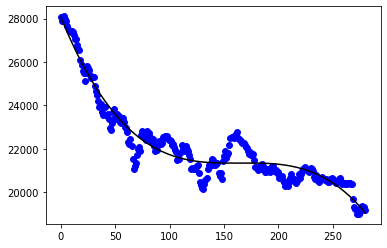



2022-06-18T12:30:00, Close, 19121.32
2022-08-21 16:56:09:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 19425.72
- Closed: -3.6962189028586305
- Opened: 0
- Adjbase: 19220.2
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        3.6499082013976816
-----Order price:        19466.1506825309
-----Order Type:        2
-----Trail Amount:        None
-----Trail Percent:        None
-----Created Price:        19466.1506825309
-----Is Buy:        False
-----Asset:             BTCUSD
-----Order Size:        3.817908540384557
-----Order price:        18609.57701691203
-----Order Type:        2
-----Trail Amount:        None
-----Trail Percent:        None
-----Created Price:        18609.57701691203
-----Is Buy:        True
2022-06-18T12:30:00, predict, and max, min 19050.02,  20006.86,18093.19,
Portfolio 71767.3363897097 the other one 71767.3363897097
2022-08-21 16:56:09:  In Downtrend
2022-06-18: Limit Order / Buy at 18548.840353752184
2022-06-18: 

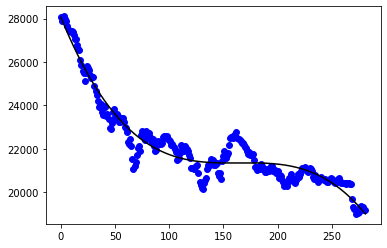

2022-06-18T13:00:00, ORDER EXPIRED
2022-06-18T13:00:00, Order Canceled


2022-06-18T13:00:00, Close, 19141.16
2022-08-21 16:56:09:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 19425.72
- Closed: -3.6962189028586305
- Opened: 0
- Adjbase: 19220.2
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        3.6615708521278845
-----Order price:        19404.14808155981
-----Order Type:        2
-----Trail Amount:        None
-----Trail Percent:        None
-----Created Price:        19404.14808155981
-----Is Buy:        False
-----Asset:             BTCUSD
-----Order Size:        3.8304099701542906
-----Order price:        18548.840353752184
-----Order Type:        2
-----Trail Amount:        None
-----Trail Percent:        None
-----Created Price:        18548.840353752184
-----Is Buy:        True
2022-06-18T13:00:00, predict, and max, min 18989.15,  19945.35,18032.96,
Portfolio 71767.3363897097 the other one 71767.3363897097
2022-08-21 16:56:09:  I

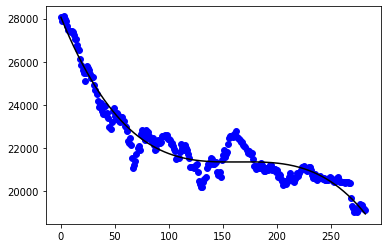

2022-06-18T13:30:00, ORDER EXPIRED
2022-06-18T13:30:00, Order Canceled


2022-06-18T13:30:00, Close, 19174.27
2022-08-21 16:56:09:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 19425.72
- Closed: -3.6962189028586305
- Opened: 0
- Adjbase: 19220.2
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        3.6733257301597644
-----Order price:        19342.05356265055
-----Order Type:        2
-----Trail Amount:        None
-----Trail Percent:        None
-----Created Price:        19342.05356265055
-----Is Buy:        False
-----Asset:             BTCUSD
-----Order Size:        3.843204512295943
-----Order price:        18487.088781899693
-----Order Type:        2
-----Trail Amount:        None
-----Trail Percent:        None
-----Created Price:        18487.088781899693
-----Is Buy:        True
2022-06-18T13:30:00, predict, and max, min 18927.23,  19882.50,17971.96,
Portfolio 71767.3363897097 the other one 71767.3363897097
2022-08-21 16:56:09:  In

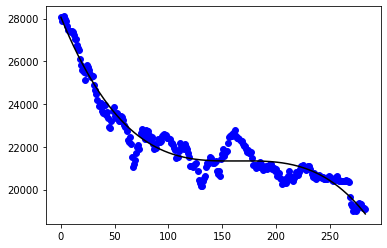

2022-06-18T14:00:00, ORDER EXPIRED
2022-06-18T14:00:00, Order Canceled


2022-06-18T14:00:00, Close, 19160.00
2022-08-21 16:56:09:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 19425.72
- Closed: -3.6962189028586305
- Opened: 0
- Adjbase: 19220.2
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        3.68537511929768
-----Order price:        19278.814428896592
-----Order Type:        2
-----Trail Amount:        None
-----Trail Percent:        None
-----Created Price:        19278.814428896592
-----Is Buy:        False
-----Asset:             BTCUSD
-----Order Size:        3.856292427819561
-----Order price:        18424.345237216818
-----Order Type:        2
-----Trail Amount:        None
-----Trail Percent:        None
-----Created Price:        18424.345237216818
-----Is Buy:        True
2022-06-18T14:00:00, predict, and max, min 18864.23,  19818.23,17910.22,
Portfolio 71767.3363897097 the other one 71767.3363897097
2022-08-21 16:56:09:  In

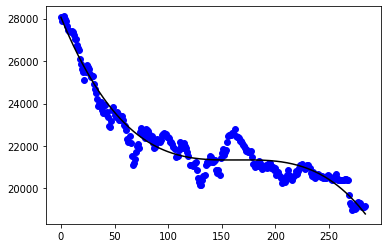

2022-06-18T14:30:00, ORDER EXPIRED
2022-06-18T14:30:00, Order Canceled


2022-06-18T14:30:00, Close, 19044.40
2022-08-21 16:56:09:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 19425.72
- Closed: -3.6962189028586305
- Opened: 0
- Adjbase: 19220.2
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        3.6977287684032913
-----Order price:        19214.406322314553
-----Order Type:        2
-----Trail Amount:        None
-----Trail Percent:        None
-----Created Price:        19214.406322314553
-----Is Buy:        False
-----Asset:             BTCUSD
-----Order Size:        3.8696773603523
-----Order price:        18360.61676711574
-----Order Type:        2
-----Trail Amount:        None
-----Trail Percent:        None
-----Created Price:        18360.61676711574
-----Is Buy:        True
2022-06-18T14:30:00, predict, and max, min 18800.15,  19752.49,17847.81,
Portfolio 71767.3363897097 the other one 71767.3363897097
2022-08-21 16:56:09:  In D

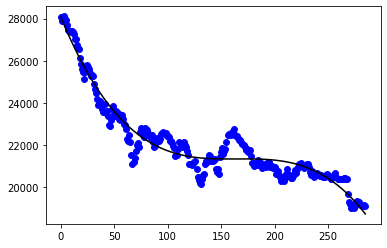

2022-06-18T15:00:00, ORDER EXPIRED
2022-06-18T15:00:00, Order Canceled


2022-06-18T15:00:00, Close, 19071.49
2022-08-21 16:56:09:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 19425.72
- Closed: -3.6962189028586305
- Opened: 0
- Adjbase: 19220.2
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        3.7103965397253993
-----Order price:        19148.805866197494
-----Order Type:        2
-----Trail Amount:        None
-----Trail Percent:        None
-----Created Price:        19148.805866197494
-----Is Buy:        False
-----Asset:             BTCUSD
-----Order Size:        3.8831378198628834
-----Order price:        18296.971758865213
-----Order Type:        2
-----Trail Amount:        None
-----Trail Percent:        None
-----Created Price:        18296.971758865213
-----Is Buy:        True
2022-06-18T15:00:00, predict, and max, min 18734.98,  19685.67,17784.29,
Portfolio 71767.3363897097 the other one 71767.3363897097
2022-08-21 16:56:09: 

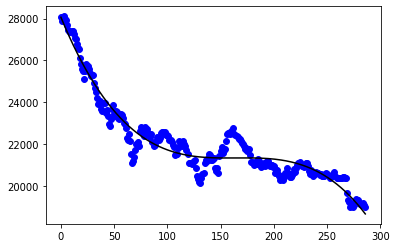

2022-06-18T15:30:00, ORDER EXPIRED
2022-06-18T15:30:00, Order Canceled
Limit ordering
2022-06-18T15:30:00, SELL EXECUTED, Price: 19081.08, Costed Total Of: 71049.66, Comm 0.00
2022-06-18T15:30:00, Order Canceled


2022-06-18T15:30:00, Close, 18915.56
2022-08-21 16:56:09:  --- Position Begin
- Size: -3.7235668503829777
- Price: 19081.07625850869
- Price orig: 0.0
- Closed: 0
- Opened: -3.7235668503829777
- Adjbase: 18915.56
--- Position End
Open Orders: 
2022-06-18T15:30:00, predict, and max, min 18668.72,  19617.82,17719.61,
Portfolio 72383.64724309207 the other one 717.6733638970909
2022-08-21 16:56:09:  In Downtrend
2022-06-18: Limit Order / Buy at 18164.22915421181
2022-06-18: Limit Order / Sell at 19013.291175709695
current model value 18601.34535644296 predicted model next value 18532.85711244667


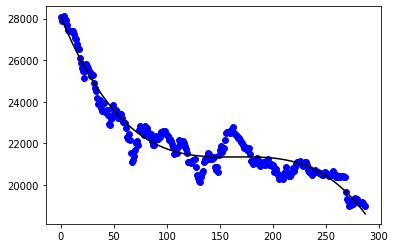

2022-06-18T16:00:00, Insufficient Margin for order of type 2
2022-06-18T16:00:00, Order Canceled


2022-06-18T16:00:00, Close, 19037.62
2022-08-21 16:56:09:  --- Position Begin
- Size: -3.7235668503829777
- Price: 19081.07625850869
- Price orig: 0.0
- Closed: 0
- Opened: -3.7235668503829777
- Adjbase: 19037.62
--- Position End
Open Orders: 
2022-06-18T16:00:00, predict, and max, min 18601.35,  19548.80,17653.89,
Portfolio 71929.14867333433 the other one 717.6733638970909
2022-08-21 16:56:09:  In Downtrend
sell value 18944.373614912816
current model value 18532.85711244667 predicted model next value 18463.243594193736


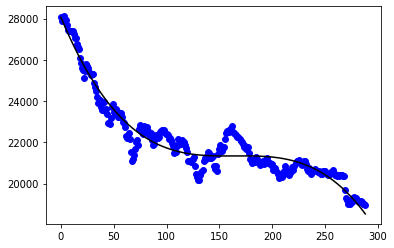



2022-06-18T16:30:00, Close, 18838.18
2022-08-21 16:56:09:  --- Position Begin
- Size: -3.7235668503829777
- Price: 19081.07625850869
- Price orig: 0.0
- Closed: 0
- Opened: -3.7235668503829777
- Adjbase: 18838.18
--- Position End
Open Orders: 
2022-06-18T16:30:00, predict, and max, min 18532.86,  19478.69,17587.03,
Portfolio 72671.7768459747 the other one 717.6733638970909
2022-08-21 16:56:09:  In Downtrend
2022-06-18: Limit Order / Buy at 18027.031962009987
2022-06-18: Limit Order / Sell at 18874.336931105994
current model value 18463.243594193736 predicted model next value 18392.49568152462


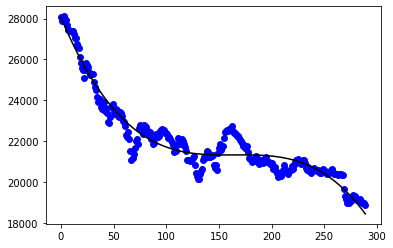

2022-06-18T17:00:00, Insufficient Margin for order of type 2
2022-06-18T17:00:00, Order Canceled


2022-06-18T17:00:00, Close, 18857.58
2022-08-21 16:56:09:  --- Position Begin
- Size: -3.7235668503829777
- Price: 19081.07625850869
- Price orig: 0.0
- Closed: 0
- Opened: -3.7235668503829777
- Adjbase: 18857.58
--- Position End
Open Orders: 
2022-06-18T17:00:00, predict, and max, min 18463.24,  19407.45,17519.04,
Portfolio 72599.53964907727 the other one 717.6733638970909
2022-08-21 16:56:09:  In Downtrend
sell value 18803.165057994946
current model value 18392.49568152462 predicted model next value 18320.604254279802


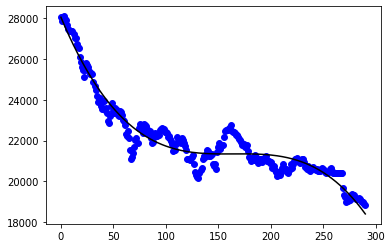



2022-06-18T17:30:00, Close, 18593.41
2022-08-21 16:56:10:  --- Position Begin
- Size: -3.7235668503829777
- Price: 19081.07625850869
- Price orig: 0.0
- Closed: 0
- Opened: -3.7235668503829777
- Adjbase: 18593.41
--- Position End
Open Orders: 
2022-06-18T17:30:00, predict, and max, min 18392.50,  19335.11,17449.88,
Portfolio 73583.19430394295 the other one 717.6733638970909
2022-08-21 16:56:10:  In Downtrend
2022-06-18: Limit Order / Buy at 17885.283425505186
2022-06-18: Limit Order / Sell at 18730.85808275401
current model value 18320.604254279802 predicted model next value 18247.560192299767


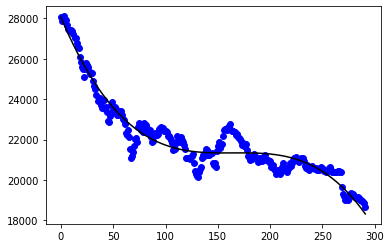

2022-06-18T18:00:00, Insufficient Margin for order of type 2
2022-06-18T18:00:00, Order Canceled


2022-06-18T18:00:00, Close, 18235.36
2022-08-21 16:56:10:  --- Position Begin
- Size: -3.7235668503829777
- Price: 19081.07625850869
- Price orig: 0.0
- Closed: 0
- Opened: -3.7235668503829777
- Adjbase: 18235.36
--- Position End
Open Orders: 
2022-06-18T18:00:00, predict, and max, min 18320.60,  19261.68,17379.53,
Portfolio 74916.41741472257 the other one 717.6733638970909
2022-08-21 16:56:10:  In Downtrend
2022-06-18: Limit Order / Buy at 17812.665673725096
2022-06-18: Limit Order / Sell at 18657.412258716922
current model value 18247.560192299767 predicted model next value 18173.354375424984


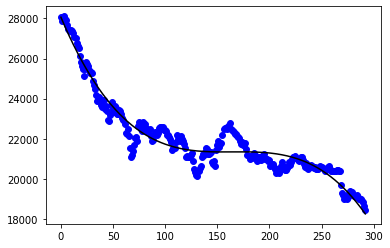

2022-06-18T18:30:00, Insufficient Margin for order of type 2
2022-06-18T18:30:00, Order Canceled


2022-06-18T18:30:00, Close, 18188.57
2022-08-21 16:56:10:  --- Position Begin
- Size: -3.7235668503829777
- Price: 19081.07625850869
- Price orig: 0.0
- Closed: 0
- Opened: -3.7235668503829777
- Adjbase: 18188.57
--- Position End
Open Orders: 
2022-06-18T18:30:00, predict, and max, min 18247.56,  19187.78,17307.35,
Portfolio 75090.643107652 the other one 717.6733638970909
2022-08-21 16:56:10:  In Downtrend
2022-06-18: Limit Order / Buy at 17738.69890352819
2022-06-18: Limit Order / Sell at 18582.981160145744
current model value 18173.354375424984 predicted model next value 18097.97768349592


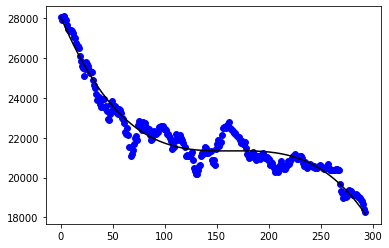

2022-06-18T19:00:00, Insufficient Margin for order of type 2
2022-06-18T19:00:00, Order Canceled


2022-06-18T19:00:00, Close, 18212.24
2022-08-21 16:56:10:  --- Position Begin
- Size: -3.7235668503829777
- Price: 19081.07625850869
- Price orig: 0.0
- Closed: 0
- Opened: -3.7235668503829777
- Adjbase: 18212.24
--- Position End
Open Orders: 
2022-06-18T19:00:00, predict, and max, min 18173.35,  19113.54,17233.17,
Portfolio 75002.50628030342 the other one 717.6733638970909
2022-08-21 16:56:10:  In Downtrend
2022-06-18: Limit Order / Buy at 17663.329614201928
2022-06-18: Limit Order / Sell at 18507.59749187661
current model value 18097.97768349592 predicted model next value 18021.420996353045


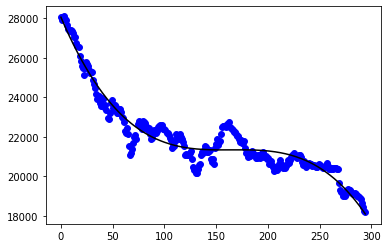

2022-06-18T19:30:00, Insufficient Margin for order of type 2
2022-06-18T19:30:00, Order Canceled


2022-06-18T19:30:00, Close, 18026.58
2022-08-21 16:56:10:  --- Position Begin
- Size: -3.7235668503829777
- Price: 19081.07625850869
- Price orig: 0.0
- Closed: 0
- Opened: -3.7235668503829777
- Adjbase: 18026.58
--- Position End
Open Orders: 
2022-06-18T19:30:00, predict, and max, min 18097.98,  19038.10,17157.85,
Portfolio 75693.82370174552 the other one 717.6733638970909
2022-08-21 16:56:10:  In Downtrend
2022-06-18: Limit Order / Buy at 17586.790290701967
2022-06-18: Limit Order / Sell at 18431.024440938323
current model value 18021.420996353045 predicted model next value 17943.675193836847


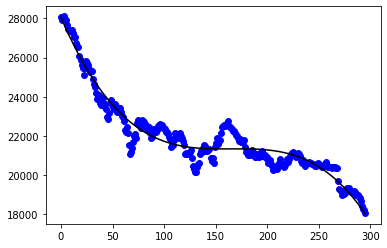

2022-06-18T20:00:00, Insufficient Margin for order of type 2
2022-06-18T20:00:00, Order Canceled


2022-06-18T20:00:00, Close, 17670.00
2022-08-21 16:56:10:  --- Position Begin
- Size: -3.7235668503829777
- Price: 19081.07625850869
- Price orig: 0.0
- Closed: 0
- Opened: -3.7235668503829777
- Adjbase: 17670.0
--- Position End
Open Orders: 
2022-06-18T20:00:00, predict, and max, min 18021.42,  18961.98,17080.87,
Portfolio 77021.57316925509 the other one 717.6733638970909
2022-08-21 16:56:10:  In Downtrend
2022-06-18: Limit Order / Buy at 17508.925471945444
2022-06-18: Limit Order / Sell at 18353.39080137188
current model value 17943.675193836847 predicted model next value 17864.7311557878


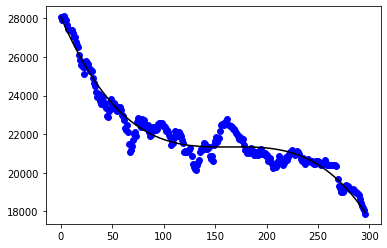

2022-06-18T20:30:00, Insufficient Margin for order of type 2
2022-06-18T20:30:00, Order Canceled


2022-06-18T20:30:00, Close, 17774.41
2022-08-21 16:56:10:  --- Position Begin
- Size: -3.7235668503829777
- Price: 19081.07625850869
- Price orig: 0.0
- Closed: 0
- Opened: -3.7235668503829777
- Adjbase: 17774.41
--- Position End
Open Orders: 
2022-06-18T20:30:00, predict, and max, min 17943.68,  18884.43,17002.92,
Portfolio 76632.7955544066 the other one 717.6733638970909
2022-08-21 16:56:10:  In Downtrend
2022-06-18: Limit Order / Buy at 17429.926128440096
2022-06-18: Limit Order / Sell at 18274.49888413507
current model value 17864.7311557878 predicted model next value 17784.57976204637


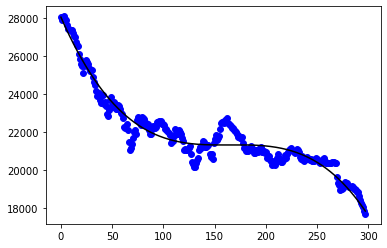

2022-06-18T21:00:00, Insufficient Margin for order of type 2
2022-06-18T21:00:00, Order Canceled


2022-06-18T21:00:00, Close, 18649.98
2022-08-21 16:56:10:  --- Position Begin
- Size: -3.7235668503829777
- Price: 19081.07625850869
- Price orig: 0.0
- Closed: 0
- Opened: -3.7235668503829777
- Adjbase: 18649.98
--- Position End
Open Orders: 
2022-06-18T21:00:00, predict, and max, min 17864.73,  18804.92,16924.54,
Portfolio 73372.55212721678 the other one 717.6733638970909
2022-08-21 16:56:10:  In Downtrend
sell value 18194.1992958709
current model value 17784.57976204637 predicted model next value 17703.211892453037


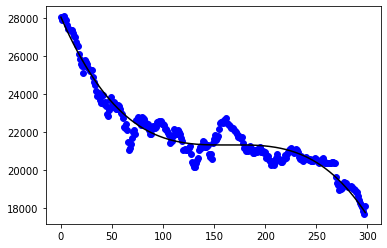



2022-06-18T21:30:00, Close, 18497.43
2022-08-21 16:56:10:  --- Position Begin
- Size: -3.7235668503829777
- Price: 19081.07625850869
- Price orig: 0.0
- Closed: 0
- Opened: -3.7235668503829777
- Adjbase: 18497.43
--- Position End
Open Orders: 
2022-06-18T21:30:00, predict, and max, min 17784.58,  18723.21,16845.94,
Portfolio 73940.5822502427 the other one 717.6733638970909
2022-08-21 16:56:10:  In Downtrend
sell value 18112.425527010924
current model value 17703.211892453037 predicted model next value 17620.618426848276


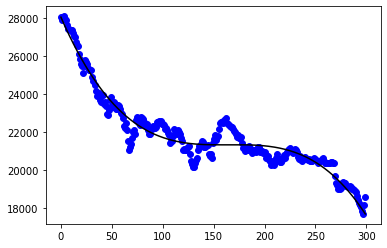



2022-06-18T22:00:00, Close, 19319.95
2022-08-21 16:56:11:  --- Position Begin
- Size: -3.7235668503829777
- Price: 19081.07625850869
- Price orig: 0.0
- Closed: 0
- Opened: -3.7235668503829777
- Adjbase: 19319.95
--- Position End
Open Orders: 
2022-06-18T22:00:00, predict, and max, min 17703.21,  18643.79,16762.63,
Portfolio 70877.8740444657 the other one 717.6733638970909
2022-08-21 16:56:11:  Finding the best model and optimizing time...
2022-08-21 16:56:16:  FInished computing all models... Finding and returning best model
2022-08-21 16:56:16:  Remodeling inaccurate model...
2022-08-21 16:56:16:  Close all short positions here
current model value 17729.10535910903 predicted model next value 17619.338983632395


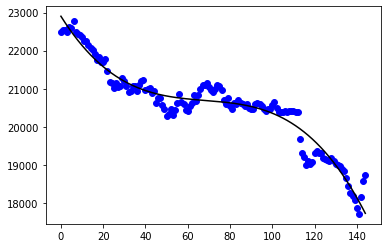

2022-06-18T22:30:00, BUY EXECUTED, Price: 19319.95, Costed Total Of: 71049.66, Comm 0.00
2022-06-18T22:30:00, OPERATION PROFIT, GROSS -889.46, NET -889.46


2022-06-18T22:30:00, Close, 19150.00
2022-08-21 16:56:16:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 19081.07625850869
- Closed: 3.7235668503829777
- Opened: 0
- Adjbase: 19319.95
--- Position End
Open Orders: 
2022-06-18T22:30:00, predict, and max, min 17729.11,  18253.64,17204.57,
Portfolio 70877.8740444657 the other one 70877.8740444657
2022-08-21 16:56:16:  Finding the best model and optimizing time...
2022-08-21 16:56:22:  FInished computing all models... Finding and returning best model
2022-08-21 16:56:22:  Remodeling inaccurate model...
current model value 18130.183237092868 predicted model next value 18080.23593615303


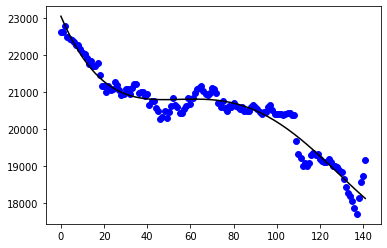



2022-06-18T23:00:00, Close, 19093.50
2022-08-21 16:56:22:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 19081.07625850869
- Closed: 3.7235668503829777
- Opened: 0
- Adjbase: 19319.95
--- Position End
Open Orders: 
2022-06-18T23:00:00, predict, and max, min 18130.18,  18633.64,17626.73,
Portfolio 70877.8740444657 the other one 70877.8740444657
2022-08-21 16:56:22:  Finding the best model and optimizing time...
2022-08-21 16:56:27:  FInished computing all models... Finding and returning best model
2022-08-21 16:56:27:  Remodeling inaccurate model...
current model value 18236.27881292562 predicted model next value 18200.77677031689


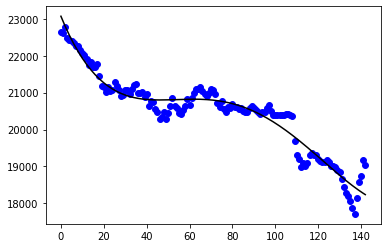



2022-06-18T23:30:00, Close, 18948.89
2022-08-21 16:56:28:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 19081.07625850869
- Closed: 3.7235668503829777
- Opened: 0
- Adjbase: 19319.95
--- Position End
Open Orders: 
2022-06-18T23:30:00, predict, and max, min 18236.28,  18758.87,17713.69,
Portfolio 70877.8740444657 the other one 70877.8740444657
2022-08-21 16:56:28:  Finding the best model and optimizing time...
2022-08-21 16:56:33:  FInished computing all models... Finding and returning best model
2022-08-21 16:56:33:  Remodeling inaccurate model...
current model value 18333.51415300843 predicted model next value 18311.114497067676


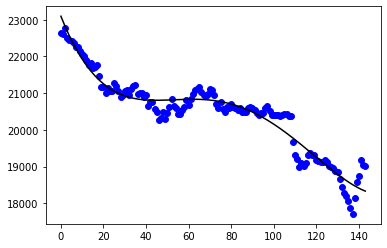



2022-06-19T00:00:00, Close, 19084.76
2022-08-21 16:56:33:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 19081.07625850869
- Closed: 3.7235668503829777
- Opened: 0
- Adjbase: 19319.95
--- Position End
Open Orders: 
2022-06-19T00:00:00, predict, and max, min 18333.51,  18867.76,17799.27,
Portfolio 70877.8740444657 the other one 70877.8740444657
2022-08-21 16:56:33:  Finding the best model and optimizing time...
2022-08-21 16:56:38:  FInished computing all models... Finding and returning best model
2022-08-21 16:56:38:  Remodeling inaccurate model...
current model value 18418.86969061012 predicted model next value 18408.0296970941


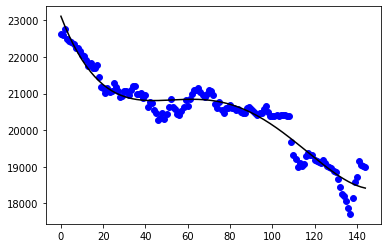



2022-06-19T00:30:00, Close, 18945.58
2022-08-21 16:56:39:  --- Position Begin
- Size: 0.0
- Price: 0.0
- Price orig: 19081.07625850869
- Closed: 3.7235668503829777
- Opened: 0
- Adjbase: 19319.95
--- Position End
Open Orders: 
2022-06-19T00:30:00, predict, and max, min 18418.87,  18959.30,17878.44,
Portfolio 70877.8740444657 the other one 70877.8740444657
2022-08-21 16:56:39:  In Downtrend
sell value 18644.00710723462
2022-06-19T00:30:00, SELL CREATE, 18945.58 and now rebalancing portfolio
current model value 18408.0296970941 predicted model next value 18400.153684621273


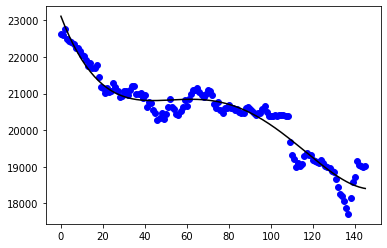

2022-06-19T01:00:00, SELL EXECUTED, Price: 18945.58, Costed Total Of: 70169.10, Comm 0.00


2022-06-19T01:00:00, Close, 18816.78
2022-08-21 16:56:39:  --- Position Begin
- Size: -3.7037185086981257
- Price: 18945.58
- Price orig: 0.0
- Closed: 0
- Opened: -3.7037185086981257
- Adjbase: 18816.78
--- Position End
Open Orders: 
-----Asset:             BTCUSD
-----Order Size:        3.7037185086981257
-----Order price:        None
-----Order Type:        5
-----Trail Amount:        350
-----Trail Percent:        None
-----Created Price:        19166.78
-----Is Buy:        True
2022-06-19T01:00:00, predict, and max, min 18408.03,  18955.19,17860.86,
Portfolio 71354.91298838603 the other one 708.7787404446572
2022-08-21 16:56:39:  In Downtrend
sell value 18637.890288114082
current model value 18400.153684621273 predicted model next value 18395.379345776313


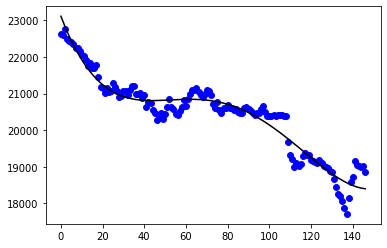

Final Portfolio Value: 71354.91298838603 ---> Return: -28.645087011613967%
Sharpe Ratio: None


In [11]:
run_backtest(strategy, 'BTCUSD', '2022-06-12T01:00:00Z', '2022-06-19T01:00:00Z', TimeFrame.Minute, 100000)
#without the limit order next candle on

In [ ]:
import random
import time
def str_time_prop(start, end, time_format, prop):
    """Get a time at a proportion of a range of two formatted times.

    start and end should be strings specifying times formatted in the
    given format (strftime-style), giving an interval [start, end].
    prop specifies how a proportion of the interval to be taken after
    start.  The returned time will be in the specified format.
    """

    stime = time.mktime(time.strptime(start, time_format))
    etime = time.mktime(time.strptime(end, time_format))

    ptime = stime + prop * (etime - stime)

    return time.strftime(time_format, time.localtime(ptime))


def random_date(start, end, prop):
    return str_time_prop(start, end, '%m/%d/%Y %I:%M %p', prop)

a = random_date(
    "1/1/2015 1:30 PM", "8/1/2022 4:50 AM", random.random())
print(datetime.strptime(a.split(" ")[0], "%m/%d/%Y"))